## make A2C fluid
# A2C流体版
# 学習

In [1]:
#!/usr/bin/python
import numpy as np
import pandas as pd
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline


from collections import deque
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from gym import spaces
from gym.spaces.box import Box


import os
import subprocess
import PyFoam
import PyFoam.FoamInformation
from PyFoam.RunDictionary.SolutionDirectory import SolutionDirectory
from PyFoam.RunDictionary.ParsedParameterFile import ParsedParameterFile
from PyFoam.Basics.DataStructures import Vector
from PyFoam.Execution.BasicRunner import BasicRunner
from PyFoam.Basics.TemplateFile import TemplateFile
import shlex,sys,json
import re
from pathlib import Path

from copy import copy
import random

In [28]:
# set directory
# 試す用
CASE = SolutionDirectory("../aircond5/Case/case0")

In [2]:
## 実行環境の設定

class Aircond:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=500,end=3000,xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        #os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5,0.7])
        self.action_DIRECTION = np.array([0, -1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([17+273.15,20+273.15,23+273.15, 26+273.15])
        #self.action_SPEED = np.array([0.1,0.3,0.5,0.8,1.0])
        #self.action_DIRECTION = np.array([-1*np.pi/16, -2*np.pi/16,-3*np.pi/16,-4*np.pi/16,-5*np.pi/16,-6*np.pi/16,-7*np.pi/16])
        #self.action_TEMPERTURE = np.array([18+273.15,19+273.15,20+273.15,22+273.15,24+273.15,25+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(64,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得
        各U1, U2, Tがすべて一列で並んだ状態を返す'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir,celsius=True):
        '''observationを２次元で取得。
        障害物があるところは全て値を0で埋める。
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        # セルシウス℃に直す
        if celsius:
            T_value = self.Celsius_(T_value)
            T_value = T_value.astype(np.float64)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        """PMVとPPDを計算
        デフォルト値。TA,VA,TR,RHまでは入力を推奨
        TA = 20  #  温度[℃]
        VA = 0.3  # 流速[m/s]
        TR = 20  # MRT[℃]
        RH = 50  # 相対湿度[%]
        AL = 1  # 活動量[met]
        CLO = 1 # 着衣量[clo]
        
        """
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        #
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''np.arrayの配列をセルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed,RH=50,AL=1,CLO=1):
        '''PMVを一つのtime_stepで全点計算
        TU_Parsed : TとUのParsedParameterFileをリストにしたもの
        全ての点のPMVとPPVの値を返す
        time=0でも、すべてのセルの値を返す。'''
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius_(T)
            MRTc = self.Celsius_(MRT)
            pmv,ppd = self.calc_PMV(TA=Tc,VA=Us,TR=MRTc,RH=RH,AL=AL,CLO=CLO)
            PMV = np.tile(pmv, self.nCells)
            PPD = np.tile(ppd, self.nCells)
        else:   
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = list(self.Celsius_(T))
            MRTc = self.Celsius_(MRT)
            
            length = len(T)
            # ループを早くするため、外に出す。
            PMV = []
            PPD = []
            PMVappend = PMV.append
            PPDappend = PPD.append
            for i in range(length):
                pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=RH,AL=AL,CLO=CLO)
                PMVappend(pmv)
                PPDappend(ppd)
            PMV = np.array(PMV)
            PPD = np.array(PPD)
        return [PMV,PPD]
    
    def calc_PMV_error(self, TU_Parsed,RH=50,AL=1,CLO=1):
        """PMVの全点の2条誤差の合計を計算
        入力はcalc_PMV_allと同じ。返すものだけが違う。
        PMVは、0との2乗誤差、PPDは0との、根平均2乗誤差を返す。
        """
        PMV, PPD = self.calc_PMV_all(TU_Parsed, RH=RH,AL=AL,CLO=CLO)
        PMV_mae = ((PMV - 0)**2).mean()
        PPD_rmse = np.sqrt( ((PPD - 0)**2).mean())
        return PMV_mae, PPD_rmse
    
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
            
    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]
        
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        
        
    def reset(self):
        '''環境のリセット'''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム）
        T_initial = ParsedParameterFile(self.CASE.initialDir() + '/T')
        # random parameter from 26 to 35
        T_rand = np.random.randint(26+273,35+273)
        T_initial['internalField'].setUniform(T_rand)
        T_initial.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        return self.observation
    
    def step_old(self, action):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
    
    
    def step(self, action, reward='PMV'):
        '''ステップを進める
        報酬はPMV等から選択
        '''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
            # rewardと、observationは1ステップ前の値をそのまま使う。
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
            # 報酬の計算。make_observationでは、0を補完していれているため、用いない。
            T_new = ParsedParameterFile(self.CASE.latestDir() + '/T')
            U_new = ParsedParameterFile(self.CASE.latestDir() + '/U')
            TU_Parsed = [T_new,U_new]
            PMV_mae, PPD_rmse = self.calc_PMV_error(TU_Parsed, RH=50,AL=1,CLO=1)
            # 報酬は、ズレ分をマイナス、ちかづいたら、プラスにする。
            self.reward = -PMV_mae + 1
            
        
        return (self.observation, self.reward, done, runOK)
        

In [3]:
# aircondを並列でたくさんつくるためのクラス

# ケースの作成
def makecase(NUM_PROCESSES,casename='Case',stride=500, end=3000, xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
    """並列でたくさんのケースをつくる
    xCells : x方向のセル数
    insert_list : 障害物があり、ゼロ埋めするセル
    """
    os.system("./makecase {} {}".format(NUM_PROCESSES, casename))
    Envs = []
    Envs_append = Envs.append
    for i in range(NUM_PROCESSES):
        CASE = SolutionDirectory("./{}/case{}".format(casename, i))
        aircond = Aircond(CASE, stride=stride, end=end, xCells=xCells, insert_list=insert_list)
        Envs_append(aircond)
    return Envs

In [31]:
# 定数の設定

#ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
#NUM_SKIP_FRAME = 4 # skipするframe数です  # 使用しない。
NUM_STACK_FRAME = 1  # 状態として連続的に保持するframe数です
#NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 10 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 3  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 0.90  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは100,000となる


In [32]:
#NUM_UPDATES = 100000
STRIDE = 300
END = 3000
XCELLS = 40
INSERT_LIST = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]

In [33]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 0.99


In [34]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [35]:
# メモリオブジェクトの定義


class RolloutStorage(object):
    '''Advantage学習するためのメモリクラスです'''

    def __init__(self, num_steps, num_processes, obs_shape):

        self.observations = torch.zeros(
            num_steps + 1, num_processes, *obs_shape).to(device)
        # *を使うと()リストの中身を取り出す
        # obs_shape→(4,84,84)
        # *obs_shape→ 4 84 84

        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(
            num_steps, num_processes, 1).long().to(device)

        # 割引報酬和を格納
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.index = 0  # insertするインデックス

    def insert(self, current_obs, action, reward, mask):
        '''次のindexにtransitionを格納する'''
        self.observations[self.index + 1].copy_(current_obs)
        self.masks[self.index + 1].copy_(mask)
        self.rewards[self.index].copy_(reward)
        self.actions[self.index].copy_(action)

        self.index = (self.index + 1) % NUM_ADVANCED_STEP  # インデックスの更新

    def after_update(self):
        '''Advantageするstep数が完了したら、最新のものをindex0に格納'''
        self.observations[0].copy_(self.observations[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value):
        '''Advantageするステップ中の各ステップの割引報酬和を計算する'''

        # 注意：5step目から逆向きに計算しています
        # 注意：5step目はAdvantage1となる。4ステップ目はAdvantage2となる。・・・
        self.returns[-1] = next_value
        for ad_step in reversed(range(self.rewards.size(0))):
            self.returns[ad_step] = self.returns[ad_step + 1] * \
                GAMMA * self.masks[ad_step + 1] + self.rewards[ad_step]


In [36]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化12*40→4*18
            init_(nn.Conv2d(3, 32, kernel_size=5,stride=2)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化4*18→3*17
            init_(nn.Conv2d(32, 64, kernel_size=2, stride=1)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=2, stride=1)),  # 画像サイズの変化3*17→2*16
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 2 * 16, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        #input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        input = x  # 正規化はしない
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy


In [37]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain(object):
    def __init__(self, actor_critic):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        #filename = 'weight.pth'
        #param = torch.load(filename, map_location='cpu')
        # self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


In [38]:
def resets(Envs):
    """環境をまとめてリセット"""
    obs = []
    obs_append = obs.append
    for i in range(len(Envs)):
        obs_ = Envs[i].reset()
        obs_append(obs_)
    obs = np.array(obs)
    return obs

In [39]:
def steps(Envs, action):
    """すべての環境で同じだけステップを進める
    obsはnumpy, done, runOKはリスト
    """
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(len(Envs)):
        obs_, reward_, done_, runOK_ = Envs[i].step(action[i])
        obs_append(obs_)
        reward_append(reward_)
        done_append(done_)
        runOK_append(runOK_)
    obs = np.array(obs)
    return obs, reward, done, runOK
    

In [40]:
def make_random_actions(Envs, max_execution=3):
    """適当にステップを進めて、環境をバラバラにするためのステップを作成。
    Envs : 環境のリスト
    max_execution : 進める最大のステップ。0~ステップ分進めることになる。
    random_actionは複素数で返す。0+1Jは補完したもの。
    """
    # 0~max_executions
    # 複素数にして、1jは補完したものとする。
    action_shape = Envs[0].action_space.shape[0]
    random_actions = []
    for i in range(len(Envs)):
        i_th_action = []
        for j in range(random.randint(0,max_execution)):
            i_th_action.append(random.randint(0, action_shape-1))
        random_actions.append(i_th_action)
        
    max_len = max(map(len, random_actions))
    random_actions = np.array(list(map(lambda x:x + [1j]*(max_len-len(x)), random_actions)))
    random_actions = random_actions.astype(np.complex128)
    return random_actions

In [41]:
def random_steps(Envs, random_actions, step_reset=True):
    """random_actions分それぞれステップを進める。
    Envs : 環境のリスト
    random_actions, len(Envs)行,進めるステップ分で構成された、random_step。
    step_reset : Envs内のpresent_timeをリセットするかどうか。
    """
    # random_step分stepを進めて、とりあえず、リストとして保存。
    obs_list = []
    reward_list = []
    done_list = []
    runOK_list = []
    obs_list_append = obs_list.append
    reward_list_append = reward_list.append
    done_list_append = done_list.append
    runOK_list_append = runOK_list.append
    # random_actions.shape[0] == len(Envs)だが、やりたくない環境がある場合
    # やらないために、len(Envs)は使わない
    for i in range(random_actions.shape[0]):
        obs_progress = []
        reward_progress = []
        done_progress = []
        runOK_progress = []
        obs_progress_append = obs_progress.append
        reward_progress_append = reward_progress.append
        done_progress_append = done_progress.append
        runOK_progress_append = runOK_progress.append
        
        for j in range(random_actions.shape[1]):
            if random_actions[i,j].imag==0:  # 補完しただけのものには1jが入ってる
                obs_, done_, reward_, runOK_ = Envs[i].step(int(random_actions[i,j].real))
                obs_progress_append(obs_)
                reward_progress_append(reward_)
            else:
                done_, runOK_ = False, True
            done_progress_append(done_)
            runOK_progress_append(runOK_)
            
        obs_list_append(obs_progress)
        reward_list_append(reward_progress)
        done_list_append(done_progress)
        runOK_list_append(runOK_progress)
    
    # 進めた結果をまとめる。
    # obs → 最後のステップのobservation or 進めない場合、そのままのobservation
    # reward → 最後のステップのreward or 進めない場合、そのままのreward
    # done → 一個でもdoneがあれば、done=Trueとする。
    # runOK → 一個でも、Falseがあれば、Falseとする。
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(random_actions.shape[0]):
        if obs_list[i]==[]:
            obs_ = Envs[i].observation
        else:
            obs_ = obs_list[i][-1]
        obs_append(obs_)
        
        if reward_list[i]==[]:
            reward_ = Envs[i].reward
        else:
            reward_ = reward_list[i][-1]
        reward_append(reward_)
        
        if any(done_list[i]):
            done_ = True
        else:
            done_ = False
        done_append(done_)
        
        if all(runOK_list[i]):
            runOK_ = True
        else:
            runOK_ = False
        runOK_append(runOK_)
    obs = np.array(obs)
    
    if step_reset:
        for i in range(random_actions.shape[0]):
            Envs[i].present_time=0
            
    return obs, reward, done, runOK

In [ ]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
Envs = makecase(NUM_PROCESSES, stride=STRIDE, end=END,
                xCells=XCELLS, insert_list = INSERT_LIST)

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done, runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 1000 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   './model/weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


  0%|          | 1/333333 [32:23<179998:55:44, 1944.00s/it]

finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


  0%|          | 2/333333 [1:02:26<176070:16:46, 1901.57s/it]Exception in thread Thread-4611:
Traceback (most recent call last):
  File "/home/mamitsu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/psutil/_pslinux.py", line 1402, in wrapper
    return fun(self, *args, **kwargs)
  File "/home/mamitsu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/psutil/_pslinux.py", line 1584, in create_time
    values = self._parse_stat_file()
  File "/home/mamitsu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/psutil/_common.py", line 337, in wrapper
    return fun(self)
  File "/home/mamitsu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/psutil/_pslinux.py", line 1441, in _parse_stat_file
    with open_binary("%s/%s/stat" % (self._procfs_path, self.pid)) as f:
  File "/home/mamitsu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/psutil/_pslinux.py", line 187, in open_binary
    return open(fname, "rb", **kwargs)
FileNotFoundError: [Errn

finished frames 3000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 226/333333 [1:35:45<2545:22:20, 27.51s/it]  

finished frames 6000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 329/333333 [1:35:45<428:02:58,  4.63s/it] 

finished frames 9000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 433/333333 [1:35:46<72:18:03,  1.28it/s] 

finished frames 12000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 537/333333 [1:35:47<12:31:53,  7.38it/s]

finished frames 15000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 641/333333 [1:35:47<2:29:20, 37.13it/s] 

finished frames 18000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 724/333333 [1:35:47<56:48, 97.58it/s]  

finished frames 21000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 829/333333 [1:35:48<32:25, 170.95it/s]

finished frames 24000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 933/333333 [1:35:48<28:13, 196.26it/s]

finished frames 27000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 1038/333333 [1:35:49<27:56, 198.19it/s]

finished frames 30000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 1141/333333 [1:35:50<27:29, 201.41it/s]

finished frames 33000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 1224/333333 [1:35:50<27:34, 200.68it/s]

finished frames 36000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 1328/333333 [1:35:50<27:26, 201.66it/s]

finished frames 39000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 1432/333333 [1:35:51<27:34, 200.60it/s]

finished frames 42000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 1536/333333 [1:35:52<27:38, 200.09it/s]

finished frames 45000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  0%|          | 1637/333333 [1:35:52<27:57, 197.77it/s]

finished frames 48000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 1738/333333 [1:35:53<27:47, 198.83it/s]

finished frames 51000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 1838/333333 [1:35:53<27:48, 198.63it/s]

finished frames 54000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 1940/333333 [1:35:54<27:44, 199.11it/s]

finished frames 57000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2000/333333 [1:35:54<27:55, 197.70it/s]

finished frames 60000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2140/333333 [1:35:55<30:07, 183.19it/s]

finished frames 63000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2240/333333 [1:35:55<28:43, 192.14it/s]

finished frames 66000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2340/333333 [1:35:56<28:19, 194.72it/s]

finished frames 69000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2441/333333 [1:35:56<27:58, 197.18it/s]

finished frames 72000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2522/333333 [1:35:57<27:51, 197.90it/s]

finished frames 75000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2624/333333 [1:35:57<27:44, 198.74it/s]

finished frames 78000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2727/333333 [1:35:58<27:44, 198.67it/s]

finished frames 81000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2830/333333 [1:35:58<27:30, 200.24it/s]

finished frames 84000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 2933/333333 [1:35:59<27:35, 199.63it/s]

finished frames 87000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3035/333333 [1:35:59<28:36, 192.39it/s]

finished frames 90000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3138/333333 [1:36:00<27:34, 199.57it/s]

finished frames 93000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3241/333333 [1:36:00<27:21, 201.13it/s]

finished frames 96000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3324/333333 [1:36:01<27:23, 200.85it/s]

finished frames 99000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3425/333333 [1:36:01<27:43, 198.37it/s]

finished frames 102000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3526/333333 [1:36:02<27:46, 197.92it/s]

finished frames 105000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3629/333333 [1:36:02<27:35, 199.17it/s]

finished frames 108000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3733/333333 [1:36:03<27:20, 200.97it/s]

finished frames 111000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3834/333333 [1:36:03<28:07, 195.27it/s]

finished frames 114000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3936/333333 [1:36:04<27:57, 196.38it/s]

finished frames 117000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 3996/333333 [1:36:04<27:52, 196.92it/s]

finished frames 120000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|          | 4135/333333 [1:36:05<30:10, 181.78it/s]

finished frames 123000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4232/333333 [1:36:06<29:08, 188.27it/s]

finished frames 126000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4330/333333 [1:36:06<28:40, 191.23it/s]

finished frames 129000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4431/333333 [1:36:07<27:48, 197.14it/s]

finished frames 132000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4531/333333 [1:36:07<27:40, 198.00it/s]

finished frames 135000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4631/333333 [1:36:08<27:43, 197.60it/s]

finished frames 138000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4732/333333 [1:36:08<27:35, 198.48it/s]

finished frames 141000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4834/333333 [1:36:09<27:34, 198.56it/s]

finished frames 144000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4935/333333 [1:36:09<27:33, 198.56it/s]

finished frames 147000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  1%|▏         | 4996/333333 [1:36:10<27:43, 197.34it/s]

finished frames 150000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5138/333333 [1:36:10<29:04, 188.11it/s]

finished frames 153000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5240/333333 [1:36:11<27:34, 198.28it/s]

finished frames 156000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5341/333333 [1:36:11<27:32, 198.45it/s]

finished frames 159000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5423/333333 [1:36:12<27:23, 199.56it/s]

finished frames 162000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5525/333333 [1:36:12<27:23, 199.42it/s]

finished frames 165000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5627/333333 [1:36:13<27:19, 199.82it/s]

finished frames 168000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5730/333333 [1:36:13<27:13, 200.61it/s]

finished frames 171000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5832/333333 [1:36:14<27:44, 196.71it/s]

finished frames 174000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5935/333333 [1:36:14<27:13, 200.41it/s]

finished frames 177000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 5997/333333 [1:36:15<27:26, 198.75it/s]

finished frames 180000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6140/333333 [1:36:16<29:19, 185.95it/s]

finished frames 183000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6221/333333 [1:36:16<28:03, 194.31it/s]

finished frames 186000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6322/333333 [1:36:17<27:40, 196.91it/s]

finished frames 189000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6424/333333 [1:36:17<27:22, 198.99it/s]

finished frames 192000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6526/333333 [1:36:18<27:20, 199.25it/s]

finished frames 195000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6629/333333 [1:36:18<27:12, 200.12it/s]

finished frames 198000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6733/333333 [1:36:19<27:05, 200.91it/s]

finished frames 201000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6837/333333 [1:36:19<27:01, 201.29it/s]

finished frames 204000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 6941/333333 [1:36:20<27:07, 200.58it/s]

finished frames 207000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7002/333333 [1:36:20<41:31, 130.97it/s]

finished frames 210000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7125/333333 [1:36:21<28:46, 188.91it/s]

finished frames 213000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7228/333333 [1:36:21<27:17, 199.18it/s]

finished frames 216000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7332/333333 [1:36:22<27:07, 200.33it/s]

finished frames 219000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7436/333333 [1:36:22<26:57, 201.50it/s]

finished frames 222000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7540/333333 [1:36:23<27:00, 201.05it/s]

finished frames 225000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7623/333333 [1:36:23<27:09, 199.91it/s]

finished frames 228000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7728/333333 [1:36:24<27:00, 200.89it/s]

finished frames 231000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7832/333333 [1:36:24<26:55, 201.44it/s]

finished frames 234000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7936/333333 [1:36:25<26:54, 201.51it/s]

finished frames 237000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 7998/333333 [1:36:25<27:00, 200.78it/s]

finished frames 240000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 8139/333333 [1:36:26<29:36, 183.09it/s]

finished frames 243000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  2%|▏         | 8239/333333 [1:36:27<27:50, 194.66it/s]

finished frames 246000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8339/333333 [1:36:27<27:28, 197.17it/s]

finished frames 249000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8439/333333 [1:36:28<27:29, 196.98it/s]

finished frames 252000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8521/333333 [1:36:28<27:10, 199.24it/s]

finished frames 255000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8626/333333 [1:36:29<26:52, 201.31it/s]

finished frames 258000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8730/333333 [1:36:29<26:45, 202.17it/s]

finished frames 261000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8835/333333 [1:36:30<26:35, 203.39it/s]

finished frames 264000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8939/333333 [1:36:30<26:51, 201.34it/s]

finished frames 267000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 8980/333333 [1:36:30<27:12, 198.64it/s]

finished frames 270000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9125/333333 [1:36:31<28:45, 187.84it/s]

finished frames 273000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9228/333333 [1:36:32<27:03, 199.66it/s]

finished frames 276000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9332/333333 [1:36:32<26:52, 200.91it/s]

finished frames 279000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9436/333333 [1:36:33<26:51, 201.00it/s]

finished frames 282000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9540/333333 [1:36:33<26:41, 202.17it/s]

finished frames 285000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9623/333333 [1:36:34<26:50, 201.04it/s]

finished frames 288000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9728/333333 [1:36:34<26:48, 201.21it/s]

finished frames 291000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9833/333333 [1:36:35<26:37, 202.53it/s]

finished frames 294000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 9938/333333 [1:36:35<26:36, 202.59it/s]

finished frames 297000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10000/333333 [1:36:36<27:01, 199.35it/s]

finished frames 300000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10141/333333 [1:36:37<30:12, 178.35it/s]

finished frames 303000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10223/333333 [1:36:37<27:41, 194.42it/s]

finished frames 306000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10327/333333 [1:36:38<26:59, 199.42it/s]

finished frames 309000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10431/333333 [1:36:38<26:52, 200.20it/s]

finished frames 312000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10536/333333 [1:36:39<26:32, 202.70it/s]

finished frames 315000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10640/333333 [1:36:39<26:39, 201.71it/s]

finished frames 318000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10723/333333 [1:36:40<26:38, 201.83it/s]

finished frames 321000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10828/333333 [1:36:40<26:30, 202.71it/s]

finished frames 324000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10933/333333 [1:36:41<26:19, 204.09it/s]

finished frames 327000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 10996/333333 [1:36:41<26:40, 201.45it/s]

finished frames 330000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 11138/333333 [1:36:42<29:22, 182.82it/s]

finished frames 333000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 11242/333333 [1:36:43<27:06, 198.08it/s]

finished frames 336000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 11325/333333 [1:36:43<26:48, 200.20it/s]

finished frames 339000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 11426/333333 [1:36:43<27:23, 195.85it/s]

finished frames 342000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 11526/333333 [1:36:44<27:35, 194.36it/s]

finished frames 345000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  3%|▎         | 11627/333333 [1:36:44<27:24, 195.61it/s]

finished frames 348000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 11730/333333 [1:36:45<26:54, 199.25it/s]

finished frames 351000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 11833/333333 [1:36:46<26:31, 202.03it/s]

finished frames 354000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 11937/333333 [1:36:46<26:23, 203.01it/s]

finished frames 357000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 11999/333333 [1:36:46<26:50, 199.47it/s]

finished frames 360000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 12123/333333 [1:36:47<29:58, 178.58it/s]

finished frames 363000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 12227/333333 [1:36:48<27:03, 197.78it/s]

finished frames 366000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 12332/333333 [1:36:48<26:33, 201.50it/s]

finished frames 369000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▎         | 12437/333333 [1:36:49<26:21, 202.88it/s]

finished frames 372000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 12521/333333 [1:36:49<26:29, 201.84it/s]

finished frames 375000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 12626/333333 [1:36:50<26:27, 202.06it/s]

finished frames 378000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 12730/333333 [1:36:50<26:37, 200.68it/s]

finished frames 381000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 12835/333333 [1:36:51<26:19, 202.92it/s]

finished frames 384000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 12940/333333 [1:36:51<26:23, 202.30it/s]

finished frames 387000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13003/333333 [1:36:52<38:19, 139.28it/s]

finished frames 390000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13127/333333 [1:36:52<27:45, 192.21it/s]

finished frames 393000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13230/333333 [1:36:53<26:35, 200.67it/s]

finished frames 396000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13335/333333 [1:36:53<26:20, 202.52it/s]

finished frames 399000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13440/333333 [1:36:54<26:14, 203.13it/s]

finished frames 402000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13524/333333 [1:36:54<26:22, 202.14it/s]

finished frames 405000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13629/333333 [1:36:55<26:17, 202.67it/s]

finished frames 408000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13734/333333 [1:36:55<26:15, 202.86it/s]

finished frames 411000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13839/333333 [1:36:56<26:20, 202.13it/s]

finished frames 414000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13923/333333 [1:36:56<26:36, 200.03it/s]

finished frames 417000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 13986/333333 [1:36:57<26:44, 199.09it/s]

finished frames 420000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14128/333333 [1:36:58<28:30, 186.65it/s]

finished frames 423000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14228/333333 [1:36:58<27:07, 196.10it/s]

finished frames 426000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14329/333333 [1:36:59<26:51, 197.96it/s]

finished frames 429000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14431/333333 [1:36:59<26:38, 199.44it/s]

finished frames 432000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14534/333333 [1:37:00<26:36, 199.67it/s]

finished frames 435000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14637/333333 [1:37:00<26:34, 199.84it/s]

finished frames 438000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14740/333333 [1:37:01<26:29, 200.43it/s]

finished frames 441000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14823/333333 [1:37:01<26:35, 199.64it/s]

finished frames 444000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14928/333333 [1:37:02<26:26, 200.65it/s]

finished frames 447000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  4%|▍         | 14990/333333 [1:37:02<26:36, 199.45it/s]

finished frames 450000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15135/333333 [1:37:03<28:10, 188.20it/s]

finished frames 453000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15238/333333 [1:37:03<26:26, 200.44it/s]

finished frames 456000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15322/333333 [1:37:04<26:13, 202.10it/s]

finished frames 459000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15427/333333 [1:37:04<26:09, 202.50it/s]

finished frames 462000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15532/333333 [1:37:05<26:08, 202.63it/s]

finished frames 465000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15637/333333 [1:37:05<26:05, 202.97it/s]

finished frames 468000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15742/333333 [1:37:06<26:04, 203.00it/s]

finished frames 471000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15826/333333 [1:37:06<26:04, 203.00it/s]

finished frames 474000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 15931/333333 [1:37:07<25:55, 204.10it/s]

finished frames 477000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 16036/333333 [1:37:07<26:11, 201.84it/s]

finished frames 480000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 16141/333333 [1:37:08<25:51, 204.48it/s]

finished frames 483000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 16225/333333 [1:37:08<25:54, 203.96it/s]

finished frames 486000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 16330/333333 [1:37:09<25:58, 203.44it/s]

finished frames 489000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 16433/333333 [1:37:09<26:13, 201.43it/s]

finished frames 492000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 16538/333333 [1:37:10<25:51, 204.25it/s]

finished frames 495000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▍         | 16622/333333 [1:37:10<25:46, 204.84it/s]

finished frames 498000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 16728/333333 [1:37:11<25:29, 207.03it/s]

finished frames 501000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 16838/333333 [1:37:11<24:51, 212.16it/s]

finished frames 504000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 16924/333333 [1:37:12<26:13, 201.14it/s]

finished frames 507000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 16987/333333 [1:37:12<26:08, 201.75it/s]

finished frames 510000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17128/333333 [1:37:13<28:45, 183.21it/s]

finished frames 513000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17229/333333 [1:37:13<27:42, 190.14it/s]

finished frames 516000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17331/333333 [1:37:14<26:39, 197.61it/s]

finished frames 519000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17435/333333 [1:37:15<25:58, 202.69it/s]

finished frames 522000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17540/333333 [1:37:15<26:06, 201.61it/s]

finished frames 525000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17624/333333 [1:37:15<25:56, 202.83it/s]

finished frames 528000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17729/333333 [1:37:16<25:48, 203.82it/s]

finished frames 531000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17834/333333 [1:37:17<25:48, 203.71it/s]

finished frames 534000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 17939/333333 [1:37:17<25:50, 203.42it/s]

finished frames 537000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 18022/333333 [1:37:17<29:22, 178.95it/s]

finished frames 540000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 18122/333333 [1:37:18<26:58, 194.70it/s]

finished frames 543000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 18224/333333 [1:37:19<26:31, 197.98it/s]

finished frames 546000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  5%|▌         | 18324/333333 [1:37:19<26:35, 197.45it/s]

finished frames 549000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 18424/333333 [1:37:20<26:31, 197.86it/s]

finished frames 552000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 18524/333333 [1:37:20<26:38, 196.97it/s]

finished frames 555000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 18627/333333 [1:37:21<26:21, 199.00it/s]

finished frames 558000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 18730/333333 [1:37:21<26:03, 201.22it/s]

finished frames 561000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 18833/333333 [1:37:22<26:16, 199.54it/s]

finished frames 564000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 18936/333333 [1:37:22<25:48, 202.98it/s]

finished frames 567000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 18999/333333 [1:37:22<25:53, 202.39it/s]

finished frames 570000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19140/333333 [1:37:23<28:08, 186.13it/s]

finished frames 573000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19241/333333 [1:37:24<26:43, 195.86it/s]

finished frames 576000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19324/333333 [1:37:24<26:05, 200.52it/s]

finished frames 579000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19429/333333 [1:37:25<25:46, 202.92it/s]

finished frames 582000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19534/333333 [1:37:25<25:48, 202.69it/s]

finished frames 585000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19639/333333 [1:37:26<25:49, 202.46it/s]

finished frames 588000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19722/333333 [1:37:26<25:55, 201.60it/s]

finished frames 591000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19825/333333 [1:37:27<26:20, 198.31it/s]

finished frames 594000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19925/333333 [1:37:27<26:42, 195.60it/s]

finished frames 597000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 19985/333333 [1:37:28<26:59, 193.47it/s]

finished frames 600000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 20128/333333 [1:37:29<29:00, 179.97it/s]

finished frames 603000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 20231/333333 [1:37:29<26:10, 199.33it/s]

finished frames 606000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 20336/333333 [1:37:30<25:51, 201.77it/s]

finished frames 609000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 20441/333333 [1:37:30<25:36, 203.62it/s]

finished frames 612000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 20525/333333 [1:37:31<25:38, 203.35it/s]

finished frames 615000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 20630/333333 [1:37:31<25:38, 203.29it/s]

finished frames 618000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▌         | 20735/333333 [1:37:32<25:38, 203.17it/s]

finished frames 621000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 20840/333333 [1:37:32<25:34, 203.71it/s]

finished frames 624000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 20924/333333 [1:37:33<25:38, 203.07it/s]

finished frames 627000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 20987/333333 [1:37:33<25:57, 200.50it/s]

finished frames 630000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 21128/333333 [1:37:34<28:32, 182.32it/s]

finished frames 633000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 21228/333333 [1:37:34<26:42, 194.82it/s]

finished frames 636000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 21329/333333 [1:37:35<26:26, 196.65it/s]

finished frames 639000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 21432/333333 [1:37:35<26:03, 199.45it/s]

finished frames 642000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 21536/333333 [1:37:36<25:41, 202.28it/s]

finished frames 645000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  6%|▋         | 21641/333333 [1:37:36<25:30, 203.62it/s]

finished frames 648000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 21725/333333 [1:37:37<25:31, 203.46it/s]

finished frames 651000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 21830/333333 [1:37:37<25:23, 204.47it/s]

finished frames 654000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 21935/333333 [1:37:38<25:23, 204.46it/s]

finished frames 657000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 21998/333333 [1:37:38<25:30, 203.47it/s]

finished frames 660000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22124/333333 [1:37:39<30:20, 170.94it/s]

finished frames 663000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22228/333333 [1:37:40<26:21, 196.78it/s]

finished frames 666000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22333/333333 [1:37:40<25:33, 202.76it/s]

finished frames 669000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22438/333333 [1:37:41<25:38, 202.03it/s]

finished frames 672000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22522/333333 [1:37:41<25:35, 202.47it/s]

finished frames 675000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22627/333333 [1:37:42<25:42, 201.39it/s]

finished frames 678000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22731/333333 [1:37:42<25:37, 201.99it/s]

finished frames 681000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22836/333333 [1:37:43<25:32, 202.67it/s]

finished frames 684000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22941/333333 [1:37:43<25:33, 202.42it/s]

finished frames 687000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 22983/333333 [1:37:44<25:55, 199.47it/s]

finished frames 690000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23122/333333 [1:37:44<28:18, 182.65it/s]

finished frames 693000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23222/333333 [1:37:45<27:22, 188.84it/s]

finished frames 696000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23323/333333 [1:37:46<26:18, 196.36it/s]

finished frames 699000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23424/333333 [1:37:46<26:03, 198.24it/s]

finished frames 702000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23528/333333 [1:37:47<25:44, 200.60it/s]

finished frames 705000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23632/333333 [1:37:47<25:46, 200.20it/s]

finished frames 708000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23737/333333 [1:37:48<25:26, 202.78it/s]

finished frames 711000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23821/333333 [1:37:48<25:33, 201.82it/s]

finished frames 714000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23925/333333 [1:37:49<26:30, 194.53it/s]

finished frames 717000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 23986/333333 [1:37:49<26:33, 194.17it/s]

finished frames 720000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24125/333333 [1:37:50<28:43, 179.41it/s]

finished frames 723000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24223/333333 [1:37:50<27:11, 189.49it/s]

finished frames 726000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24322/333333 [1:37:51<26:41, 192.97it/s]

finished frames 729000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24423/333333 [1:37:51<27:00, 190.63it/s]

finished frames 732000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24524/333333 [1:37:52<26:18, 195.67it/s]

finished frames 735000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24624/333333 [1:37:52<26:40, 192.87it/s]

finished frames 738000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24724/333333 [1:37:53<26:38, 193.09it/s]

finished frames 741000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24824/333333 [1:37:53<26:42, 192.52it/s]

finished frames 744000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24923/333333 [1:37:54<26:58, 190.50it/s]

finished frames 747000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  7%|▋         | 24981/333333 [1:37:54<27:34, 186.43it/s]

finished frames 750000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25136/333333 [1:37:55<28:24, 180.83it/s]

finished frames 753000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25234/333333 [1:37:56<27:00, 190.18it/s]

finished frames 756000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25334/333333 [1:37:56<26:09, 196.29it/s]

finished frames 759000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25434/333333 [1:37:57<26:04, 196.77it/s]

finished frames 762000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25535/333333 [1:37:57<25:55, 197.85it/s]

finished frames 765000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25635/333333 [1:37:58<25:59, 197.34it/s]

finished frames 768000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25736/333333 [1:37:58<26:16, 195.08it/s]

finished frames 771000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25838/333333 [1:37:59<26:36, 192.62it/s]

finished frames 774000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 25940/333333 [1:38:00<26:11, 195.65it/s]

finished frames 777000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26000/333333 [1:38:00<26:55, 190.28it/s]

finished frames 780000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26124/333333 [1:38:01<27:43, 184.66it/s]

finished frames 783000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26226/333333 [1:38:01<27:36, 185.41it/s]

finished frames 786000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26327/333333 [1:38:02<26:06, 195.96it/s]

finished frames 789000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26427/333333 [1:38:02<26:23, 193.78it/s]

finished frames 792000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26527/333333 [1:38:03<26:01, 196.45it/s]

finished frames 795000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26628/333333 [1:38:03<25:51, 197.67it/s]

finished frames 798000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26732/333333 [1:38:04<25:12, 202.67it/s]

finished frames 801000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26837/333333 [1:38:04<25:11, 202.77it/s]

finished frames 804000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 26940/333333 [1:38:05<25:39, 199.03it/s]

finished frames 807000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27000/333333 [1:38:05<25:51, 197.50it/s]

finished frames 810000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27140/333333 [1:38:06<27:44, 183.93it/s]

finished frames 813000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27240/333333 [1:38:07<26:12, 194.67it/s]

finished frames 816000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27340/333333 [1:38:07<25:58, 196.36it/s]

finished frames 819000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27440/333333 [1:38:08<25:56, 196.52it/s]

finished frames 822000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27540/333333 [1:38:08<25:52, 196.96it/s]

finished frames 825000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27641/333333 [1:38:09<25:46, 197.64it/s]

finished frames 828000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27723/333333 [1:38:09<25:43, 198.00it/s]

finished frames 831000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27825/333333 [1:38:10<25:31, 199.48it/s]

finished frames 834000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 27928/333333 [1:38:10<25:26, 200.08it/s]

finished frames 837000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 28010/333333 [1:38:11<35:43, 142.45it/s]

finished frames 840000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 28133/333333 [1:38:11<26:38, 190.89it/s]

finished frames 843000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  8%|▊         | 28236/333333 [1:38:12<25:32, 199.12it/s]

finished frames 846000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28339/333333 [1:38:12<25:28, 199.55it/s]

finished frames 849000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28422/333333 [1:38:13<25:08, 202.12it/s]

finished frames 852000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28527/333333 [1:38:13<24:58, 203.42it/s]

finished frames 855000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28632/333333 [1:38:14<25:05, 202.35it/s]

finished frames 858000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28736/333333 [1:38:14<25:10, 201.60it/s]

finished frames 861000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28840/333333 [1:38:15<25:04, 202.45it/s]

finished frames 864000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28924/333333 [1:38:15<24:59, 202.96it/s]

finished frames 867000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 28987/333333 [1:38:15<25:04, 202.34it/s]

finished frames 870000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▊         | 29131/333333 [1:38:16<27:19, 185.49it/s]

finished frames 873000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29233/333333 [1:38:17<26:11, 193.50it/s]

finished frames 876000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29332/333333 [1:38:17<27:01, 187.47it/s]

finished frames 879000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29429/333333 [1:38:18<26:51, 188.63it/s]

finished frames 882000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29529/333333 [1:38:19<26:07, 193.86it/s]

finished frames 885000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29630/333333 [1:38:19<25:31, 198.25it/s]

finished frames 888000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29731/333333 [1:38:20<25:28, 198.57it/s]

finished frames 891000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29833/333333 [1:38:20<25:27, 198.71it/s]

finished frames 894000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29936/333333 [1:38:21<25:00, 202.26it/s]

finished frames 897000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 29999/333333 [1:38:21<25:00, 202.14it/s]

finished frames 900000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30122/333333 [1:38:22<27:44, 182.20it/s]

finished frames 903000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30222/333333 [1:38:22<26:20, 191.76it/s]

finished frames 906000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30322/333333 [1:38:23<25:44, 196.25it/s]

finished frames 909000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30423/333333 [1:38:23<25:37, 197.04it/s]

finished frames 912000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30524/333333 [1:38:24<25:32, 197.57it/s]

finished frames 915000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30624/333333 [1:38:24<25:28, 198.01it/s]

finished frames 918000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30724/333333 [1:38:25<25:34, 197.17it/s]

finished frames 921000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30825/333333 [1:38:25<25:27, 198.00it/s]

finished frames 924000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30926/333333 [1:38:26<25:24, 198.31it/s]

finished frames 927000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 30987/333333 [1:38:26<25:11, 200.08it/s]

finished frames 930000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 31128/333333 [1:38:27<27:17, 184.54it/s]

finished frames 933000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 31228/333333 [1:38:28<25:50, 194.84it/s]

finished frames 936000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 31328/333333 [1:38:28<25:30, 197.26it/s]

finished frames 939000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 31429/333333 [1:38:29<25:12, 199.59it/s]

finished frames 942000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 31533/333333 [1:38:29<24:48, 202.78it/s]

finished frames 945000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


  9%|▉         | 31637/333333 [1:38:30<24:53, 202.01it/s]

finished frames 948000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 31741/333333 [1:38:30<24:50, 202.38it/s]

finished frames 951000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 31825/333333 [1:38:31<24:51, 202.12it/s]

finished frames 954000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 31930/333333 [1:38:31<24:51, 202.09it/s]

finished frames 957000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 31993/333333 [1:38:31<24:51, 202.08it/s]

finished frames 960000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32137/333333 [1:38:32<27:16, 184.04it/s]

finished frames 963000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32241/333333 [1:38:33<25:07, 199.79it/s]

finished frames 966000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32324/333333 [1:38:33<24:54, 201.45it/s]

finished frames 969000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32429/333333 [1:38:34<24:46, 202.49it/s]

finished frames 972000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32534/333333 [1:38:34<24:43, 202.79it/s]

finished frames 975000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32639/333333 [1:38:35<24:39, 203.28it/s]

finished frames 978000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32723/333333 [1:38:35<25:00, 200.33it/s]

finished frames 981000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32828/333333 [1:38:36<24:45, 202.32it/s]

finished frames 984000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32933/333333 [1:38:36<24:34, 203.71it/s]

finished frames 987000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 32996/333333 [1:38:37<24:41, 202.69it/s]

finished frames 990000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 33138/333333 [1:38:38<27:04, 184.76it/s]

finished frames 993000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|▉         | 33238/333333 [1:38:38<25:44, 194.27it/s]

finished frames 996000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33338/333333 [1:38:39<25:24, 196.84it/s]

finished frames 999000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33438/333333 [1:38:39<25:20, 197.26it/s]

finished frames 1002000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33541/333333 [1:38:40<24:54, 200.64it/s]

finished frames 1005000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33625/333333 [1:38:40<24:49, 201.23it/s]

finished frames 1008000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33729/333333 [1:38:41<24:45, 201.65it/s]

finished frames 1011000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33833/333333 [1:38:41<24:43, 201.94it/s]

finished frames 1014000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33938/333333 [1:38:42<24:33, 203.15it/s]

finished frames 1017000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 33980/333333 [1:38:42<24:53, 200.43it/s]

finished frames 1020000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34123/333333 [1:38:43<26:41, 186.88it/s]

finished frames 1023000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34224/333333 [1:38:43<25:26, 195.98it/s]

finished frames 1026000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34327/333333 [1:38:44<24:49, 200.80it/s]

finished frames 1029000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34432/333333 [1:38:44<24:28, 203.58it/s]

finished frames 1032000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34537/333333 [1:38:45<24:24, 203.98it/s]

finished frames 1035000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34642/333333 [1:38:45<24:24, 203.95it/s]

finished frames 1038000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34726/333333 [1:38:46<24:26, 203.67it/s]

finished frames 1041000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34831/333333 [1:38:46<24:24, 203.80it/s]

finished frames 1044000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34936/333333 [1:38:47<24:14, 205.09it/s]

finished frames 1047000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 10%|█         | 34999/333333 [1:38:47<24:23, 203.82it/s]

finished frames 1050000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35124/333333 [1:38:48<27:27, 180.97it/s]

finished frames 1053000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35229/333333 [1:38:49<24:40, 201.39it/s]

finished frames 1056000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35334/333333 [1:38:49<24:16, 204.64it/s]

finished frames 1059000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35439/333333 [1:38:50<24:23, 203.51it/s]

finished frames 1062000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35523/333333 [1:38:50<24:21, 203.83it/s]

finished frames 1065000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35628/333333 [1:38:50<24:13, 204.79it/s]

finished frames 1068000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35733/333333 [1:38:51<24:11, 205.05it/s]

finished frames 1071000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35838/333333 [1:38:52<24:06, 205.65it/s]

finished frames 1074000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35922/333333 [1:38:52<24:13, 204.62it/s]

finished frames 1077000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 35985/333333 [1:38:52<24:27, 202.62it/s]

finished frames 1080000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36129/333333 [1:38:53<27:30, 180.10it/s]

finished frames 1083000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36232/333333 [1:38:54<25:02, 197.67it/s]

finished frames 1086000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36336/333333 [1:38:54<24:29, 202.10it/s]

finished frames 1089000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36441/333333 [1:38:55<24:12, 204.38it/s]

finished frames 1092000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36525/333333 [1:38:55<24:14, 204.07it/s]

finished frames 1095000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36630/333333 [1:38:56<24:09, 204.67it/s]

finished frames 1098000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36735/333333 [1:38:56<24:22, 202.79it/s]

finished frames 1101000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36840/333333 [1:38:57<24:06, 204.92it/s]

finished frames 1104000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36924/333333 [1:38:57<24:13, 203.87it/s]

finished frames 1107000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 36987/333333 [1:38:58<24:18, 203.19it/s]

finished frames 1110000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 37126/333333 [1:38:59<30:34, 161.49it/s]

finished frames 1113000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 37240/333333 [1:38:59<28:43, 171.78it/s]

finished frames 1116000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 37316/333333 [1:39:00<42:06, 117.14it/s]

finished frames 1119000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█         | 37405/333333 [1:39:01<45:30, 108.38it/s]

finished frames 1122000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 37522/333333 [1:39:02<45:06, 109.31it/s]

finished frames 1125000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 37627/333333 [1:39:03<38:18, 128.63it/s]

finished frames 1128000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 37712/333333 [1:39:03<38:19, 128.55it/s]

finished frames 1131000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 37823/333333 [1:39:04<39:41, 124.08it/s]

finished frames 1134000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 37915/333333 [1:39:05<33:26, 147.22it/s]

finished frames 1137000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 37984/333333 [1:39:05<33:07, 148.64it/s]

finished frames 1140000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 38129/333333 [1:39:06<30:30, 161.31it/s]

finished frames 1143000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 38223/333333 [1:39:07<31:53, 154.19it/s]

finished frames 1146000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 11%|█▏        | 38317/333333 [1:39:07<31:36, 155.53it/s]

finished frames 1149000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 38414/333333 [1:39:08<26:41, 184.10it/s]

finished frames 1152000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 38525/333333 [1:39:09<32:26, 151.49it/s]

finished frames 1155000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 38620/333333 [1:39:09<29:50, 164.56it/s]

finished frames 1158000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 38738/333333 [1:39:10<26:58, 181.97it/s]

finished frames 1161000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 38813/333333 [1:39:10<29:04, 168.81it/s]

finished frames 1164000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 38926/333333 [1:39:11<29:26, 166.64it/s]

finished frames 1167000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39001/333333 [1:39:12<36:01, 136.19it/s]

finished frames 1170000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39130/333333 [1:39:12<31:21, 156.33it/s]

finished frames 1173000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39217/333333 [1:39:13<32:16, 151.84it/s]

finished frames 1176000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39317/333333 [1:39:14<32:15, 151.89it/s]

finished frames 1179000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39422/333333 [1:39:14<30:24, 161.11it/s]

finished frames 1182000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39520/333333 [1:39:15<27:11, 180.12it/s]

finished frames 1185000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39637/333333 [1:39:16<26:05, 187.61it/s]

finished frames 1188000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39741/333333 [1:39:16<24:11, 202.22it/s]

finished frames 1191000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39822/333333 [1:39:17<28:07, 173.95it/s]

finished frames 1194000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39926/333333 [1:39:17<24:46, 197.41it/s]

finished frames 1197000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 39989/333333 [1:39:17<24:19, 201.01it/s]

finished frames 1200000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40135/333333 [1:39:18<25:51, 188.95it/s]

finished frames 1203000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40235/333333 [1:39:19<26:51, 181.87it/s]

finished frames 1206000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40327/333333 [1:39:20<32:15, 151.38it/s]

finished frames 1209000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40438/333333 [1:39:20<28:19, 172.39it/s]

finished frames 1212000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40515/333333 [1:39:21<28:42, 169.95it/s]

finished frames 1215000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40627/333333 [1:39:21<31:01, 157.26it/s]

finished frames 1218000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40718/333333 [1:39:22<29:43, 164.06it/s]

finished frames 1221000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40827/333333 [1:39:23<29:27, 165.50it/s]

finished frames 1224000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40917/333333 [1:39:23<31:34, 154.38it/s]

finished frames 1227000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 40991/333333 [1:39:24<30:05, 161.89it/s]

finished frames 1230000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 41133/333333 [1:39:25<30:21, 160.41it/s]

finished frames 1233000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 41237/333333 [1:39:25<24:55, 195.38it/s]

finished frames 1236000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 41320/333333 [1:39:26<24:07, 201.69it/s]

finished frames 1239000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 41433/333333 [1:39:26<30:53, 157.48it/s]

finished frames 1242000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 41517/333333 [1:39:27<32:21, 150.34it/s]

finished frames 1245000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 12%|█▏        | 41626/333333 [1:39:28<33:20, 145.83it/s]

finished frames 1248000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 41728/333333 [1:39:28<29:40, 163.81it/s]

finished frames 1251000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 41824/333333 [1:39:29<27:20, 177.67it/s]

finished frames 1254000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 41919/333333 [1:39:29<30:18, 160.25it/s]

finished frames 1257000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42009/333333 [1:39:30<43:43, 111.05it/s]

finished frames 1260000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42120/333333 [1:39:31<33:33, 144.61it/s]

finished frames 1263000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42232/333333 [1:39:32<31:44, 152.88it/s]

finished frames 1266000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42330/333333 [1:39:32<33:00, 146.93it/s]

finished frames 1269000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42421/333333 [1:39:33<34:07, 142.10it/s]

finished frames 1272000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42526/333333 [1:39:34<29:00, 167.06it/s]

finished frames 1275000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42631/333333 [1:39:34<29:36, 163.67it/s]

finished frames 1278000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42715/333333 [1:39:35<32:02, 151.19it/s]

finished frames 1281000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42825/333333 [1:39:36<33:46, 143.39it/s]

finished frames 1284000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42925/333333 [1:39:36<31:07, 155.52it/s]

finished frames 1287000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 42995/333333 [1:39:37<31:47, 152.19it/s]

finished frames 1290000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43133/333333 [1:39:38<30:51, 156.75it/s]

finished frames 1293000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43223/333333 [1:39:38<29:50, 162.01it/s]

finished frames 1296000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43316/333333 [1:39:39<30:19, 159.36it/s]

finished frames 1299000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43427/333333 [1:39:40<29:59, 161.15it/s]

finished frames 1302000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43517/333333 [1:39:40<28:39, 168.53it/s]

finished frames 1305000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43626/333333 [1:39:41<27:42, 174.25it/s]

finished frames 1308000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43729/333333 [1:39:41<24:35, 196.27it/s]

finished frames 1311000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43824/333333 [1:39:42<29:42, 162.45it/s]

finished frames 1314000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 43938/333333 [1:39:42<26:58, 178.85it/s]

finished frames 1317000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44012/333333 [1:39:43<36:40, 131.49it/s]

finished frames 1320000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44133/333333 [1:39:44<26:46, 180.01it/s]

finished frames 1323000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44229/333333 [1:39:44<29:02, 165.95it/s]

finished frames 1326000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44326/333333 [1:39:45<29:53, 161.14it/s]

finished frames 1329000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44433/333333 [1:39:45<28:25, 169.39it/s]

finished frames 1332000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44537/333333 [1:39:46<24:27, 196.76it/s]

finished frames 1335000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44620/333333 [1:39:46<23:59, 200.57it/s]

finished frames 1338000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44714/333333 [1:39:47<29:24, 163.57it/s]

finished frames 1341000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44834/333333 [1:39:48<25:00, 192.26it/s]

finished frames 1344000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44936/333333 [1:39:48<26:08, 183.87it/s]

finished frames 1347000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 13%|█▎        | 44993/333333 [1:39:49<26:24, 181.97it/s]

finished frames 1350000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▎        | 45128/333333 [1:39:49<26:39, 180.22it/s]

finished frames 1353000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▎        | 45230/333333 [1:39:50<25:46, 186.30it/s]

finished frames 1356000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▎        | 45332/333333 [1:39:50<24:25, 196.56it/s]

finished frames 1359000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▎        | 45428/333333 [1:39:51<30:46, 155.88it/s]

finished frames 1362000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▎        | 45528/333333 [1:39:52<29:08, 164.57it/s]

finished frames 1365000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▎        | 45627/333333 [1:39:52<27:01, 177.43it/s]

finished frames 1368000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▎        | 45724/333333 [1:39:53<29:14, 163.88it/s]

finished frames 1371000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 45837/333333 [1:39:53<26:51, 178.43it/s]

finished frames 1374000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 45935/333333 [1:39:54<26:20, 181.80it/s]

finished frames 1377000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 45993/333333 [1:39:54<26:52, 178.19it/s]

finished frames 1380000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46124/333333 [1:39:55<27:54, 171.55it/s]

finished frames 1383000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46240/333333 [1:39:56<26:55, 177.76it/s]

finished frames 1386000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46336/333333 [1:39:56<26:50, 178.25it/s]

finished frames 1389000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46430/333333 [1:39:57<29:44, 160.78it/s]

finished frames 1392000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46521/333333 [1:39:58<30:51, 154.93it/s]

finished frames 1395000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46621/333333 [1:39:58<25:20, 188.59it/s]

finished frames 1398000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46714/333333 [1:39:59<30:04, 158.81it/s]

finished frames 1401000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46825/333333 [1:39:59<28:38, 166.68it/s]

finished frames 1404000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46939/333333 [1:40:00<26:37, 179.23it/s]

finished frames 1407000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 46999/333333 [1:40:00<25:08, 189.77it/s]

finished frames 1410000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47119/333333 [1:40:01<27:40, 172.37it/s]

finished frames 1413000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47217/333333 [1:40:02<27:49, 171.40it/s]

finished frames 1416000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47332/333333 [1:40:03<28:28, 167.36it/s]

finished frames 1419000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47428/333333 [1:40:03<27:12, 175.17it/s]

finished frames 1422000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47528/333333 [1:40:04<28:28, 167.33it/s]

finished frames 1425000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47622/333333 [1:40:04<27:59, 170.10it/s]

finished frames 1428000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47722/333333 [1:40:05<26:24, 180.20it/s]

finished frames 1431000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47818/333333 [1:40:05<28:55, 164.53it/s]

finished frames 1434000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47931/333333 [1:40:06<27:32, 172.74it/s]

finished frames 1437000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 47986/333333 [1:40:06<29:53, 159.13it/s]

finished frames 1440000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 48132/333333 [1:40:07<28:05, 169.26it/s]

finished frames 1443000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 48226/333333 [1:40:08<28:01, 169.57it/s]

finished frames 1446000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 14%|█▍        | 48324/333333 [1:40:09<27:03, 175.58it/s]

finished frames 1449000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 48425/333333 [1:40:09<28:15, 168.03it/s]

finished frames 1452000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 48522/333333 [1:40:10<27:29, 172.70it/s]

finished frames 1455000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 48625/333333 [1:40:10<25:27, 186.39it/s]

finished frames 1458000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 48717/333333 [1:40:11<30:53, 153.59it/s]

finished frames 1461000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 48827/333333 [1:40:12<27:11, 174.37it/s]

finished frames 1464000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 48924/333333 [1:40:12<28:48, 164.57it/s]

finished frames 1467000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49037/333333 [1:40:13<26:42, 177.46it/s]

finished frames 1470000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49117/333333 [1:40:13<29:03, 162.98it/s]

finished frames 1473000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49232/333333 [1:40:14<27:05, 174.81it/s]

finished frames 1476000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49332/333333 [1:40:14<27:30, 172.03it/s]

finished frames 1479000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49430/333333 [1:40:15<26:36, 177.80it/s]

finished frames 1482000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49512/333333 [1:40:15<26:59, 175.30it/s]

finished frames 1485000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49631/333333 [1:40:16<24:27, 193.30it/s]

finished frames 1488000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49733/333333 [1:40:17<23:47, 198.62it/s]

finished frames 1491000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49835/333333 [1:40:17<23:40, 199.63it/s]

finished frames 1494000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49933/333333 [1:40:18<26:05, 180.99it/s]

finished frames 1497000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▍        | 49991/333333 [1:40:18<28:18, 166.81it/s]

finished frames 1500000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50121/333333 [1:40:19<30:44, 153.50it/s]

finished frames 1503000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50236/333333 [1:40:20<26:42, 176.68it/s]

finished frames 1506000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50340/333333 [1:40:20<23:42, 198.89it/s]

finished frames 1509000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50424/333333 [1:40:21<23:21, 201.84it/s]

finished frames 1512000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50524/333333 [1:40:21<27:49, 169.41it/s]

finished frames 1515000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50627/333333 [1:40:22<24:09, 195.03it/s]

finished frames 1518000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50725/333333 [1:40:22<29:15, 160.99it/s]

finished frames 1521000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50824/333333 [1:40:23<24:42, 190.50it/s]

finished frames 1524000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50922/333333 [1:40:23<26:34, 177.06it/s]

finished frames 1527000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 50984/333333 [1:40:24<24:35, 191.30it/s]

finished frames 1530000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 51134/333333 [1:40:25<28:10, 166.91it/s]

finished frames 1533000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 51228/333333 [1:40:25<27:25, 171.41it/s]

finished frames 1536000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 51331/333333 [1:40:26<26:18, 178.65it/s]

finished frames 1539000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 51426/333333 [1:40:27<28:30, 164.86it/s]

finished frames 1542000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 51521/333333 [1:40:27<29:26, 159.53it/s]

finished frames 1545000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 15%|█▌        | 51631/333333 [1:40:28<27:22, 171.46it/s]

finished frames 1548000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 51726/333333 [1:40:28<27:01, 173.70it/s]

finished frames 1551000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 51827/333333 [1:40:29<27:56, 167.93it/s]

finished frames 1554000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 51920/333333 [1:40:29<28:35, 164.01it/s]

finished frames 1557000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 51994/333333 [1:40:30<28:35, 164.00it/s]

finished frames 1560000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52124/333333 [1:40:31<29:04, 161.18it/s]

finished frames 1563000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52240/333333 [1:40:31<26:03, 179.74it/s]

finished frames 1566000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52322/333333 [1:40:32<24:05, 194.41it/s]

finished frames 1569000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52422/333333 [1:40:32<26:57, 173.71it/s]

finished frames 1572000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52524/333333 [1:40:33<24:01, 194.81it/s]

finished frames 1575000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52628/333333 [1:40:33<23:25, 199.76it/s]

finished frames 1578000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52730/333333 [1:40:34<23:37, 197.92it/s]

finished frames 1581000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52812/333333 [1:40:34<23:28, 199.18it/s]

finished frames 1584000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52909/333333 [1:40:35<35:32, 131.49it/s]

finished frames 1587000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 52995/333333 [1:40:36<36:17, 128.73it/s]

finished frames 1590000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53125/333333 [1:40:37<31:19, 149.07it/s] 

finished frames 1593000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53225/333333 [1:40:38<24:52, 187.74it/s]

finished frames 1596000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53325/333333 [1:40:38<23:47, 196.21it/s]

finished frames 1599000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53425/333333 [1:40:39<24:09, 193.07it/s]

finished frames 1602000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53523/333333 [1:40:39<25:02, 186.23it/s]

finished frames 1605000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53625/333333 [1:40:40<23:43, 196.50it/s]

finished frames 1608000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53729/333333 [1:40:40<23:07, 201.54it/s]

finished frames 1611000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53834/333333 [1:40:41<23:10, 200.94it/s]

finished frames 1614000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53935/333333 [1:40:41<23:47, 195.71it/s]

finished frames 1617000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 53995/333333 [1:40:42<25:22, 183.44it/s]

finished frames 1620000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▌        | 54134/333333 [1:40:43<25:44, 180.73it/s]

finished frames 1623000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54234/333333 [1:40:43<23:55, 194.46it/s]

finished frames 1626000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54334/333333 [1:40:44<23:58, 194.01it/s]

finished frames 1629000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54434/333333 [1:40:44<23:56, 194.13it/s]

finished frames 1632000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54535/333333 [1:40:45<23:37, 196.71it/s]

finished frames 1635000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54635/333333 [1:40:45<23:25, 198.36it/s]

finished frames 1638000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54736/333333 [1:40:46<23:34, 197.02it/s]

finished frames 1641000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54836/333333 [1:40:46<23:52, 194.46it/s]

finished frames 1644000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 16%|█▋        | 54938/333333 [1:40:47<23:34, 196.83it/s]

finished frames 1647000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55038/333333 [1:40:47<23:48, 194.87it/s]

finished frames 1650000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55139/333333 [1:40:48<23:21, 198.47it/s]

finished frames 1653000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55221/333333 [1:40:48<23:17, 199.00it/s]

finished frames 1656000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55325/333333 [1:40:49<23:12, 199.68it/s]

finished frames 1659000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55428/333333 [1:40:49<23:13, 199.43it/s]

finished frames 1662000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55530/333333 [1:40:50<23:20, 198.40it/s]

finished frames 1665000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55632/333333 [1:40:50<23:13, 199.25it/s]

finished frames 1668000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55733/333333 [1:40:51<23:16, 198.72it/s]

finished frames 1671000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55835/333333 [1:40:51<23:11, 199.37it/s]

finished frames 1674000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55938/333333 [1:40:52<23:06, 200.08it/s]

finished frames 1677000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 55999/333333 [1:40:52<23:19, 198.12it/s]

finished frames 1680000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56123/333333 [1:40:53<25:54, 178.33it/s]

finished frames 1683000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56227/333333 [1:40:53<23:25, 197.11it/s]

finished frames 1686000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56331/333333 [1:40:54<23:01, 200.48it/s]

finished frames 1689000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56435/333333 [1:40:54<22:52, 201.73it/s]

finished frames 1692000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56540/333333 [1:40:55<22:41, 203.33it/s]

finished frames 1695000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56624/333333 [1:40:55<22:40, 203.34it/s]

finished frames 1698000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56729/333333 [1:40:56<22:38, 203.57it/s]

finished frames 1701000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56834/333333 [1:40:56<22:32, 204.48it/s]

finished frames 1704000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56939/333333 [1:40:57<23:06, 199.32it/s]

finished frames 1707000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 56999/333333 [1:40:57<23:22, 196.99it/s]

finished frames 1710000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57139/333333 [1:40:58<25:35, 179.83it/s]

finished frames 1713000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57239/333333 [1:40:59<23:49, 193.09it/s]

finished frames 1716000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57341/333333 [1:40:59<23:08, 198.70it/s]

finished frames 1719000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57422/333333 [1:41:00<23:09, 198.53it/s]

finished frames 1722000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57522/333333 [1:41:00<23:46, 193.37it/s]

finished frames 1725000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57622/333333 [1:41:01<23:57, 191.77it/s]

finished frames 1728000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57722/333333 [1:41:01<24:04, 190.81it/s]

finished frames 1731000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57822/333333 [1:41:02<24:01, 191.18it/s]

finished frames 1734000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57922/333333 [1:41:02<23:50, 192.59it/s]

finished frames 1737000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 57982/333333 [1:41:03<24:07, 190.23it/s]

finished frames 1740000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 58138/333333 [1:41:04<25:52, 177.22it/s]

finished frames 1743000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 17%|█▋        | 58237/333333 [1:41:04<24:15, 189.04it/s]

finished frames 1746000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58337/333333 [1:41:05<23:58, 191.22it/s]

finished frames 1749000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58437/333333 [1:41:05<24:14, 188.98it/s]

finished frames 1752000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58535/333333 [1:41:06<23:57, 191.10it/s]

finished frames 1755000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58636/333333 [1:41:06<23:14, 197.03it/s]

finished frames 1758000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58738/333333 [1:41:07<23:05, 198.23it/s]

finished frames 1761000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58841/333333 [1:41:07<22:58, 199.17it/s]

finished frames 1764000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58923/333333 [1:41:08<22:57, 199.27it/s]

finished frames 1767000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 58985/333333 [1:41:08<23:01, 198.52it/s]

finished frames 1770000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59123/333333 [1:41:09<25:02, 182.51it/s]

finished frames 1773000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59224/333333 [1:41:10<23:27, 194.74it/s]

finished frames 1776000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59328/333333 [1:41:10<22:36, 202.02it/s]

finished frames 1779000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59433/333333 [1:41:11<22:46, 200.40it/s]

finished frames 1782000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59538/333333 [1:41:11<22:26, 203.30it/s]

finished frames 1785000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59623/333333 [1:41:12<22:05, 206.51it/s]

finished frames 1788000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59730/333333 [1:41:12<22:12, 205.30it/s]

finished frames 1791000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59832/333333 [1:41:13<23:25, 194.59it/s]

finished frames 1794000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59935/333333 [1:41:13<22:38, 201.22it/s]

finished frames 1797000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 59998/333333 [1:41:13<22:38, 201.26it/s]

finished frames 1800000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60134/333333 [1:41:14<26:01, 174.97it/s]

finished frames 1803000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60234/333333 [1:41:15<23:32, 193.32it/s]

finished frames 1806000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60337/333333 [1:41:15<22:46, 199.85it/s]

finished frames 1809000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60421/333333 [1:41:16<22:35, 201.39it/s]

finished frames 1812000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60523/333333 [1:41:16<23:03, 197.24it/s]

finished frames 1815000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60626/333333 [1:41:17<22:27, 202.34it/s]

finished frames 1818000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60729/333333 [1:41:17<22:48, 199.24it/s]

finished frames 1821000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60831/333333 [1:41:18<22:47, 199.30it/s]

finished frames 1824000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60935/333333 [1:41:18<22:12, 204.36it/s]

finished frames 1827000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 60998/333333 [1:41:19<22:28, 201.94it/s]

finished frames 1830000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 61137/333333 [1:41:20<25:19, 179.15it/s]

finished frames 1833000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 61237/333333 [1:41:20<23:23, 193.89it/s]

finished frames 1836000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 61338/333333 [1:41:21<23:04, 196.48it/s]

finished frames 1839000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 61438/333333 [1:41:21<22:52, 198.16it/s]

finished frames 1842000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 61538/333333 [1:41:22<22:57, 197.34it/s]

finished frames 1845000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 18%|█▊        | 61640/333333 [1:41:22<23:01, 196.70it/s]

finished frames 1848000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 61740/333333 [1:41:23<23:09, 195.51it/s]

finished frames 1851000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 61821/333333 [1:41:23<23:01, 196.56it/s]

finished frames 1854000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 61925/333333 [1:41:24<22:19, 202.55it/s]

finished frames 1857000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 62030/333333 [1:41:24<22:33, 200.52it/s]

finished frames 1860000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 62133/333333 [1:41:25<22:40, 199.41it/s]

finished frames 1863000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 62233/333333 [1:41:25<23:21, 193.38it/s]

finished frames 1866000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 62334/333333 [1:41:26<23:05, 195.53it/s]

finished frames 1869000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▊        | 62434/333333 [1:41:26<23:14, 194.32it/s]

finished frames 1872000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 62537/333333 [1:41:27<22:21, 201.93it/s]

finished frames 1875000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 62620/333333 [1:41:27<22:59, 196.18it/s]

finished frames 1878000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 62740/333333 [1:41:28<23:13, 194.21it/s]

finished frames 1881000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 62840/333333 [1:41:28<23:25, 192.44it/s]

finished frames 1884000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 62940/333333 [1:41:29<23:16, 193.57it/s]

finished frames 1887000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 62998/333333 [1:41:29<23:47, 189.40it/s]

finished frames 1890000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63140/333333 [1:41:30<24:22, 184.79it/s]

finished frames 1893000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63241/333333 [1:41:31<22:56, 196.22it/s]

finished frames 1896000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63321/333333 [1:41:31<23:02, 195.36it/s]

finished frames 1899000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63425/333333 [1:41:32<22:12, 202.63it/s]

finished frames 1902000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63530/333333 [1:41:32<22:00, 204.36it/s]

finished frames 1905000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63635/333333 [1:41:33<22:03, 203.74it/s]

finished frames 1908000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63740/333333 [1:41:33<21:59, 204.32it/s]

finished frames 1911000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63824/333333 [1:41:34<22:24, 200.51it/s]

finished frames 1914000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63926/333333 [1:41:34<22:41, 197.82it/s]

finished frames 1917000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 63987/333333 [1:41:34<22:52, 196.29it/s]

finished frames 1920000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64123/333333 [1:41:35<25:44, 174.27it/s]

finished frames 1923000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64239/333333 [1:41:36<23:46, 188.66it/s]

finished frames 1926000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64338/333333 [1:41:37<23:17, 192.43it/s]

finished frames 1929000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64439/333333 [1:41:37<22:39, 197.81it/s]

finished frames 1932000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64521/333333 [1:41:37<22:25, 199.81it/s]

finished frames 1935000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64624/333333 [1:41:38<22:30, 199.01it/s]

finished frames 1938000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64726/333333 [1:41:38<22:31, 198.77it/s]

finished frames 1941000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64829/333333 [1:41:39<22:10, 201.76it/s]

finished frames 1944000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 19%|█▉        | 64934/333333 [1:41:39<21:55, 203.96it/s]

finished frames 1947000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65018/333333 [1:41:40<24:01, 186.10it/s]

finished frames 1950000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65141/333333 [1:41:41<22:33, 198.10it/s]

finished frames 1953000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65224/333333 [1:41:41<22:06, 202.09it/s]

finished frames 1956000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65329/333333 [1:41:41<22:02, 202.68it/s]

finished frames 1959000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65434/333333 [1:41:42<22:02, 202.59it/s]

finished frames 1962000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65539/333333 [1:41:43<22:03, 202.30it/s]

finished frames 1965000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65623/333333 [1:41:43<22:04, 202.07it/s]

finished frames 1968000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65728/333333 [1:41:43<22:03, 202.13it/s]

finished frames 1971000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65832/333333 [1:41:44<22:01, 202.37it/s]

finished frames 1974000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 65937/333333 [1:41:45<22:10, 200.93it/s]

finished frames 1977000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 66021/333333 [1:41:45<25:22, 175.56it/s]

finished frames 1980000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 66124/333333 [1:41:46<22:40, 196.37it/s]

finished frames 1983000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 66228/333333 [1:41:46<22:15, 199.95it/s]

finished frames 1986000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 66332/333333 [1:41:47<22:10, 200.67it/s]

finished frames 1989000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 66436/333333 [1:41:47<22:09, 200.70it/s]

finished frames 1992000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 66541/333333 [1:41:48<21:57, 202.49it/s]

finished frames 1995000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|█▉        | 66625/333333 [1:41:48<21:58, 202.23it/s]

finished frames 1998000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 66727/333333 [1:41:49<22:13, 199.90it/s]

finished frames 2001000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 66832/333333 [1:41:49<22:05, 201.00it/s]

finished frames 2004000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 66933/333333 [1:41:50<22:21, 198.52it/s]

finished frames 2007000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 66993/333333 [1:41:50<22:35, 196.43it/s]

finished frames 2010000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67138/333333 [1:41:51<23:48, 186.33it/s]

finished frames 2013000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67239/333333 [1:41:51<22:45, 194.83it/s]

finished frames 2016000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67339/333333 [1:41:52<22:31, 196.74it/s]

finished frames 2019000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67440/333333 [1:41:52<22:30, 196.89it/s]

finished frames 2022000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67541/333333 [1:41:53<22:19, 198.42it/s]

finished frames 2025000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67624/333333 [1:41:53<21:55, 201.92it/s]

finished frames 2028000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67729/333333 [1:41:54<21:46, 203.26it/s]

finished frames 2031000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67834/333333 [1:41:54<21:51, 202.44it/s]

finished frames 2034000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67939/333333 [1:41:55<21:39, 204.16it/s]

finished frames 2037000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 67981/333333 [1:41:55<22:05, 200.13it/s]

finished frames 2040000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 68123/333333 [1:41:56<23:54, 184.89it/s]

finished frames 2043000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 68226/333333 [1:41:57<22:27, 196.78it/s]

finished frames 2046000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 20%|██        | 68330/333333 [1:41:57<21:36, 204.44it/s]

finished frames 2049000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 68435/333333 [1:41:58<21:40, 203.69it/s]

finished frames 2052000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 68540/333333 [1:41:58<21:41, 203.51it/s]

finished frames 2055000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 68624/333333 [1:41:59<21:44, 202.98it/s]

finished frames 2058000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 68729/333333 [1:41:59<21:39, 203.68it/s]

finished frames 2061000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 68834/333333 [1:42:00<21:43, 202.89it/s]

finished frames 2064000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 68939/333333 [1:42:00<21:43, 202.77it/s]

finished frames 2067000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69020/333333 [1:42:01<25:53, 170.10it/s]

finished frames 2070000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69139/333333 [1:42:01<22:54, 192.17it/s]

finished frames 2073000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69239/333333 [1:42:02<22:37, 194.54it/s]

finished frames 2076000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69321/333333 [1:42:02<22:41, 193.86it/s]

finished frames 2079000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69425/333333 [1:42:03<21:55, 200.54it/s]

finished frames 2082000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69530/333333 [1:42:03<21:39, 203.02it/s]

finished frames 2085000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69635/333333 [1:42:04<22:02, 199.36it/s]

finished frames 2088000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69739/333333 [1:42:04<21:39, 202.86it/s]

finished frames 2091000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69840/333333 [1:42:05<22:11, 197.95it/s]

finished frames 2094000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 69921/333333 [1:42:05<22:10, 198.01it/s]

finished frames 2097000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70021/333333 [1:42:06<24:44, 177.32it/s]

finished frames 2100000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70139/333333 [1:42:06<23:08, 189.57it/s]

finished frames 2103000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70240/333333 [1:42:07<22:28, 195.05it/s]

finished frames 2106000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70321/333333 [1:42:07<22:10, 197.61it/s]

finished frames 2109000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70424/333333 [1:42:08<21:59, 199.30it/s]

finished frames 2112000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70525/333333 [1:42:08<22:01, 198.87it/s]

finished frames 2115000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70629/333333 [1:42:09<21:43, 201.54it/s]

finished frames 2118000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██        | 70734/333333 [1:42:09<22:03, 198.47it/s]

finished frames 2121000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 70838/333333 [1:42:10<21:25, 204.27it/s]

finished frames 2124000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 70939/333333 [1:42:10<22:08, 197.47it/s]

finished frames 2127000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 71000/333333 [1:42:11<21:59, 198.87it/s]

finished frames 2130000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 71124/333333 [1:42:12<24:29, 178.44it/s]

finished frames 2133000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 71227/333333 [1:42:12<22:16, 196.08it/s]

finished frames 2136000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 71328/333333 [1:42:13<22:02, 198.08it/s]

finished frames 2139000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 71431/333333 [1:42:13<21:46, 200.44it/s]

finished frames 2142000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 71535/333333 [1:42:14<21:19, 204.64it/s]

finished frames 2145000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 21%|██▏       | 71638/333333 [1:42:14<21:53, 199.19it/s]

finished frames 2148000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 71738/333333 [1:42:15<21:57, 198.52it/s]

finished frames 2151000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 71841/333333 [1:42:15<21:57, 198.45it/s]

finished frames 2154000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 71922/333333 [1:42:16<21:59, 198.10it/s]

finished frames 2157000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 71983/333333 [1:42:16<22:08, 196.72it/s]

finished frames 2160000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72124/333333 [1:42:17<24:34, 177.17it/s]

finished frames 2163000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72224/333333 [1:42:17<22:35, 192.64it/s]

finished frames 2166000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72324/333333 [1:42:18<22:26, 193.90it/s]

finished frames 2169000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72424/333333 [1:42:18<22:34, 192.61it/s]

finished frames 2172000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72524/333333 [1:42:19<22:29, 193.32it/s]

finished frames 2175000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72624/333333 [1:42:20<22:30, 193.01it/s]

finished frames 2178000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72724/333333 [1:42:20<22:29, 193.07it/s]

finished frames 2181000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72824/333333 [1:42:21<22:31, 192.69it/s]

finished frames 2184000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72924/333333 [1:42:21<22:28, 193.07it/s]

finished frames 2187000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 72984/333333 [1:42:21<22:35, 192.09it/s]

finished frames 2190000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73126/333333 [1:42:22<23:42, 182.93it/s]

finished frames 2193000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73227/333333 [1:42:23<22:08, 195.86it/s]

finished frames 2196000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73331/333333 [1:42:23<21:21, 202.94it/s]

finished frames 2199000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73436/333333 [1:42:24<21:13, 204.00it/s]

finished frames 2202000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73541/333333 [1:42:24<21:09, 204.63it/s]

finished frames 2205000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73625/333333 [1:42:25<21:13, 204.01it/s]

finished frames 2208000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73730/333333 [1:42:25<21:05, 205.09it/s]

finished frames 2211000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73835/333333 [1:42:26<21:12, 203.97it/s]

finished frames 2214000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 73940/333333 [1:42:26<21:08, 204.50it/s]

finished frames 2217000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74003/333333 [1:42:27<31:14, 138.32it/s]

finished frames 2220000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74126/333333 [1:42:27<22:35, 191.18it/s]

finished frames 2223000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74229/333333 [1:42:28<21:31, 200.66it/s]

finished frames 2226000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74334/333333 [1:42:29<21:29, 200.89it/s]

finished frames 2229000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74435/333333 [1:42:29<21:50, 197.59it/s]

finished frames 2232000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74538/333333 [1:42:30<21:25, 201.29it/s]

finished frames 2235000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74622/333333 [1:42:30<21:16, 202.71it/s]

finished frames 2238000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74727/333333 [1:42:30<21:10, 203.61it/s]

finished frames 2241000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74832/333333 [1:42:31<21:02, 204.82it/s]

finished frames 2244000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 22%|██▏       | 74937/333333 [1:42:32<21:01, 204.80it/s]

finished frames 2247000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75000/333333 [1:42:32<21:10, 203.33it/s]

finished frames 2250000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75121/333333 [1:42:33<24:14, 177.58it/s]

finished frames 2253000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75221/333333 [1:42:33<22:40, 189.65it/s]

finished frames 2256000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75321/333333 [1:42:34<22:23, 192.05it/s]

finished frames 2259000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75421/333333 [1:42:34<22:21, 192.24it/s]

finished frames 2262000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75521/333333 [1:42:35<22:18, 192.59it/s]

finished frames 2265000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75621/333333 [1:42:35<22:16, 192.86it/s]

finished frames 2268000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75721/333333 [1:42:36<22:15, 192.90it/s]

finished frames 2271000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75821/333333 [1:42:36<22:10, 193.54it/s]

finished frames 2274000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 75921/333333 [1:42:37<22:02, 194.60it/s]

finished frames 2277000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76001/333333 [1:42:37<35:03, 122.31it/s]

finished frames 2280000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76121/333333 [1:42:38<23:12, 184.69it/s]

finished frames 2283000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76222/333333 [1:42:39<21:52, 195.86it/s]

finished frames 2286000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76324/333333 [1:42:39<21:35, 198.35it/s]

finished frames 2289000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76426/333333 [1:42:40<21:34, 198.43it/s]

finished frames 2292000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76527/333333 [1:42:40<21:33, 198.59it/s]

finished frames 2295000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76629/333333 [1:42:41<21:29, 199.08it/s]

finished frames 2298000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76730/333333 [1:42:41<21:32, 198.56it/s]

finished frames 2301000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76831/333333 [1:42:42<21:28, 199.00it/s]

finished frames 2304000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76933/333333 [1:42:42<21:28, 198.93it/s]

finished frames 2307000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 76995/333333 [1:42:42<21:15, 201.01it/s]

finished frames 2310000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77141/333333 [1:42:43<22:24, 190.50it/s]

finished frames 2313000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77223/333333 [1:42:44<21:24, 199.39it/s]

finished frames 2316000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77328/333333 [1:42:44<20:58, 203.45it/s]

finished frames 2319000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77433/333333 [1:42:45<20:45, 205.43it/s]

finished frames 2322000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77538/333333 [1:42:45<20:43, 205.78it/s]

finished frames 2325000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77622/333333 [1:42:46<21:01, 202.78it/s]

finished frames 2328000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77727/333333 [1:42:46<20:53, 203.98it/s]

finished frames 2331000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77832/333333 [1:42:47<20:43, 205.43it/s]

finished frames 2334000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 77937/333333 [1:42:47<20:44, 205.26it/s]

finished frames 2337000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 78000/333333 [1:42:48<20:52, 203.92it/s]

finished frames 2340000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 78123/333333 [1:42:48<23:08, 183.82it/s]

finished frames 2343000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 78226/333333 [1:42:49<21:33, 197.20it/s]

finished frames 2346000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 23%|██▎       | 78330/333333 [1:42:49<20:48, 204.20it/s]

finished frames 2349000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 78435/333333 [1:42:50<20:34, 206.48it/s]

finished frames 2352000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 78540/333333 [1:42:50<20:49, 203.89it/s]

finished frames 2355000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 78624/333333 [1:42:51<20:54, 202.96it/s]

finished frames 2358000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 78729/333333 [1:42:51<20:52, 203.31it/s]

finished frames 2361000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 78834/333333 [1:42:52<20:43, 204.75it/s]

finished frames 2364000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 78939/333333 [1:42:52<20:36, 205.76it/s]

finished frames 2367000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 79022/333333 [1:42:53<21:31, 196.97it/s]

finished frames 2370000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▎       | 79125/333333 [1:42:53<21:20, 198.47it/s]

finished frames 2373000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79229/333333 [1:42:54<21:09, 200.16it/s]

finished frames 2376000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79333/333333 [1:42:54<21:06, 200.48it/s]

finished frames 2379000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79438/333333 [1:42:55<21:02, 201.12it/s]

finished frames 2382000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79521/333333 [1:42:55<21:02, 201.05it/s]

finished frames 2385000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79626/333333 [1:42:56<20:58, 201.52it/s]

finished frames 2388000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79730/333333 [1:42:56<20:54, 202.18it/s]

finished frames 2391000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79835/333333 [1:42:57<20:52, 202.38it/s]

finished frames 2394000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79940/333333 [1:42:57<20:52, 202.25it/s]

finished frames 2397000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 79981/333333 [1:42:58<21:10, 199.44it/s]

finished frames 2400000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80122/333333 [1:42:59<23:10, 182.07it/s]

finished frames 2403000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80224/333333 [1:42:59<21:24, 196.99it/s]

finished frames 2406000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80328/333333 [1:43:00<20:57, 201.13it/s]

finished frames 2409000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80432/333333 [1:43:00<20:56, 201.20it/s]

finished frames 2412000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80536/333333 [1:43:01<20:48, 202.55it/s]

finished frames 2415000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80641/333333 [1:43:01<20:46, 202.75it/s]

finished frames 2418000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80725/333333 [1:43:02<20:51, 201.85it/s]

finished frames 2421000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80830/333333 [1:43:02<20:48, 202.20it/s]

finished frames 2424000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80935/333333 [1:43:03<20:50, 201.78it/s]

finished frames 2427000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 80998/333333 [1:43:03<20:55, 200.91it/s]

finished frames 2430000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 81122/333333 [1:43:04<22:49, 184.20it/s]

finished frames 2433000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 81225/333333 [1:43:04<21:22, 196.62it/s]

finished frames 2436000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 81327/333333 [1:43:05<21:06, 198.92it/s]

finished frames 2439000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 81430/333333 [1:43:05<21:04, 199.29it/s]

finished frames 2442000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 81533/333333 [1:43:06<20:58, 200.11it/s]

finished frames 2445000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 24%|██▍       | 81637/333333 [1:43:06<20:52, 200.90it/s]

finished frames 2448000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 81741/333333 [1:43:07<20:49, 201.41it/s]

finished frames 2451000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 81824/333333 [1:43:07<20:50, 201.10it/s]

finished frames 2454000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 81929/333333 [1:43:08<20:37, 203.13it/s]

finished frames 2457000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 81992/333333 [1:43:08<20:39, 202.79it/s]

finished frames 2460000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82132/333333 [1:43:09<23:28, 178.29it/s]

finished frames 2463000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82231/333333 [1:43:10<21:40, 193.07it/s]

finished frames 2466000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82334/333333 [1:43:10<21:00, 199.07it/s]

finished frames 2469000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82436/333333 [1:43:11<21:01, 198.87it/s]

finished frames 2472000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82542/333333 [1:43:11<20:08, 207.61it/s]

finished frames 2475000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82627/333333 [1:43:12<20:00, 208.87it/s]

finished frames 2478000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82734/333333 [1:43:12<21:15, 196.50it/s]

finished frames 2481000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82837/333333 [1:43:13<20:40, 201.94it/s]

finished frames 2484000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 82942/333333 [1:43:13<20:27, 203.90it/s]

finished frames 2487000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 83005/333333 [1:43:14<29:39, 140.66it/s]

finished frames 2490000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 83127/333333 [1:43:14<21:48, 191.21it/s]

finished frames 2493000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▍       | 83231/333333 [1:43:15<20:29, 203.46it/s]

finished frames 2496000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 83336/333333 [1:43:15<20:21, 204.68it/s]

finished frames 2499000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 83441/333333 [1:43:16<20:13, 205.89it/s]

finished frames 2502000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 83525/333333 [1:43:16<20:15, 205.55it/s]

finished frames 2505000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 83630/333333 [1:43:17<20:12, 206.02it/s]

finished frames 2508000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 83735/333333 [1:43:17<20:13, 205.67it/s]

finished frames 2511000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 83840/333333 [1:43:18<20:16, 205.11it/s]

finished frames 2514000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 83924/333333 [1:43:18<20:23, 203.90it/s]

finished frames 2517000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84028/333333 [1:43:19<21:23, 194.24it/s]

finished frames 2520000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84131/333333 [1:43:19<20:41, 200.68it/s]

finished frames 2523000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84235/333333 [1:43:20<20:33, 201.90it/s]

finished frames 2526000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84340/333333 [1:43:20<20:32, 202.04it/s]

finished frames 2529000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84424/333333 [1:43:21<20:26, 202.88it/s]

finished frames 2532000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84529/333333 [1:43:21<20:21, 203.65it/s]

finished frames 2535000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84634/333333 [1:43:22<20:38, 200.77it/s]

finished frames 2538000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84737/333333 [1:43:22<20:44, 199.68it/s]

finished frames 2541000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84839/333333 [1:43:23<20:44, 199.61it/s]

finished frames 2544000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84922/333333 [1:43:23<20:26, 202.55it/s]

finished frames 2547000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 25%|██▌       | 84985/333333 [1:43:23<20:31, 201.67it/s]

finished frames 2550000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85127/333333 [1:43:24<22:18, 185.49it/s]

finished frames 2553000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85230/333333 [1:43:25<20:47, 198.87it/s]

finished frames 2556000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85335/333333 [1:43:25<20:15, 204.07it/s]

finished frames 2559000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85440/333333 [1:43:26<20:03, 205.89it/s]

finished frames 2562000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85524/333333 [1:43:26<20:06, 205.37it/s]

finished frames 2565000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85629/333333 [1:43:27<20:02, 206.01it/s]

finished frames 2568000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85734/333333 [1:43:27<20:07, 205.01it/s]

finished frames 2571000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85839/333333 [1:43:28<20:05, 205.25it/s]

finished frames 2574000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85923/333333 [1:43:28<20:09, 204.60it/s]

finished frames 2577000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 85986/333333 [1:43:29<20:21, 202.53it/s]

finished frames 2580000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86128/333333 [1:43:30<22:17, 184.84it/s]

finished frames 2583000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86228/333333 [1:43:30<21:07, 194.94it/s]

finished frames 2586000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86329/333333 [1:43:31<20:49, 197.65it/s]

finished frames 2589000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86432/333333 [1:43:31<20:32, 200.29it/s]

finished frames 2592000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86537/333333 [1:43:32<20:13, 203.33it/s]

finished frames 2595000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86642/333333 [1:43:32<20:09, 204.04it/s]

finished frames 2598000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86726/333333 [1:43:33<20:08, 204.04it/s]

finished frames 2601000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86831/333333 [1:43:33<20:00, 205.36it/s]

finished frames 2604000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86936/333333 [1:43:34<20:02, 204.89it/s]

finished frames 2607000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 86999/333333 [1:43:34<20:09, 203.74it/s]

finished frames 2610000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 87124/333333 [1:43:35<23:32, 174.27it/s]

finished frames 2613000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 87228/333333 [1:43:35<20:56, 195.81it/s]

finished frames 2616000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 87330/333333 [1:43:36<20:37, 198.82it/s]

finished frames 2619000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▌       | 87433/333333 [1:43:36<20:34, 199.24it/s]

finished frames 2622000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 87536/333333 [1:43:37<20:28, 200.02it/s]

finished frames 2625000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 87640/333333 [1:43:37<20:19, 201.54it/s]

finished frames 2628000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 87723/333333 [1:43:38<20:14, 202.18it/s]

finished frames 2631000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 87828/333333 [1:43:38<20:08, 203.19it/s]

finished frames 2634000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 87933/333333 [1:43:39<20:01, 204.30it/s]

finished frames 2637000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 87996/333333 [1:43:39<20:06, 203.35it/s]

finished frames 2640000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 88138/333333 [1:43:40<22:38, 180.52it/s]

finished frames 2643000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 88241/333333 [1:43:41<20:39, 197.74it/s]

finished frames 2646000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 26%|██▋       | 88325/333333 [1:43:41<20:14, 201.75it/s]

finished frames 2649000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 88430/333333 [1:43:42<20:12, 202.04it/s]

finished frames 2652000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 88535/333333 [1:43:42<20:06, 202.86it/s]

finished frames 2655000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 88640/333333 [1:43:43<20:03, 203.27it/s]

finished frames 2658000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 88724/333333 [1:43:43<20:11, 201.88it/s]

finished frames 2661000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 88829/333333 [1:43:44<20:17, 200.84it/s]

finished frames 2664000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 88933/333333 [1:43:44<20:14, 201.27it/s]

finished frames 2667000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 88995/333333 [1:43:45<20:24, 199.54it/s]

finished frames 2670000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89139/333333 [1:43:46<22:52, 177.94it/s]

finished frames 2673000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89242/333333 [1:43:46<20:24, 199.29it/s]

finished frames 2676000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89326/333333 [1:43:47<20:06, 202.21it/s]

finished frames 2679000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89431/333333 [1:43:47<19:55, 203.95it/s]

finished frames 2682000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89536/333333 [1:43:48<19:52, 204.46it/s]

finished frames 2685000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89641/333333 [1:43:48<19:48, 205.02it/s]

finished frames 2688000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89725/333333 [1:43:48<19:51, 204.42it/s]

finished frames 2691000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89830/333333 [1:43:49<19:50, 204.57it/s]

finished frames 2694000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89935/333333 [1:43:50<19:51, 204.22it/s]

finished frames 2697000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 89998/333333 [1:43:50<20:03, 202.25it/s]

finished frames 2700000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90123/333333 [1:43:51<23:33, 172.05it/s]

finished frames 2703000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90227/333333 [1:43:51<20:23, 198.68it/s]

finished frames 2706000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90332/333333 [1:43:52<19:52, 203.79it/s]

finished frames 2709000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90437/333333 [1:43:52<19:49, 204.22it/s]

finished frames 2712000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90542/333333 [1:43:53<19:51, 203.83it/s]

finished frames 2715000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90626/333333 [1:43:53<19:56, 202.89it/s]

finished frames 2718000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90731/333333 [1:43:54<19:42, 205.22it/s]

finished frames 2721000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90836/333333 [1:43:54<19:42, 205.14it/s]

finished frames 2724000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90941/333333 [1:43:55<19:41, 205.17it/s]

finished frames 2727000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 90983/333333 [1:43:55<19:55, 202.70it/s]

finished frames 2730000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 91128/333333 [1:43:56<22:25, 179.97it/s]

finished frames 2733000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 91232/333333 [1:43:57<20:13, 199.46it/s]

finished frames 2736000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 91337/333333 [1:43:57<19:48, 203.56it/s]

finished frames 2739000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 91442/333333 [1:43:58<19:42, 204.64it/s]

finished frames 2742000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 91526/333333 [1:43:58<19:40, 204.85it/s]

finished frames 2745000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 27%|██▋       | 91631/333333 [1:43:59<19:34, 205.71it/s]

finished frames 2748000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 91736/333333 [1:43:59<19:39, 204.74it/s]

finished frames 2751000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 91841/333333 [1:44:00<19:37, 205.04it/s]

finished frames 2754000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 91925/333333 [1:44:00<19:41, 204.33it/s]

finished frames 2757000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 91988/333333 [1:44:00<19:49, 202.83it/s]

finished frames 2760000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92135/333333 [1:44:01<20:57, 191.82it/s]

finished frames 2763000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92240/333333 [1:44:02<19:49, 202.63it/s]

finished frames 2766000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92324/333333 [1:44:02<19:45, 203.32it/s]

finished frames 2769000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92429/333333 [1:44:03<19:35, 204.90it/s]

finished frames 2772000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92534/333333 [1:44:03<19:29, 205.89it/s]

finished frames 2775000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92639/333333 [1:44:04<19:27, 206.22it/s]

finished frames 2778000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92723/333333 [1:44:04<19:27, 206.08it/s]

finished frames 2781000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92829/333333 [1:44:05<19:22, 206.82it/s]

finished frames 2784000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92934/333333 [1:44:05<19:18, 207.57it/s]

finished frames 2787000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 92997/333333 [1:44:06<19:31, 205.21it/s]

finished frames 2790000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93124/333333 [1:44:06<21:35, 185.47it/s]

finished frames 2793000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93230/333333 [1:44:07<19:38, 203.77it/s]

finished frames 2796000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93335/333333 [1:44:07<19:23, 206.23it/s]

finished frames 2799000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93440/333333 [1:44:08<19:27, 205.55it/s]

finished frames 2802000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93524/333333 [1:44:08<19:24, 205.98it/s]

finished frames 2805000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93629/333333 [1:44:09<19:21, 206.35it/s]

finished frames 2808000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93734/333333 [1:44:09<19:17, 206.97it/s]

finished frames 2811000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93839/333333 [1:44:10<19:16, 207.07it/s]

finished frames 2814000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93923/333333 [1:44:10<19:22, 205.92it/s]

finished frames 2817000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 93986/333333 [1:44:11<19:34, 203.86it/s]

finished frames 2820000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94131/333333 [1:44:12<20:57, 190.16it/s]

finished frames 2823000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94235/333333 [1:44:12<19:46, 201.48it/s]

finished frames 2826000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94340/333333 [1:44:13<19:40, 202.48it/s]

finished frames 2829000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94424/333333 [1:44:13<19:45, 201.47it/s]

finished frames 2832000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94529/333333 [1:44:13<19:37, 202.85it/s]

finished frames 2835000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94633/333333 [1:44:14<20:12, 196.86it/s]

finished frames 2838000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94736/333333 [1:44:15<19:41, 202.00it/s]

finished frames 2841000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94841/333333 [1:44:15<19:46, 201.06it/s]

finished frames 2844000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 28%|██▊       | 94925/333333 [1:44:15<19:35, 202.88it/s]

finished frames 2847000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95009/333333 [1:44:16<26:59, 147.12it/s]

finished frames 2850000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95134/333333 [1:44:17<20:13, 196.37it/s]

finished frames 2853000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95239/333333 [1:44:17<19:23, 204.60it/s]

finished frames 2856000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95323/333333 [1:44:18<19:23, 204.56it/s]

finished frames 2859000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95428/333333 [1:44:18<19:17, 205.47it/s]

finished frames 2862000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95533/333333 [1:44:19<19:17, 205.46it/s]

finished frames 2865000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95638/333333 [1:44:19<19:26, 203.77it/s]

finished frames 2868000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95722/333333 [1:44:20<19:31, 202.88it/s]

finished frames 2871000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▊       | 95827/333333 [1:44:20<19:37, 201.66it/s]

finished frames 2874000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 95931/333333 [1:44:21<19:41, 200.90it/s]

finished frames 2877000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 95993/333333 [1:44:21<19:46, 200.01it/s]

finished frames 2880000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96138/333333 [1:44:22<21:07, 187.13it/s]

finished frames 2883000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96241/333333 [1:44:22<19:56, 198.19it/s]

finished frames 2886000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96323/333333 [1:44:23<19:46, 199.78it/s]

finished frames 2889000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96428/333333 [1:44:23<19:23, 203.54it/s]

finished frames 2892000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96533/333333 [1:44:24<19:22, 203.66it/s]

finished frames 2895000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96638/333333 [1:44:24<19:23, 203.42it/s]

finished frames 2898000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96722/333333 [1:44:25<19:35, 201.30it/s]

finished frames 2901000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96827/333333 [1:44:25<19:28, 202.47it/s]

finished frames 2904000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96931/333333 [1:44:26<19:27, 202.41it/s]

finished frames 2907000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 96994/333333 [1:44:26<19:33, 201.39it/s]

finished frames 2910000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97139/333333 [1:44:27<23:43, 165.88it/s]

finished frames 2913000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97222/333333 [1:44:28<20:23, 193.01it/s]

finished frames 2916000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97327/333333 [1:44:28<19:32, 201.35it/s]

finished frames 2919000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97432/333333 [1:44:29<19:12, 204.70it/s]

finished frames 2922000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97537/333333 [1:44:29<19:08, 205.26it/s]

finished frames 2925000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97642/333333 [1:44:30<19:10, 204.91it/s]

finished frames 2928000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97726/333333 [1:44:30<19:16, 203.66it/s]

finished frames 2931000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97831/333333 [1:44:31<19:13, 204.22it/s]

finished frames 2934000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97936/333333 [1:44:31<19:06, 205.24it/s]

finished frames 2937000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 97999/333333 [1:44:32<19:14, 203.82it/s]

finished frames 2940000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 98140/333333 [1:44:33<21:11, 184.98it/s]

finished frames 2943000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 98240/333333 [1:44:33<20:03, 195.41it/s]

finished frames 2946000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 29%|██▉       | 98321/333333 [1:44:34<19:47, 197.84it/s]

finished frames 2949000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 98425/333333 [1:44:34<19:11, 204.03it/s]

finished frames 2952000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 98530/333333 [1:44:35<19:02, 205.45it/s]

finished frames 2955000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 98635/333333 [1:44:35<18:58, 206.22it/s]

finished frames 2958000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 98740/333333 [1:44:36<19:00, 205.75it/s]

finished frames 2961000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 98824/333333 [1:44:36<19:04, 204.86it/s]

finished frames 2964000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 98929/333333 [1:44:37<19:03, 204.95it/s]

finished frames 2967000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 98992/333333 [1:44:37<19:07, 204.28it/s]

finished frames 2970000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99135/333333 [1:44:38<21:18, 183.23it/s]

finished frames 2973000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99236/333333 [1:44:38<19:53, 196.17it/s]

finished frames 2976000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99338/333333 [1:44:39<19:31, 199.66it/s]

finished frames 2979000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99442/333333 [1:44:39<19:14, 202.59it/s]

finished frames 2982000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99526/333333 [1:44:40<19:05, 204.05it/s]

finished frames 2985000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99631/333333 [1:44:40<18:55, 205.79it/s]

finished frames 2988000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99736/333333 [1:44:41<18:54, 205.94it/s]

finished frames 2991000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99841/333333 [1:44:41<18:52, 206.25it/s]

finished frames 2994000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|██▉       | 99925/333333 [1:44:42<18:56, 205.46it/s]

finished frames 2997000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100009/333333 [1:44:42<27:26, 141.75it/s]

finished frames 3000000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100134/333333 [1:44:43<19:56, 194.83it/s]

finished frames 3003000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100239/333333 [1:44:43<19:04, 203.72it/s]

finished frames 3006000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100323/333333 [1:44:44<18:57, 204.78it/s]

finished frames 3009000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100428/333333 [1:44:44<18:56, 204.89it/s]

finished frames 3012000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100533/333333 [1:44:45<18:52, 205.57it/s]

finished frames 3015000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100638/333333 [1:44:45<18:54, 205.16it/s]

finished frames 3018000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100722/333333 [1:44:46<18:57, 204.49it/s]

finished frames 3021000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100827/333333 [1:44:46<19:00, 203.86it/s]

finished frames 3024000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100932/333333 [1:44:47<19:01, 203.68it/s]

finished frames 3027000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 100995/333333 [1:44:47<19:01, 203.56it/s]

finished frames 3030000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 101141/333333 [1:44:48<20:26, 189.25it/s]

finished frames 3033000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 101221/333333 [1:44:48<20:07, 192.27it/s]

finished frames 3036000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 101321/333333 [1:44:49<20:08, 192.01it/s]

finished frames 3039000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 101421/333333 [1:44:50<20:07, 192.09it/s]

finished frames 3042000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 101521/333333 [1:44:50<20:07, 192.02it/s]

finished frames 3045000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 30%|███       | 101621/333333 [1:44:51<20:03, 192.58it/s]

finished frames 3048000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 101721/333333 [1:44:51<20:03, 192.43it/s]

finished frames 3051000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 101821/333333 [1:44:52<19:57, 193.29it/s]

finished frames 3054000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 101921/333333 [1:44:52<19:54, 193.80it/s]

finished frames 3057000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 101981/333333 [1:44:52<20:05, 191.91it/s]

finished frames 3060000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102140/333333 [1:44:54<20:47, 185.36it/s]

finished frames 3063000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102222/333333 [1:44:54<19:42, 195.48it/s]

finished frames 3066000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102325/333333 [1:44:54<19:23, 198.62it/s]

finished frames 3069000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102427/333333 [1:44:55<19:09, 200.93it/s]

finished frames 3072000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102532/333333 [1:44:55<18:54, 203.40it/s]

finished frames 3075000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102637/333333 [1:44:56<18:45, 205.02it/s]

finished frames 3078000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102742/333333 [1:44:57<18:49, 204.10it/s]

finished frames 3081000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102826/333333 [1:44:57<18:48, 204.31it/s]

finished frames 3084000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102931/333333 [1:44:57<18:40, 205.71it/s]

finished frames 3087000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 102994/333333 [1:44:58<18:48, 204.07it/s]

finished frames 3090000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103139/333333 [1:44:59<20:18, 188.91it/s]

finished frames 3093000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103241/333333 [1:44:59<19:25, 197.49it/s]

finished frames 3096000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103323/333333 [1:45:00<19:17, 198.63it/s]

finished frames 3099000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103427/333333 [1:45:00<19:12, 199.45it/s]

finished frames 3102000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103530/333333 [1:45:01<19:09, 199.93it/s]

finished frames 3105000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103633/333333 [1:45:01<19:01, 201.24it/s]

finished frames 3108000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103737/333333 [1:45:02<19:03, 200.72it/s]

finished frames 3111000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103841/333333 [1:45:02<18:59, 201.47it/s]

finished frames 3114000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103924/333333 [1:45:03<18:56, 201.85it/s]

finished frames 3117000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 103987/333333 [1:45:03<19:04, 200.35it/s]

finished frames 3120000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███       | 104131/333333 [1:45:04<20:15, 188.61it/s]

finished frames 3123000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104232/333333 [1:45:04<19:22, 197.00it/s]

finished frames 3126000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104335/333333 [1:45:05<19:08, 199.37it/s]

finished frames 3129000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104438/333333 [1:45:05<19:02, 200.38it/s]

finished frames 3132000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104521/333333 [1:45:06<19:04, 199.86it/s]

finished frames 3135000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104626/333333 [1:45:06<18:56, 201.23it/s]

finished frames 3138000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104730/333333 [1:45:07<18:57, 200.99it/s]

finished frames 3141000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104834/333333 [1:45:07<18:51, 201.99it/s]

finished frames 3144000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104939/333333 [1:45:08<18:37, 204.41it/s]

finished frames 3147000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 31%|███▏      | 104981/333333 [1:45:08<18:47, 202.46it/s]

finished frames 3150000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105125/333333 [1:45:09<20:14, 187.98it/s]

finished frames 3153000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105230/333333 [1:45:10<18:51, 201.56it/s]

finished frames 3156000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105335/333333 [1:45:10<18:33, 204.78it/s]

finished frames 3159000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105440/333333 [1:45:11<18:35, 204.33it/s]

finished frames 3162000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105526/333333 [1:45:11<18:11, 208.67it/s]

finished frames 3165000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105636/333333 [1:45:12<17:56, 211.51it/s]

finished frames 3168000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105724/333333 [1:45:12<18:31, 204.77it/s]

finished frames 3171000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105829/333333 [1:45:12<18:35, 204.01it/s]

finished frames 3174000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105934/333333 [1:45:13<18:30, 204.80it/s]

finished frames 3177000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 105997/333333 [1:45:13<18:32, 204.42it/s]

finished frames 3180000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106142/333333 [1:45:14<20:02, 188.97it/s]

finished frames 3183000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106226/333333 [1:45:15<18:43, 202.13it/s]

finished frames 3186000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106331/333333 [1:45:15<18:40, 202.67it/s]

finished frames 3189000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106436/333333 [1:45:16<18:39, 202.71it/s]

finished frames 3192000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106541/333333 [1:45:16<18:45, 201.42it/s]

finished frames 3195000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106622/333333 [1:45:17<19:02, 198.45it/s]

finished frames 3198000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106723/333333 [1:45:17<19:01, 198.46it/s]

finished frames 3201000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106825/333333 [1:45:18<18:55, 199.44it/s]

finished frames 3204000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106926/333333 [1:45:18<19:00, 198.52it/s]

finished frames 3207000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 106986/333333 [1:45:18<19:13, 196.15it/s]

finished frames 3210000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107127/333333 [1:45:20<21:11, 177.84it/s]

finished frames 3213000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107227/333333 [1:45:20<19:21, 194.71it/s]

finished frames 3216000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107328/333333 [1:45:21<19:07, 196.89it/s]

finished frames 3219000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107430/333333 [1:45:21<18:55, 198.97it/s]

finished frames 3222000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107531/333333 [1:45:22<18:58, 198.25it/s]

finished frames 3225000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107634/333333 [1:45:22<18:54, 199.01it/s]

finished frames 3228000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107736/333333 [1:45:23<18:52, 199.12it/s]

finished frames 3231000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107838/333333 [1:45:23<18:52, 199.05it/s]

finished frames 3234000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107938/333333 [1:45:24<19:00, 197.60it/s]

finished frames 3237000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 107998/333333 [1:45:24<19:08, 196.16it/s]

finished frames 3240000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 108140/333333 [1:45:25<20:44, 180.90it/s]

finished frames 3243000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 108221/333333 [1:45:25<19:23, 193.52it/s]

finished frames 3246000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 32%|███▏      | 108325/333333 [1:45:26<18:39, 201.06it/s]

finished frames 3249000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 108430/333333 [1:45:26<18:25, 203.49it/s]

finished frames 3252000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 108535/333333 [1:45:27<18:17, 204.79it/s]

finished frames 3255000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 108640/333333 [1:45:27<18:24, 203.36it/s]

finished frames 3258000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 108724/333333 [1:45:28<18:27, 202.90it/s]

finished frames 3261000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 108829/333333 [1:45:28<18:23, 203.47it/s]

finished frames 3264000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 108934/333333 [1:45:29<18:16, 204.62it/s]

finished frames 3267000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 108997/333333 [1:45:29<18:24, 203.03it/s]

finished frames 3270000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109122/333333 [1:45:30<20:24, 183.18it/s]

finished frames 3273000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109226/333333 [1:45:31<18:36, 200.66it/s]

finished frames 3276000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109331/333333 [1:45:31<18:18, 203.96it/s]

finished frames 3279000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109436/333333 [1:45:32<18:16, 204.19it/s]

finished frames 3282000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109541/333333 [1:45:32<18:12, 204.77it/s]

finished frames 3285000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109625/333333 [1:45:33<18:11, 204.95it/s]

finished frames 3288000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109730/333333 [1:45:33<18:10, 205.13it/s]

finished frames 3291000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109835/333333 [1:45:34<18:10, 204.89it/s]

finished frames 3294000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109940/333333 [1:45:34<18:10, 204.80it/s]

finished frames 3297000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 109982/333333 [1:45:34<18:21, 202.77it/s]

finished frames 3300000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110127/333333 [1:45:35<19:42, 188.70it/s]

finished frames 3303000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110231/333333 [1:45:36<18:27, 201.51it/s]

finished frames 3306000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110336/333333 [1:45:36<18:24, 201.83it/s]

finished frames 3309000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110441/333333 [1:45:37<18:05, 205.33it/s]

finished frames 3312000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110525/333333 [1:45:37<18:00, 206.29it/s]

finished frames 3315000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110630/333333 [1:45:38<17:59, 206.29it/s]

finished frames 3318000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110735/333333 [1:45:38<17:51, 207.69it/s]

finished frames 3321000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110840/333333 [1:45:39<17:49, 207.98it/s]

finished frames 3324000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 110925/333333 [1:45:39<17:50, 207.74it/s]

finished frames 3327000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 111010/333333 [1:45:40<25:59, 142.59it/s]

finished frames 3330000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 111135/333333 [1:45:40<18:46, 197.31it/s]

finished frames 3333000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 111240/333333 [1:45:41<18:07, 204.28it/s]

finished frames 3336000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 111324/333333 [1:45:41<18:00, 205.45it/s]

finished frames 3339000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 111429/333333 [1:45:42<17:57, 205.99it/s]

finished frames 3342000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 111534/333333 [1:45:42<17:56, 205.96it/s]

finished frames 3345000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 33%|███▎      | 111639/333333 [1:45:43<18:01, 204.92it/s]

finished frames 3348000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 111723/333333 [1:45:43<17:57, 205.74it/s]

finished frames 3351000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 111828/333333 [1:45:44<18:00, 205.02it/s]

finished frames 3354000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 111933/333333 [1:45:44<18:05, 204.05it/s]

finished frames 3357000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 111996/333333 [1:45:45<18:07, 203.54it/s]

finished frames 3360000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 112122/333333 [1:45:45<19:47, 186.33it/s]

finished frames 3363000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 112227/333333 [1:45:46<18:20, 200.90it/s]

finished frames 3366000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 112332/333333 [1:45:46<18:03, 203.90it/s]

finished frames 3369000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▎      | 112437/333333 [1:45:47<17:59, 204.60it/s]

finished frames 3372000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 112542/333333 [1:45:47<17:59, 204.51it/s]

finished frames 3375000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 112626/333333 [1:45:48<18:01, 204.04it/s]

finished frames 3378000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 112731/333333 [1:45:48<17:57, 204.65it/s]

finished frames 3381000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 112836/333333 [1:45:49<17:57, 204.66it/s]

finished frames 3384000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 112941/333333 [1:45:49<18:15, 201.27it/s]

finished frames 3387000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 112982/333333 [1:45:50<19:01, 193.04it/s]

finished frames 3390000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113140/333333 [1:45:51<19:45, 185.78it/s]

finished frames 3393000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113240/333333 [1:45:51<18:55, 193.90it/s]

finished frames 3396000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113340/333333 [1:45:52<18:56, 193.49it/s]

finished frames 3399000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113423/333333 [1:45:52<18:14, 200.94it/s]

finished frames 3402000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113528/333333 [1:45:53<18:03, 202.83it/s]

finished frames 3405000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113633/333333 [1:45:53<17:51, 204.98it/s]

finished frames 3408000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113738/333333 [1:45:54<17:51, 204.97it/s]

finished frames 3411000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113822/333333 [1:45:54<17:54, 204.22it/s]

finished frames 3414000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113927/333333 [1:45:55<17:55, 204.06it/s]

finished frames 3417000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 113990/333333 [1:45:55<17:58, 203.31it/s]

finished frames 3420000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114137/333333 [1:45:56<19:18, 189.19it/s]

finished frames 3423000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114242/333333 [1:45:56<18:01, 202.56it/s]

finished frames 3426000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114326/333333 [1:45:57<17:48, 204.88it/s]

finished frames 3429000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114431/333333 [1:45:57<17:43, 205.82it/s]

finished frames 3432000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114536/333333 [1:45:58<17:42, 206.00it/s]

finished frames 3435000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114641/333333 [1:45:58<17:38, 206.55it/s]

finished frames 3438000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114725/333333 [1:45:59<17:42, 205.72it/s]

finished frames 3441000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114830/333333 [1:45:59<17:40, 205.99it/s]

finished frames 3444000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114935/333333 [1:46:00<17:36, 206.69it/s]

finished frames 3447000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 34%|███▍      | 114998/333333 [1:46:00<17:42, 205.47it/s]

finished frames 3450000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115141/333333 [1:46:01<19:45, 184.04it/s]

finished frames 3453000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115222/333333 [1:46:01<18:38, 194.99it/s]

finished frames 3456000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115325/333333 [1:46:02<18:10, 199.89it/s]

finished frames 3459000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115429/333333 [1:46:02<18:02, 201.24it/s]

finished frames 3462000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115533/333333 [1:46:03<18:03, 201.08it/s]

finished frames 3465000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115638/333333 [1:46:04<17:48, 203.66it/s]

finished frames 3468000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115722/333333 [1:46:04<17:46, 204.12it/s]

finished frames 3471000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115827/333333 [1:46:04<17:44, 204.34it/s]

finished frames 3474000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 115932/333333 [1:46:05<17:36, 205.68it/s]

finished frames 3477000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 116036/333333 [1:46:06<18:45, 193.02it/s]

finished frames 3480000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 116138/333333 [1:46:06<18:05, 200.05it/s]

finished frames 3483000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 116242/333333 [1:46:07<17:44, 203.96it/s]

finished frames 3486000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 116326/333333 [1:46:07<17:57, 201.43it/s]

finished frames 3489000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 116430/333333 [1:46:07<17:56, 201.45it/s]

finished frames 3492000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 116534/333333 [1:46:08<17:43, 203.91it/s]

finished frames 3495000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▍      | 116639/333333 [1:46:09<17:36, 205.09it/s]

finished frames 3498000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 116723/333333 [1:46:09<17:37, 204.89it/s]

finished frames 3501000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 116828/333333 [1:46:09<17:37, 204.65it/s]

finished frames 3504000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 116933/333333 [1:46:10<17:41, 203.83it/s]

finished frames 3507000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 116996/333333 [1:46:10<17:45, 203.04it/s]

finished frames 3510000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117121/333333 [1:46:11<19:20, 186.37it/s]

finished frames 3513000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117225/333333 [1:46:12<18:17, 196.98it/s]

finished frames 3516000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117328/333333 [1:46:12<17:55, 200.78it/s]

finished frames 3519000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117433/333333 [1:46:13<17:44, 202.86it/s]

finished frames 3522000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117538/333333 [1:46:13<17:37, 204.00it/s]

finished frames 3525000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117622/333333 [1:46:14<17:42, 203.05it/s]

finished frames 3528000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117726/333333 [1:46:14<17:46, 202.09it/s]

finished frames 3531000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117831/333333 [1:46:15<17:36, 204.07it/s]

finished frames 3534000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117936/333333 [1:46:15<17:33, 204.38it/s]

finished frames 3537000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 117999/333333 [1:46:15<17:36, 203.86it/s]

finished frames 3540000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 118123/333333 [1:46:16<21:02, 170.52it/s]

finished frames 3543000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 118225/333333 [1:46:17<18:31, 193.54it/s]

finished frames 3546000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 35%|███▌      | 118328/333333 [1:46:17<18:04, 198.17it/s]

finished frames 3549000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 118430/333333 [1:46:18<17:59, 199.12it/s]

finished frames 3552000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 118532/333333 [1:46:18<17:58, 199.09it/s]

finished frames 3555000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 118635/333333 [1:46:19<17:54, 199.76it/s]

finished frames 3558000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 118738/333333 [1:46:20<17:53, 199.88it/s]

finished frames 3561000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 118841/333333 [1:46:20<17:54, 199.61it/s]

finished frames 3564000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 118923/333333 [1:46:20<17:59, 198.56it/s]

finished frames 3567000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 118984/333333 [1:46:21<18:06, 197.31it/s]

finished frames 3570000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119128/333333 [1:46:22<18:52, 189.16it/s]

finished frames 3573000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119232/333333 [1:46:22<17:44, 201.07it/s]

finished frames 3576000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119337/333333 [1:46:23<17:35, 202.78it/s]

finished frames 3579000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119442/333333 [1:46:23<17:29, 203.81it/s]

finished frames 3582000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119526/333333 [1:46:24<17:33, 202.97it/s]

finished frames 3585000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119631/333333 [1:46:24<17:29, 203.64it/s]

finished frames 3588000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119736/333333 [1:46:25<17:27, 204.00it/s]

finished frames 3591000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119841/333333 [1:46:25<17:26, 203.99it/s]

finished frames 3594000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119925/333333 [1:46:26<17:21, 204.85it/s]

finished frames 3597000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 119988/333333 [1:46:26<17:37, 201.75it/s]

finished frames 3600000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120134/333333 [1:46:27<18:55, 187.68it/s]

finished frames 3603000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120236/333333 [1:46:27<17:57, 197.73it/s]

finished frames 3606000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120338/333333 [1:46:28<17:50, 199.01it/s]

finished frames 3609000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120438/333333 [1:46:28<17:56, 197.74it/s]

finished frames 3612000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120541/333333 [1:46:29<17:42, 200.32it/s]

finished frames 3615000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120624/333333 [1:46:29<17:39, 200.73it/s]

finished frames 3618000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120729/333333 [1:46:30<17:37, 201.10it/s]

finished frames 3621000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▌      | 120833/333333 [1:46:30<17:41, 200.10it/s]

finished frames 3624000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 120937/333333 [1:46:31<17:44, 199.44it/s]

finished frames 3627000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 120998/333333 [1:46:31<17:50, 198.39it/s]

finished frames 3630000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 121142/333333 [1:46:32<18:56, 186.74it/s]

finished frames 3633000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 121226/333333 [1:46:33<17:41, 199.77it/s]

finished frames 3636000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 121331/333333 [1:46:33<17:27, 202.46it/s]

finished frames 3639000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 121436/333333 [1:46:34<17:20, 203.69it/s]

finished frames 3642000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 121541/333333 [1:46:34<17:17, 204.14it/s]

finished frames 3645000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 36%|███▋      | 121625/333333 [1:46:35<17:13, 204.86it/s]

finished frames 3648000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 121730/333333 [1:46:35<17:16, 204.20it/s]

finished frames 3651000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 121835/333333 [1:46:36<17:09, 205.43it/s]

finished frames 3654000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 121940/333333 [1:46:36<17:09, 205.30it/s]

finished frames 3657000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 121982/333333 [1:46:36<17:19, 203.38it/s]

finished frames 3660000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122126/333333 [1:46:37<18:27, 190.74it/s]

finished frames 3663000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122231/333333 [1:46:38<17:20, 202.83it/s]

finished frames 3666000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122336/333333 [1:46:38<17:07, 205.28it/s]

finished frames 3669000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122441/333333 [1:46:39<17:04, 205.94it/s]

finished frames 3672000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122525/333333 [1:46:39<17:10, 204.64it/s]

finished frames 3675000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122630/333333 [1:46:40<17:04, 205.71it/s]

finished frames 3678000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122735/333333 [1:46:40<16:58, 206.77it/s]

finished frames 3681000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122840/333333 [1:46:41<16:59, 206.54it/s]

finished frames 3684000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122924/333333 [1:46:41<17:03, 205.62it/s]

finished frames 3687000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 122987/333333 [1:46:41<17:11, 203.93it/s]

finished frames 3690000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123132/333333 [1:46:42<18:50, 185.97it/s]

finished frames 3693000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123234/333333 [1:46:43<17:45, 197.20it/s]

finished frames 3696000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123336/333333 [1:46:43<17:36, 198.79it/s]

finished frames 3699000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123439/333333 [1:46:44<17:26, 200.59it/s]

finished frames 3702000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123522/333333 [1:46:44<17:26, 200.57it/s]

finished frames 3705000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123627/333333 [1:46:45<17:19, 201.78it/s]

finished frames 3708000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123731/333333 [1:46:45<17:22, 201.06it/s]

finished frames 3711000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123835/333333 [1:46:46<17:23, 200.73it/s]

finished frames 3714000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 123939/333333 [1:46:46<17:14, 202.38it/s]

finished frames 3717000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124002/333333 [1:46:47<23:05, 151.14it/s]

finished frames 3720000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124124/333333 [1:46:48<18:01, 193.50it/s]

finished frames 3723000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124228/333333 [1:46:48<17:26, 199.77it/s]

finished frames 3726000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124332/333333 [1:46:49<17:10, 202.83it/s]

finished frames 3729000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124437/333333 [1:46:49<17:07, 203.38it/s]

finished frames 3732000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124542/333333 [1:46:50<16:59, 204.75it/s]

finished frames 3735000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124626/333333 [1:46:50<17:01, 204.29it/s]

finished frames 3738000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124731/333333 [1:46:51<16:55, 205.43it/s]

finished frames 3741000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124836/333333 [1:46:51<16:54, 205.52it/s]

finished frames 3744000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 37%|███▋      | 124941/333333 [1:46:52<16:49, 206.44it/s]

finished frames 3747000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125004/333333 [1:46:52<21:58, 158.01it/s]

finished frames 3750000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125125/333333 [1:46:53<17:57, 193.14it/s]

finished frames 3753000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125228/333333 [1:46:53<17:21, 199.88it/s]

finished frames 3756000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125333/333333 [1:46:54<17:03, 203.21it/s]

finished frames 3759000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125438/333333 [1:46:54<16:52, 205.41it/s]

finished frames 3762000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125522/333333 [1:46:55<16:58, 204.02it/s]

finished frames 3765000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125627/333333 [1:46:55<17:02, 203.13it/s]

finished frames 3768000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125732/333333 [1:46:56<17:08, 201.91it/s]

finished frames 3771000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125837/333333 [1:46:56<17:04, 202.45it/s]

finished frames 3774000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125921/333333 [1:46:57<17:06, 202.04it/s]

finished frames 3777000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 125984/333333 [1:46:57<17:14, 200.36it/s]

finished frames 3780000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126127/333333 [1:46:58<18:22, 187.91it/s]

finished frames 3783000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126230/333333 [1:46:58<17:28, 197.61it/s]

finished frames 3786000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126331/333333 [1:46:59<17:24, 198.09it/s]

finished frames 3789000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126432/333333 [1:46:59<17:23, 198.31it/s]

finished frames 3792000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126534/333333 [1:47:00<17:20, 198.80it/s]

finished frames 3795000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126636/333333 [1:47:00<17:12, 200.29it/s]

finished frames 3798000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126740/333333 [1:47:01<17:06, 201.33it/s]

finished frames 3801000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126824/333333 [1:47:01<17:02, 202.02it/s]

finished frames 3804000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 126929/333333 [1:47:02<16:51, 204.09it/s]

finished frames 3807000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127034/333333 [1:47:02<17:07, 200.75it/s]

finished frames 3810000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127138/333333 [1:47:03<16:55, 203.07it/s]

finished frames 3813000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127222/333333 [1:47:03<16:57, 202.58it/s]

finished frames 3816000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127327/333333 [1:47:04<16:51, 203.60it/s]

finished frames 3819000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127432/333333 [1:47:04<17:07, 200.31it/s]

finished frames 3822000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127533/333333 [1:47:05<17:41, 193.79it/s]

finished frames 3825000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127633/333333 [1:47:05<17:29, 196.03it/s]

finished frames 3828000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127736/333333 [1:47:06<17:07, 200.11it/s]

finished frames 3831000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127840/333333 [1:47:06<17:04, 200.57it/s]

finished frames 3834000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 127923/333333 [1:47:07<17:04, 200.42it/s]

finished frames 3837000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 128027/333333 [1:47:07<17:21, 197.07it/s]

finished frames 3840000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 128129/333333 [1:47:08<17:05, 200.16it/s]

finished frames 3843000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 38%|███▊      | 128234/333333 [1:47:08<16:51, 202.73it/s]

finished frames 3846000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 128339/333333 [1:47:09<16:43, 204.28it/s]

finished frames 3849000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 128423/333333 [1:47:09<16:45, 203.75it/s]

finished frames 3852000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 128528/333333 [1:47:10<16:46, 203.55it/s]

finished frames 3855000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 128633/333333 [1:47:10<16:43, 204.04it/s]

finished frames 3858000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 128739/333333 [1:47:11<16:39, 204.72it/s]

finished frames 3861000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 128824/333333 [1:47:11<16:20, 208.55it/s]

finished frames 3864000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 128934/333333 [1:47:12<16:13, 210.03it/s]

finished frames 3867000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 129000/333333 [1:47:12<16:58, 200.55it/s]

finished frames 3870000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▊      | 129124/333333 [1:47:13<18:40, 182.18it/s]

finished frames 3873000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129226/333333 [1:47:13<17:23, 195.62it/s]

finished frames 3876000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129327/333333 [1:47:14<17:28, 194.49it/s]

finished frames 3879000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129429/333333 [1:47:14<17:12, 197.51it/s]

finished frames 3882000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129533/333333 [1:47:15<16:36, 204.56it/s]

finished frames 3885000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129638/333333 [1:47:15<16:27, 206.20it/s]

finished frames 3888000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129722/333333 [1:47:16<16:30, 205.58it/s]

finished frames 3891000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129827/333333 [1:47:16<16:30, 205.41it/s]

finished frames 3894000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 129932/333333 [1:47:17<16:24, 206.66it/s]

finished frames 3897000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130016/333333 [1:47:17<22:33, 150.17it/s]

finished frames 3900000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130139/333333 [1:47:18<17:25, 194.33it/s]

finished frames 3903000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130221/333333 [1:47:18<16:57, 199.65it/s]

finished frames 3906000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130326/333333 [1:47:19<16:52, 200.50it/s]

finished frames 3909000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130429/333333 [1:47:20<16:41, 202.65it/s]

finished frames 3912000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130534/333333 [1:47:20<16:26, 205.58it/s]

finished frames 3915000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130639/333333 [1:47:21<16:26, 205.45it/s]

finished frames 3918000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130723/333333 [1:47:21<16:28, 204.94it/s]

finished frames 3921000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130828/333333 [1:47:21<16:28, 204.87it/s]

finished frames 3924000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 130933/333333 [1:47:22<16:31, 204.04it/s]

finished frames 3927000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 131038/333333 [1:47:23<16:48, 200.66it/s]

finished frames 3930000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 131121/333333 [1:47:23<16:52, 199.74it/s]

finished frames 3933000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 131226/333333 [1:47:23<16:43, 201.37it/s]

finished frames 3936000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 131329/333333 [1:47:24<16:47, 200.51it/s]

finished frames 3939000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 131430/333333 [1:47:24<17:02, 197.40it/s]

finished frames 3942000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 131531/333333 [1:47:25<17:02, 197.32it/s]

finished frames 3945000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 39%|███▉      | 131633/333333 [1:47:26<17:01, 197.42it/s]

finished frames 3948000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 131734/333333 [1:47:26<17:06, 196.48it/s]

finished frames 3951000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 131834/333333 [1:47:27<17:00, 197.44it/s]

finished frames 3954000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 131934/333333 [1:47:27<16:59, 197.53it/s]

finished frames 3957000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 131994/333333 [1:47:27<17:06, 196.20it/s]

finished frames 3960000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132133/333333 [1:47:28<19:05, 175.68it/s]

finished frames 3963000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132232/333333 [1:47:29<17:35, 190.55it/s]

finished frames 3966000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132336/333333 [1:47:29<16:51, 198.77it/s]

finished frames 3969000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132439/333333 [1:47:30<16:38, 201.28it/s]

finished frames 3972000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132522/333333 [1:47:30<16:37, 201.40it/s]

finished frames 3975000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132627/333333 [1:47:31<16:33, 202.04it/s]

finished frames 3978000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132732/333333 [1:47:31<16:28, 203.02it/s]

finished frames 3981000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132837/333333 [1:47:32<16:27, 203.06it/s]

finished frames 3984000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 132942/333333 [1:47:32<16:20, 204.34it/s]

finished frames 3987000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 133005/333333 [1:47:33<22:17, 149.76it/s]

finished frames 3990000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 133127/333333 [1:47:33<17:20, 192.34it/s]

finished frames 3993000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|███▉      | 133230/333333 [1:47:34<16:43, 199.31it/s]

finished frames 3996000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 133334/333333 [1:47:35<16:26, 202.71it/s]

finished frames 3999000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 133439/333333 [1:47:35<16:17, 204.39it/s]

finished frames 4002000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 133523/333333 [1:47:35<16:20, 203.76it/s]

finished frames 4005000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 133628/333333 [1:47:36<16:17, 204.21it/s]

finished frames 4008000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 133733/333333 [1:47:36<16:19, 203.79it/s]

finished frames 4011000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 133838/333333 [1:47:37<16:14, 204.62it/s]

finished frames 4014000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 133922/333333 [1:47:37<16:14, 204.60it/s]

finished frames 4017000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134006/333333 [1:47:38<23:42, 140.08it/s]

finished frames 4020000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134129/333333 [1:47:39<17:13, 192.76it/s]

finished frames 4023000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134233/333333 [1:47:39<16:23, 202.35it/s]

finished frames 4026000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134338/333333 [1:47:40<16:19, 203.21it/s]

finished frames 4029000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134422/333333 [1:47:40<16:13, 204.23it/s]

finished frames 4032000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134527/333333 [1:47:41<16:13, 204.24it/s]

finished frames 4035000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134632/333333 [1:47:41<16:12, 204.39it/s]

finished frames 4038000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134737/333333 [1:47:42<16:11, 204.52it/s]

finished frames 4041000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134842/333333 [1:47:42<16:10, 204.61it/s]

finished frames 4044000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134926/333333 [1:47:43<16:10, 204.52it/s]

finished frames 4047000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 40%|████      | 134989/333333 [1:47:43<16:12, 203.95it/s]

finished frames 4050000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135132/333333 [1:47:44<17:31, 188.47it/s]

finished frames 4053000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135232/333333 [1:47:44<17:54, 184.41it/s]

finished frames 4056000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135331/333333 [1:47:45<18:34, 177.66it/s]

finished frames 4059000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135431/333333 [1:47:45<17:04, 193.23it/s]

finished frames 4062000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135532/333333 [1:47:46<16:38, 198.03it/s]

finished frames 4065000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135635/333333 [1:47:46<16:14, 202.86it/s]

finished frames 4068000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135740/333333 [1:47:47<16:09, 203.91it/s]

finished frames 4071000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135824/333333 [1:47:47<16:08, 203.88it/s]

finished frames 4074000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 135926/333333 [1:47:48<17:15, 190.69it/s]

finished frames 4077000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136026/333333 [1:47:48<19:05, 172.18it/s]

finished frames 4080000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136128/333333 [1:47:49<16:56, 193.96it/s]

finished frames 4083000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136232/333333 [1:47:49<16:18, 201.44it/s]

finished frames 4086000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136337/333333 [1:47:50<16:13, 202.45it/s]

finished frames 4089000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136421/333333 [1:47:50<16:21, 200.59it/s]

finished frames 4092000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136526/333333 [1:47:51<16:23, 200.04it/s]

finished frames 4095000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136628/333333 [1:47:51<16:32, 198.19it/s]

finished frames 4098000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136731/333333 [1:47:52<16:23, 199.88it/s]

finished frames 4101000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136834/333333 [1:47:52<16:14, 201.73it/s]

finished frames 4104000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 136938/333333 [1:47:53<16:12, 201.89it/s]

finished frames 4107000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 137020/333333 [1:47:53<16:40, 196.19it/s]

finished frames 4110000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 137124/333333 [1:47:54<16:06, 203.02it/s]

finished frames 4113000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 137229/333333 [1:47:54<16:02, 203.75it/s]

finished frames 4116000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 137334/333333 [1:47:55<16:28, 198.31it/s]

finished frames 4119000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████      | 137437/333333 [1:47:55<16:15, 200.88it/s]

finished frames 4122000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 137538/333333 [1:47:56<16:48, 194.14it/s]

finished frames 4125000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 137638/333333 [1:47:57<17:09, 190.16it/s]

finished frames 4128000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 137735/333333 [1:47:57<17:19, 188.10it/s]

finished frames 4131000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 137834/333333 [1:47:58<16:59, 191.75it/s]

finished frames 4134000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 137936/333333 [1:47:58<16:32, 196.81it/s]

finished frames 4137000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 137997/333333 [1:47:58<16:32, 196.74it/s]

finished frames 4140000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 138122/333333 [1:47:59<17:38, 184.46it/s]

finished frames 4143000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 138226/333333 [1:48:00<16:15, 199.93it/s]

finished frames 4146000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 41%|████▏     | 138331/333333 [1:48:00<15:55, 204.10it/s]

finished frames 4149000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 138436/333333 [1:48:01<15:53, 204.37it/s]

finished frames 4152000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 138541/333333 [1:48:01<15:51, 204.66it/s]

finished frames 4155000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 138625/333333 [1:48:02<15:56, 203.64it/s]

finished frames 4158000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 138730/333333 [1:48:02<15:51, 204.47it/s]

finished frames 4161000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 138835/333333 [1:48:03<16:00, 202.42it/s]

finished frames 4164000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 138940/333333 [1:48:03<15:56, 203.32it/s]

finished frames 4167000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139023/333333 [1:48:04<18:19, 176.70it/s]

finished frames 4170000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139125/333333 [1:48:04<16:35, 195.17it/s]

finished frames 4173000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139226/333333 [1:48:05<16:20, 197.99it/s]

finished frames 4176000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139329/333333 [1:48:05<16:09, 200.04it/s]

finished frames 4179000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139434/333333 [1:48:06<16:07, 200.36it/s]

finished frames 4182000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139536/333333 [1:48:06<16:16, 198.50it/s]

finished frames 4185000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139637/333333 [1:48:07<16:43, 193.06it/s]

finished frames 4188000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139738/333333 [1:48:07<16:28, 195.75it/s]

finished frames 4191000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139840/333333 [1:48:08<16:13, 198.84it/s]

finished frames 4194000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139923/333333 [1:48:08<16:00, 201.39it/s]

finished frames 4197000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 139986/333333 [1:48:09<16:01, 201.16it/s]

finished frames 4200000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140132/333333 [1:48:10<16:49, 191.34it/s]

finished frames 4203000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140237/333333 [1:48:10<16:01, 200.88it/s]

finished frames 4206000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140342/333333 [1:48:11<15:48, 203.42it/s]

finished frames 4209000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140426/333333 [1:48:11<16:00, 200.77it/s]

finished frames 4212000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140528/333333 [1:48:12<16:12, 198.33it/s]

finished frames 4215000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140628/333333 [1:48:12<16:27, 195.18it/s]

finished frames 4218000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140728/333333 [1:48:13<16:16, 197.24it/s]

finished frames 4221000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140829/333333 [1:48:13<16:18, 196.83it/s]

finished frames 4224000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140932/333333 [1:48:14<15:47, 203.11it/s]

finished frames 4227000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 140995/333333 [1:48:14<16:04, 199.37it/s]

finished frames 4230000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 141139/333333 [1:48:15<17:04, 187.57it/s]

finished frames 4233000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 141242/333333 [1:48:15<15:54, 201.20it/s]

finished frames 4236000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 141326/333333 [1:48:16<15:39, 204.46it/s]

finished frames 4239000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 141431/333333 [1:48:16<15:31, 206.05it/s]

finished frames 4242000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 141536/333333 [1:48:17<15:30, 206.11it/s]

finished frames 4245000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 42%|████▏     | 141641/333333 [1:48:17<15:27, 206.63it/s]

finished frames 4248000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 141725/333333 [1:48:18<15:29, 206.10it/s]

finished frames 4251000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 141830/333333 [1:48:18<15:29, 206.04it/s]

finished frames 4254000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 141935/333333 [1:48:19<15:41, 203.39it/s]

finished frames 4257000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142040/333333 [1:48:19<15:56, 199.91it/s]

finished frames 4260000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142123/333333 [1:48:20<15:59, 199.29it/s]

finished frames 4263000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142228/333333 [1:48:20<15:35, 204.39it/s]

finished frames 4266000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142333/333333 [1:48:21<15:33, 204.67it/s]

finished frames 4269000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142438/333333 [1:48:21<15:36, 203.85it/s]

finished frames 4272000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142522/333333 [1:48:22<15:41, 202.61it/s]

finished frames 4275000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142627/333333 [1:48:22<15:37, 203.34it/s]

finished frames 4278000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142732/333333 [1:48:23<15:43, 202.08it/s]

finished frames 4281000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142836/333333 [1:48:23<15:41, 202.32it/s]

finished frames 4284000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 142941/333333 [1:48:24<15:43, 201.86it/s]

finished frames 4287000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143022/333333 [1:48:24<16:29, 192.35it/s]

finished frames 4290000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143123/333333 [1:48:25<16:19, 194.25it/s]

finished frames 4293000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143224/333333 [1:48:25<16:04, 197.10it/s]

finished frames 4296000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143325/333333 [1:48:26<16:03, 197.13it/s]

finished frames 4299000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143427/333333 [1:48:26<15:56, 198.46it/s]

finished frames 4302000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143529/333333 [1:48:27<15:49, 199.94it/s]

finished frames 4305000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143633/333333 [1:48:27<15:41, 201.43it/s]

finished frames 4308000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143738/333333 [1:48:28<15:34, 202.84it/s]

finished frames 4311000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143822/333333 [1:48:28<15:32, 203.16it/s]

finished frames 4314000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 143927/333333 [1:48:29<15:31, 203.36it/s]

finished frames 4317000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144011/333333 [1:48:29<22:25, 140.71it/s]

finished frames 4320000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144128/333333 [1:48:30<17:15, 182.63it/s]

finished frames 4323000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144226/333333 [1:48:30<16:45, 188.09it/s]

finished frames 4326000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144326/333333 [1:48:31<16:05, 195.85it/s]

finished frames 4329000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144427/333333 [1:48:31<15:53, 198.19it/s]

finished frames 4332000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144530/333333 [1:48:32<15:48, 199.06it/s]

finished frames 4335000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144631/333333 [1:48:32<15:49, 198.76it/s]

finished frames 4338000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144733/333333 [1:48:33<15:47, 199.06it/s]

finished frames 4341000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144833/333333 [1:48:33<15:50, 198.30it/s]

finished frames 4344000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144935/333333 [1:48:34<15:47, 198.87it/s]

finished frames 4347000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 43%|████▎     | 144995/333333 [1:48:34<15:54, 197.39it/s]

finished frames 4350000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145137/333333 [1:48:35<17:02, 184.07it/s]

finished frames 4353000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145240/333333 [1:48:36<15:45, 198.98it/s]

finished frames 4356000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145324/333333 [1:48:36<15:26, 202.90it/s]

finished frames 4359000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145429/333333 [1:48:37<15:34, 201.04it/s]

finished frames 4362000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145534/333333 [1:48:37<15:22, 203.48it/s]

finished frames 4365000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145639/333333 [1:48:38<15:19, 204.06it/s]

finished frames 4368000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145723/333333 [1:48:38<15:22, 203.36it/s]

finished frames 4371000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▎     | 145828/333333 [1:48:39<15:21, 203.47it/s]

finished frames 4374000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 145933/333333 [1:48:39<15:14, 204.87it/s]

finished frames 4377000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146017/333333 [1:48:40<19:16, 161.95it/s]

finished frames 4380000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146135/333333 [1:48:40<16:22, 190.60it/s]

finished frames 4383000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146234/333333 [1:48:41<16:07, 193.44it/s]

finished frames 4386000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146338/333333 [1:48:41<15:24, 202.19it/s]

finished frames 4389000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146422/333333 [1:48:42<15:17, 203.65it/s]

finished frames 4392000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146527/333333 [1:48:42<15:14, 204.37it/s]

finished frames 4395000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146632/333333 [1:48:43<15:24, 201.90it/s]

finished frames 4398000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146735/333333 [1:48:43<15:33, 199.92it/s]

finished frames 4401000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146837/333333 [1:48:44<15:36, 199.09it/s]

finished frames 4404000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 146939/333333 [1:48:44<15:38, 198.62it/s]

finished frames 4407000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147000/333333 [1:48:45<15:40, 198.06it/s]

finished frames 4410000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147125/333333 [1:48:46<18:05, 171.54it/s]

finished frames 4413000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147229/333333 [1:48:46<15:40, 197.84it/s]

finished frames 4416000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147334/333333 [1:48:47<15:13, 203.63it/s]

finished frames 4419000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147439/333333 [1:48:47<15:09, 204.33it/s]

finished frames 4422000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147523/333333 [1:48:48<15:12, 203.60it/s]

finished frames 4425000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147628/333333 [1:48:48<15:15, 202.88it/s]

finished frames 4428000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147733/333333 [1:48:49<15:17, 202.37it/s]

finished frames 4431000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147834/333333 [1:48:49<15:47, 195.85it/s]

finished frames 4434000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147934/333333 [1:48:50<15:54, 194.20it/s]

finished frames 4437000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 147994/333333 [1:48:50<16:00, 192.97it/s]

finished frames 4440000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 148133/333333 [1:48:51<16:52, 182.95it/s]

finished frames 4443000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 44%|████▍     | 148233/333333 [1:48:51<16:00, 192.64it/s]

finished frames 4446000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148334/333333 [1:48:52<15:46, 195.49it/s]

finished frames 4449000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148434/333333 [1:48:52<15:52, 194.03it/s]

finished frames 4452000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148534/333333 [1:48:53<15:51, 194.12it/s]

finished frames 4455000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148634/333333 [1:48:54<15:52, 193.82it/s]

finished frames 4458000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148734/333333 [1:48:54<15:55, 193.18it/s]

finished frames 4461000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148834/333333 [1:48:55<15:54, 193.39it/s]

finished frames 4464000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148934/333333 [1:48:55<15:55, 193.08it/s]

finished frames 4467000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 148994/333333 [1:48:55<15:59, 192.21it/s]

finished frames 4470000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149136/333333 [1:48:56<16:30, 185.91it/s]

finished frames 4473000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149237/333333 [1:48:57<15:38, 196.26it/s]

finished frames 4476000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149339/333333 [1:48:57<15:24, 198.94it/s]

finished frames 4479000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149441/333333 [1:48:58<15:22, 199.25it/s]

finished frames 4482000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149522/333333 [1:48:58<15:25, 198.51it/s]

finished frames 4485000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149622/333333 [1:48:59<15:28, 197.80it/s]

finished frames 4488000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149724/333333 [1:48:59<15:23, 198.79it/s]

finished frames 4491000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149827/333333 [1:49:00<15:19, 199.48it/s]

finished frames 4494000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149929/333333 [1:49:00<15:16, 200.08it/s]

finished frames 4497000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▍     | 149991/333333 [1:49:01<15:24, 198.29it/s]

finished frames 4500000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150136/333333 [1:49:02<16:56, 180.15it/s]

finished frames 4503000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150239/333333 [1:49:02<15:24, 198.09it/s]

finished frames 4506000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150322/333333 [1:49:03<15:15, 199.88it/s]

finished frames 4509000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150427/333333 [1:49:03<15:11, 200.65it/s]

finished frames 4512000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150531/333333 [1:49:04<15:09, 201.03it/s]

finished frames 4515000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150635/333333 [1:49:04<15:07, 201.33it/s]

finished frames 4518000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150739/333333 [1:49:05<14:58, 203.14it/s]

finished frames 4521000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150823/333333 [1:49:05<14:56, 203.48it/s]

finished frames 4524000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 150928/333333 [1:49:06<14:53, 204.06it/s]

finished frames 4527000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 151033/333333 [1:49:06<15:10, 200.24it/s]

finished frames 4530000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 151138/333333 [1:49:07<14:54, 203.60it/s]

finished frames 4533000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 151222/333333 [1:49:07<14:46, 205.48it/s]

finished frames 4536000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 151327/333333 [1:49:08<14:50, 204.28it/s]

finished frames 4539000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 151432/333333 [1:49:08<14:45, 205.31it/s]

finished frames 4542000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 151537/333333 [1:49:09<14:49, 204.28it/s]

finished frames 4545000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 45%|████▌     | 151642/333333 [1:49:09<14:46, 204.93it/s]

finished frames 4548000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 151726/333333 [1:49:10<14:50, 203.88it/s]

finished frames 4551000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 151831/333333 [1:49:10<14:46, 204.73it/s]

finished frames 4554000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 151936/333333 [1:49:11<14:50, 203.74it/s]

finished frames 4557000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152020/333333 [1:49:11<15:56, 189.61it/s]

finished frames 4560000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152126/333333 [1:49:12<14:45, 204.68it/s]

finished frames 4563000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152230/333333 [1:49:12<14:56, 202.03it/s]

finished frames 4566000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152335/333333 [1:49:13<14:42, 205.07it/s]

finished frames 4569000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152440/333333 [1:49:13<14:36, 206.46it/s]

finished frames 4572000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152524/333333 [1:49:13<14:41, 205.10it/s]

finished frames 4575000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152627/333333 [1:49:14<15:12, 198.00it/s]

finished frames 4578000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152727/333333 [1:49:15<15:23, 195.54it/s]

finished frames 4581000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152830/333333 [1:49:15<14:55, 201.61it/s]

finished frames 4584000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152934/333333 [1:49:16<14:49, 202.70it/s]

finished frames 4587000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 152996/333333 [1:49:16<15:03, 199.62it/s]

finished frames 4590000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153141/333333 [1:49:17<16:04, 186.92it/s]

finished frames 4593000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153224/333333 [1:49:17<15:04, 199.12it/s]

finished frames 4596000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153329/333333 [1:49:18<14:42, 203.94it/s]

finished frames 4599000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153434/333333 [1:49:18<14:38, 204.86it/s]

finished frames 4602000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153539/333333 [1:49:19<14:37, 204.99it/s]

finished frames 4605000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153623/333333 [1:49:19<14:41, 203.84it/s]

finished frames 4608000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153728/333333 [1:49:20<14:40, 204.08it/s]

finished frames 4611000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153833/333333 [1:49:20<14:35, 204.96it/s]

finished frames 4614000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 153938/333333 [1:49:21<14:34, 205.25it/s]

finished frames 4617000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 154022/333333 [1:49:21<14:45, 202.43it/s]

finished frames 4620000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▌     | 154127/333333 [1:49:22<14:37, 204.30it/s]

finished frames 4623000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154234/333333 [1:49:22<14:17, 208.79it/s]

finished frames 4626000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154322/333333 [1:49:23<14:18, 208.63it/s]

finished frames 4629000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154427/333333 [1:49:23<14:28, 205.92it/s]

finished frames 4632000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154532/333333 [1:49:24<14:30, 205.40it/s]

finished frames 4635000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154637/333333 [1:49:24<14:28, 205.86it/s]

finished frames 4638000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154742/333333 [1:49:25<14:35, 203.88it/s]

finished frames 4641000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154826/333333 [1:49:25<14:34, 204.20it/s]

finished frames 4644000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154931/333333 [1:49:26<14:33, 204.27it/s]

finished frames 4647000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 46%|████▋     | 154994/333333 [1:49:26<14:35, 203.74it/s]

finished frames 4650000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155140/333333 [1:49:27<15:37, 190.16it/s]

finished frames 4653000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155221/333333 [1:49:27<15:05, 196.77it/s]

finished frames 4656000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155322/333333 [1:49:28<14:55, 198.68it/s]

finished frames 4659000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155425/333333 [1:49:28<14:53, 199.11it/s]

finished frames 4662000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155527/333333 [1:49:29<14:57, 198.04it/s]

finished frames 4665000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155629/333333 [1:49:29<14:51, 199.30it/s]

finished frames 4668000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155729/333333 [1:49:30<14:55, 198.37it/s]

finished frames 4671000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155832/333333 [1:49:30<14:50, 199.27it/s]

finished frames 4674000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 155934/333333 [1:49:31<14:49, 199.45it/s]

finished frames 4677000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156015/333333 [1:49:31<18:05, 163.41it/s]

finished frames 4680000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156140/333333 [1:49:32<14:51, 198.81it/s]

finished frames 4683000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156223/333333 [1:49:32<14:39, 201.27it/s]

finished frames 4686000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156328/333333 [1:49:33<14:29, 203.52it/s]

finished frames 4689000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156433/333333 [1:49:33<14:26, 204.19it/s]

finished frames 4692000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156538/333333 [1:49:34<14:25, 204.25it/s]

finished frames 4695000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156622/333333 [1:49:34<14:25, 204.19it/s]

finished frames 4698000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156727/333333 [1:49:35<14:24, 204.18it/s]

finished frames 4701000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156832/333333 [1:49:35<14:19, 205.39it/s]

finished frames 4704000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 156937/333333 [1:49:36<14:15, 206.17it/s]

finished frames 4707000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157021/333333 [1:49:36<14:43, 199.56it/s]

finished frames 4710000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157126/333333 [1:49:37<14:26, 203.37it/s]

finished frames 4713000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157231/333333 [1:49:37<14:35, 201.12it/s]

finished frames 4716000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157334/333333 [1:49:38<14:36, 200.78it/s]

finished frames 4719000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157438/333333 [1:49:38<14:25, 203.31it/s]

finished frames 4722000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157522/333333 [1:49:39<14:23, 203.64it/s]

finished frames 4725000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157627/333333 [1:49:39<14:24, 203.31it/s]

finished frames 4728000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157732/333333 [1:49:40<14:18, 204.46it/s]

finished frames 4731000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157837/333333 [1:49:40<14:18, 204.39it/s]

finished frames 4734000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157942/333333 [1:49:41<14:18, 204.35it/s]

finished frames 4737000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 157984/333333 [1:49:41<14:27, 202.11it/s]

finished frames 4740000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 158130/333333 [1:49:42<15:40, 186.25it/s]

finished frames 4743000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 47%|████▋     | 158233/333333 [1:49:43<14:37, 199.56it/s]

finished frames 4746000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158337/333333 [1:49:43<14:26, 201.94it/s]

finished frames 4749000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158421/333333 [1:49:43<14:25, 202.05it/s]

finished frames 4752000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158526/333333 [1:49:44<14:17, 203.87it/s]

finished frames 4755000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158631/333333 [1:49:44<14:12, 204.84it/s]

finished frames 4758000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158736/333333 [1:49:45<14:10, 205.34it/s]

finished frames 4761000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158841/333333 [1:49:46<14:09, 205.45it/s]

finished frames 4764000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158925/333333 [1:49:46<14:14, 204.20it/s]

finished frames 4767000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 158988/333333 [1:49:46<14:16, 203.47it/s]

finished frames 4770000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159135/333333 [1:49:47<15:22, 188.76it/s]

finished frames 4773000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159239/333333 [1:49:48<14:24, 201.34it/s]

finished frames 4776000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159323/333333 [1:49:48<14:15, 203.38it/s]

finished frames 4779000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159428/333333 [1:49:49<14:11, 204.28it/s]

finished frames 4782000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159533/333333 [1:49:49<14:16, 202.87it/s]

finished frames 4785000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159638/333333 [1:49:50<14:14, 203.36it/s]

finished frames 4788000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159722/333333 [1:49:50<14:22, 201.38it/s]

finished frames 4791000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159825/333333 [1:49:51<14:43, 196.34it/s]

finished frames 4794000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159927/333333 [1:49:51<14:41, 196.66it/s]

finished frames 4797000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 159988/333333 [1:49:51<14:31, 199.02it/s]

finished frames 4800000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160128/333333 [1:49:52<15:43, 183.55it/s]

finished frames 4803000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160229/333333 [1:49:53<14:46, 195.16it/s]

finished frames 4806000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160330/333333 [1:49:53<14:28, 199.08it/s]

finished frames 4809000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160432/333333 [1:49:54<14:23, 200.27it/s]

finished frames 4812000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160536/333333 [1:49:54<14:20, 200.75it/s]

finished frames 4815000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160640/333333 [1:49:55<14:20, 200.64it/s]

finished frames 4818000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160723/333333 [1:49:55<14:23, 200.00it/s]

finished frames 4821000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160827/333333 [1:49:56<14:12, 202.37it/s]

finished frames 4824000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160932/333333 [1:49:56<14:07, 203.51it/s]

finished frames 4827000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 160995/333333 [1:49:57<14:08, 202.99it/s]

finished frames 4830000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 161142/333333 [1:49:58<15:23, 186.38it/s]

finished frames 4833000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 161226/333333 [1:49:58<14:18, 200.37it/s]

finished frames 4836000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 161331/333333 [1:49:59<14:04, 203.60it/s]

finished frames 4839000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 161436/333333 [1:49:59<14:01, 204.30it/s]

finished frames 4842000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 161541/333333 [1:50:00<13:59, 204.65it/s]

finished frames 4845000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 48%|████▊     | 161625/333333 [1:50:00<14:04, 203.25it/s]

finished frames 4848000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 161730/333333 [1:50:01<14:02, 203.69it/s]

finished frames 4851000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 161835/333333 [1:50:01<14:00, 204.00it/s]

finished frames 4854000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 161940/333333 [1:50:02<14:00, 203.85it/s]

finished frames 4857000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 161982/333333 [1:50:02<14:09, 201.60it/s]

finished frames 4860000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 162127/333333 [1:50:03<15:17, 186.67it/s]

finished frames 4863000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 162231/333333 [1:50:03<14:08, 201.64it/s]

finished frames 4866000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 162336/333333 [1:50:04<14:05, 202.27it/s]

finished frames 4869000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▊     | 162441/333333 [1:50:04<14:07, 201.75it/s]

finished frames 4872000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 162524/333333 [1:50:05<14:13, 200.19it/s]

finished frames 4875000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 162629/333333 [1:50:05<14:09, 200.94it/s]

finished frames 4878000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 162733/333333 [1:50:06<14:06, 201.49it/s]

finished frames 4881000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 162837/333333 [1:50:06<14:04, 201.82it/s]

finished frames 4884000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 162921/333333 [1:50:07<14:06, 201.33it/s]

finished frames 4887000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 162984/333333 [1:50:07<14:10, 200.32it/s]

finished frames 4890000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163126/333333 [1:50:08<15:17, 185.47it/s]

finished frames 4893000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163227/333333 [1:50:09<14:24, 196.86it/s]

finished frames 4896000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163330/333333 [1:50:09<14:07, 200.52it/s]

finished frames 4899000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163434/333333 [1:50:10<14:07, 200.50it/s]

finished frames 4902000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163538/333333 [1:50:10<14:02, 201.57it/s]

finished frames 4905000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163642/333333 [1:50:11<13:55, 203.10it/s]

finished frames 4908000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163726/333333 [1:50:11<13:57, 202.54it/s]

finished frames 4911000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163831/333333 [1:50:12<13:53, 203.32it/s]

finished frames 4914000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163936/333333 [1:50:12<13:52, 203.39it/s]

finished frames 4917000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 163997/333333 [1:50:12<14:27, 195.10it/s]

finished frames 4920000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164141/333333 [1:50:13<14:44, 191.22it/s]

finished frames 4923000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164224/333333 [1:50:14<14:00, 201.26it/s]

finished frames 4926000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164329/333333 [1:50:14<13:56, 202.03it/s]

finished frames 4929000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164434/333333 [1:50:15<13:54, 202.45it/s]

finished frames 4932000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164539/333333 [1:50:15<13:52, 202.81it/s]

finished frames 4935000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164623/333333 [1:50:16<13:52, 202.63it/s]

finished frames 4938000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164728/333333 [1:50:16<13:52, 202.56it/s]

finished frames 4941000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164833/333333 [1:50:17<13:51, 202.58it/s]

finished frames 4944000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 49%|████▉     | 164938/333333 [1:50:17<13:53, 202.15it/s]

finished frames 4947000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165000/333333 [1:50:18<14:04, 199.28it/s]

finished frames 4950000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165124/333333 [1:50:18<15:23, 182.19it/s]

finished frames 4953000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165228/333333 [1:50:19<14:04, 199.14it/s]

finished frames 4956000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165333/333333 [1:50:19<13:40, 204.66it/s]

finished frames 4959000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165438/333333 [1:50:20<13:37, 205.28it/s]

finished frames 4962000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165522/333333 [1:50:20<13:38, 205.02it/s]

finished frames 4965000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165627/333333 [1:50:21<13:36, 205.34it/s]

finished frames 4968000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165732/333333 [1:50:21<13:32, 206.26it/s]

finished frames 4971000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165837/333333 [1:50:22<13:34, 205.54it/s]

finished frames 4974000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 165942/333333 [1:50:22<13:34, 205.46it/s]

finished frames 4977000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 166026/333333 [1:50:23<13:48, 201.86it/s]

finished frames 4980000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 166131/333333 [1:50:23<13:32, 205.79it/s]

finished frames 4983000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 166236/333333 [1:50:24<13:31, 205.79it/s]

finished frames 4986000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 166341/333333 [1:50:24<13:35, 204.85it/s]

finished frames 4989000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 166425/333333 [1:50:25<13:56, 199.49it/s]

finished frames 4992000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 166527/333333 [1:50:25<13:52, 200.37it/s]

finished frames 4995000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|████▉     | 166630/333333 [1:50:26<13:55, 199.54it/s]

finished frames 4998000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 166733/333333 [1:50:26<13:49, 200.89it/s]

finished frames 5001000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 166837/333333 [1:50:27<13:47, 201.28it/s]

finished frames 5004000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 166941/333333 [1:50:27<13:43, 201.97it/s]

finished frames 5007000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167023/333333 [1:50:28<14:01, 197.59it/s]

finished frames 5010000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167127/333333 [1:50:28<13:49, 200.29it/s]

finished frames 5013000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167229/333333 [1:50:29<13:57, 198.41it/s]

finished frames 5016000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167332/333333 [1:50:29<13:46, 200.77it/s]

finished frames 5019000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167436/333333 [1:50:30<13:42, 201.76it/s]

finished frames 5022000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167541/333333 [1:50:30<13:41, 201.89it/s]

finished frames 5025000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167624/333333 [1:50:31<13:36, 202.91it/s]

finished frames 5028000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167729/333333 [1:50:31<13:28, 204.81it/s]

finished frames 5031000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167834/333333 [1:50:32<13:30, 204.12it/s]

finished frames 5034000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167939/333333 [1:50:32<13:32, 203.58it/s]

finished frames 5037000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 167981/333333 [1:50:33<13:43, 200.70it/s]

finished frames 5040000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 168127/333333 [1:50:34<15:08, 181.94it/s]

finished frames 5043000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 50%|█████     | 168231/333333 [1:50:34<13:45, 199.89it/s]

finished frames 5046000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168336/333333 [1:50:35<13:29, 203.71it/s]

finished frames 5049000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168441/333333 [1:50:35<13:24, 204.95it/s]

finished frames 5052000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168525/333333 [1:50:36<13:28, 203.86it/s]

finished frames 5055000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168630/333333 [1:50:36<13:24, 204.74it/s]

finished frames 5058000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168735/333333 [1:50:37<13:25, 204.37it/s]

finished frames 5061000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168840/333333 [1:50:37<13:25, 204.33it/s]

finished frames 5064000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168924/333333 [1:50:38<13:31, 202.48it/s]

finished frames 5067000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 168987/333333 [1:50:38<13:28, 203.22it/s]

finished frames 5070000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169131/333333 [1:50:39<14:36, 187.39it/s]

finished frames 5073000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169234/333333 [1:50:39<13:48, 197.99it/s]

finished frames 5076000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169336/333333 [1:50:40<13:42, 199.31it/s]

finished frames 5079000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169438/333333 [1:50:40<13:42, 199.16it/s]

finished frames 5082000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169540/333333 [1:50:41<13:37, 200.35it/s]

finished frames 5085000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169623/333333 [1:50:41<13:36, 200.48it/s]

finished frames 5088000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169726/333333 [1:50:42<13:44, 198.39it/s]

finished frames 5091000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169829/333333 [1:50:42<13:21, 204.10it/s]

finished frames 5094000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 169934/333333 [1:50:43<13:18, 204.54it/s]

finished frames 5097000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170039/333333 [1:50:43<13:33, 200.64it/s]

finished frames 5100000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170123/333333 [1:50:44<13:24, 202.84it/s]

finished frames 5103000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170228/333333 [1:50:44<13:18, 204.26it/s]

finished frames 5106000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170333/333333 [1:50:45<13:16, 204.70it/s]

finished frames 5109000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170438/333333 [1:50:45<13:12, 205.55it/s]

finished frames 5112000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170522/333333 [1:50:46<13:14, 205.03it/s]

finished frames 5115000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170627/333333 [1:50:46<13:15, 204.54it/s]

finished frames 5118000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████     | 170732/333333 [1:50:47<13:14, 204.70it/s]

finished frames 5121000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 170837/333333 [1:50:47<13:13, 204.73it/s]

finished frames 5124000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 170942/333333 [1:50:48<13:13, 204.64it/s]

finished frames 5127000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 170984/333333 [1:50:48<13:21, 202.49it/s]

finished frames 5130000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 171131/333333 [1:50:49<15:41, 172.32it/s]

finished frames 5133000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 171236/333333 [1:50:50<13:34, 199.04it/s]

finished frames 5136000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 171341/333333 [1:50:50<13:14, 203.97it/s]

finished frames 5139000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 171425/333333 [1:50:51<13:12, 204.38it/s]

finished frames 5142000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 171530/333333 [1:50:51<13:11, 204.33it/s]

finished frames 5145000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 51%|█████▏    | 171635/333333 [1:50:52<13:11, 204.26it/s]

finished frames 5148000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 171740/333333 [1:50:52<13:06, 205.45it/s]

finished frames 5151000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 171824/333333 [1:50:53<13:10, 204.43it/s]

finished frames 5154000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 171929/333333 [1:50:53<13:07, 204.85it/s]

finished frames 5157000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 171992/333333 [1:50:54<13:13, 203.35it/s]

finished frames 5160000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172137/333333 [1:50:54<14:15, 188.31it/s]

finished frames 5163000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172241/333333 [1:50:55<13:17, 201.98it/s]

finished frames 5166000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172325/333333 [1:50:55<13:09, 203.81it/s]

finished frames 5169000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172430/333333 [1:50:56<13:09, 203.93it/s]

finished frames 5172000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172535/333333 [1:50:56<13:06, 204.35it/s]

finished frames 5175000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172640/333333 [1:50:57<13:06, 204.39it/s]

finished frames 5178000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172724/333333 [1:50:57<13:08, 203.62it/s]

finished frames 5181000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172829/333333 [1:50:58<13:05, 204.40it/s]

finished frames 5184000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172934/333333 [1:50:58<13:03, 204.85it/s]

finished frames 5187000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 172997/333333 [1:50:59<13:03, 204.62it/s]

finished frames 5190000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173122/333333 [1:51:00<14:39, 182.12it/s]

finished frames 5193000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173226/333333 [1:51:00<13:31, 197.29it/s]

finished frames 5196000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173330/333333 [1:51:01<13:20, 199.81it/s]

finished frames 5199000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173434/333333 [1:51:01<13:19, 200.01it/s]

finished frames 5202000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173538/333333 [1:51:02<13:17, 200.30it/s]

finished frames 5205000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173621/333333 [1:51:02<13:19, 199.84it/s]

finished frames 5208000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173725/333333 [1:51:03<13:18, 199.93it/s]

finished frames 5211000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173828/333333 [1:51:03<13:18, 199.66it/s]

finished frames 5214000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173931/333333 [1:51:04<13:15, 200.33it/s]

finished frames 5217000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 173994/333333 [1:51:04<13:11, 201.30it/s]

finished frames 5220000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174137/333333 [1:51:05<14:08, 187.56it/s]

finished frames 5223000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174241/333333 [1:51:05<13:08, 201.89it/s]

finished frames 5226000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174325/333333 [1:51:06<13:01, 203.52it/s]

finished frames 5229000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174430/333333 [1:51:06<12:57, 204.36it/s]

finished frames 5232000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174535/333333 [1:51:07<12:52, 205.61it/s]

finished frames 5235000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174640/333333 [1:51:07<12:52, 205.49it/s]

finished frames 5238000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174724/333333 [1:51:08<12:55, 204.48it/s]

finished frames 5241000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174829/333333 [1:51:08<12:55, 204.33it/s]

finished frames 5244000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174934/333333 [1:51:09<12:54, 204.55it/s]

finished frames 5247000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 52%|█████▏    | 174997/333333 [1:51:09<12:54, 204.33it/s]

finished frames 5250000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175123/333333 [1:51:10<13:52, 190.06it/s]

finished frames 5253000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175228/333333 [1:51:10<12:58, 203.13it/s]

finished frames 5256000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175333/333333 [1:51:11<12:46, 206.01it/s]

finished frames 5259000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175439/333333 [1:51:11<12:36, 208.62it/s]

finished frames 5262000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175524/333333 [1:51:12<13:07, 200.40it/s]

finished frames 5265000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175629/333333 [1:51:12<12:51, 204.50it/s]

finished frames 5268000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175734/333333 [1:51:13<12:46, 205.65it/s]

finished frames 5271000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175839/333333 [1:51:13<12:44, 206.08it/s]

finished frames 5274000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 175922/333333 [1:51:14<13:27, 194.99it/s]

finished frames 5277000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176005/333333 [1:51:14<19:32, 134.22it/s]

finished frames 5280000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176124/333333 [1:51:15<14:11, 184.60it/s]

finished frames 5283000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176227/333333 [1:51:16<13:18, 196.71it/s]

finished frames 5286000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176330/333333 [1:51:16<13:03, 200.43it/s]

finished frames 5289000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176434/333333 [1:51:17<13:02, 200.53it/s]

finished frames 5292000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176538/333333 [1:51:17<13:00, 200.83it/s]

finished frames 5295000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176642/333333 [1:51:18<12:55, 202.09it/s]

finished frames 5298000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176725/333333 [1:51:18<12:56, 201.66it/s]

finished frames 5301000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176830/333333 [1:51:19<12:51, 202.96it/s]

finished frames 5304000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176934/333333 [1:51:19<12:46, 204.10it/s]

finished frames 5307000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 176997/333333 [1:51:19<12:50, 202.78it/s]

finished frames 5310000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177140/333333 [1:51:20<13:37, 191.01it/s]

finished frames 5313000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177222/333333 [1:51:21<13:16, 196.04it/s]

finished frames 5316000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177325/333333 [1:51:21<12:58, 200.41it/s]

finished frames 5319000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177430/333333 [1:51:22<12:43, 204.22it/s]

finished frames 5322000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177535/333333 [1:51:22<12:35, 206.10it/s]

finished frames 5325000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177641/333333 [1:51:23<12:32, 206.95it/s]

finished frames 5328000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177725/333333 [1:51:23<12:34, 206.33it/s]

finished frames 5331000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177830/333333 [1:51:24<12:36, 205.52it/s]

finished frames 5334000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 177935/333333 [1:51:24<12:32, 206.40it/s]

finished frames 5337000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 178040/333333 [1:51:25<12:42, 203.61it/s]

finished frames 5340000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 178124/333333 [1:51:25<12:36, 205.12it/s]

finished frames 5343000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 53%|█████▎    | 178229/333333 [1:51:26<12:33, 205.94it/s]

finished frames 5346000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 178334/333333 [1:51:26<12:31, 206.35it/s]

finished frames 5349000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 178439/333333 [1:51:27<12:30, 206.44it/s]

finished frames 5352000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 178523/333333 [1:51:27<12:30, 206.28it/s]

finished frames 5355000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 178628/333333 [1:51:28<12:32, 205.67it/s]

finished frames 5358000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 178733/333333 [1:51:28<12:37, 204.20it/s]

finished frames 5361000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 178838/333333 [1:51:29<12:33, 204.94it/s]

finished frames 5364000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 178922/333333 [1:51:29<12:34, 204.72it/s]

finished frames 5367000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 179027/333333 [1:51:30<12:45, 201.62it/s]

finished frames 5370000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▎    | 179132/333333 [1:51:30<12:36, 203.93it/s]

finished frames 5373000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179237/333333 [1:51:31<12:34, 204.26it/s]

finished frames 5376000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179342/333333 [1:51:31<12:32, 204.72it/s]

finished frames 5379000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179426/333333 [1:51:31<12:31, 204.68it/s]

finished frames 5382000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179531/333333 [1:51:32<12:32, 204.38it/s]

finished frames 5385000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179636/333333 [1:51:33<12:30, 204.81it/s]

finished frames 5388000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179741/333333 [1:51:33<12:27, 205.36it/s]

finished frames 5391000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179825/333333 [1:51:33<12:30, 204.67it/s]

finished frames 5394000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179930/333333 [1:51:34<12:30, 204.35it/s]

finished frames 5397000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 179993/333333 [1:51:34<12:33, 203.43it/s]

finished frames 5400000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180136/333333 [1:51:35<13:51, 184.25it/s]

finished frames 5403000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180239/333333 [1:51:36<12:59, 196.46it/s]

finished frames 5406000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180321/333333 [1:51:36<12:50, 198.50it/s]

finished frames 5409000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180423/333333 [1:51:37<12:50, 198.55it/s]

finished frames 5412000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180526/333333 [1:51:37<12:45, 199.67it/s]

finished frames 5415000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180628/333333 [1:51:38<12:45, 199.44it/s]

finished frames 5418000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180730/333333 [1:51:38<12:47, 198.91it/s]

finished frames 5421000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180832/333333 [1:51:39<12:47, 198.76it/s]

finished frames 5424000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180934/333333 [1:51:39<12:43, 199.55it/s]

finished frames 5427000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 180995/333333 [1:51:40<12:43, 199.41it/s]

finished frames 5430000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 181137/333333 [1:51:41<13:48, 183.69it/s]

finished frames 5433000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 181240/333333 [1:51:41<12:47, 198.06it/s]

finished frames 5436000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 181323/333333 [1:51:41<12:38, 200.46it/s]

finished frames 5439000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 181428/333333 [1:51:42<12:33, 201.70it/s]

finished frames 5442000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 181532/333333 [1:51:43<12:33, 201.52it/s]

finished frames 5445000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 54%|█████▍    | 181636/333333 [1:51:43<12:37, 200.39it/s]

finished frames 5448000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 181739/333333 [1:51:44<12:38, 199.98it/s]

finished frames 5451000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 181821/333333 [1:51:44<12:45, 197.95it/s]

finished frames 5454000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 181925/333333 [1:51:45<12:40, 199.15it/s]

finished frames 5457000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182027/333333 [1:51:45<12:42, 198.33it/s]

finished frames 5460000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182132/333333 [1:51:46<12:21, 203.96it/s]

finished frames 5463000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182237/333333 [1:51:46<12:18, 204.73it/s]

finished frames 5466000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182342/333333 [1:51:47<12:17, 204.62it/s]

finished frames 5469000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182426/333333 [1:51:47<12:21, 203.52it/s]

finished frames 5472000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182531/333333 [1:51:48<12:19, 204.05it/s]

finished frames 5475000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182636/333333 [1:51:48<12:22, 202.94it/s]

finished frames 5478000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182740/333333 [1:51:49<12:23, 202.51it/s]

finished frames 5481000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182824/333333 [1:51:49<12:19, 203.66it/s]

finished frames 5484000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182929/333333 [1:51:49<12:16, 204.16it/s]

finished frames 5487000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 182992/333333 [1:51:50<12:20, 202.95it/s]

finished frames 5490000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 183138/333333 [1:51:51<13:20, 187.54it/s]

finished frames 5493000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 183241/333333 [1:51:51<12:29, 200.23it/s]

finished frames 5496000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▍    | 183325/333333 [1:51:52<12:24, 201.42it/s]

finished frames 5499000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 183430/333333 [1:51:52<12:24, 201.42it/s]

finished frames 5502000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 183534/333333 [1:51:53<12:22, 201.62it/s]

finished frames 5505000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 183639/333333 [1:51:53<12:14, 203.81it/s]

finished frames 5508000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 183723/333333 [1:51:54<12:15, 203.44it/s]

finished frames 5511000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 183828/333333 [1:51:54<12:14, 203.50it/s]

finished frames 5514000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 183933/333333 [1:51:55<12:21, 201.62it/s]

finished frames 5517000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 183995/333333 [1:51:55<12:25, 200.33it/s]

finished frames 5520000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184137/333333 [1:51:56<14:51, 167.34it/s]

finished frames 5523000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184239/333333 [1:51:57<12:53, 192.79it/s]

finished frames 5526000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184321/333333 [1:51:57<12:33, 197.73it/s]

finished frames 5529000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184426/333333 [1:51:58<12:24, 199.95it/s]

finished frames 5532000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184530/333333 [1:51:58<12:14, 202.50it/s]

finished frames 5535000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184635/333333 [1:51:59<12:08, 204.03it/s]

finished frames 5538000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184740/333333 [1:51:59<12:08, 204.00it/s]

finished frames 5541000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184824/333333 [1:52:00<12:07, 204.02it/s]

finished frames 5544000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 55%|█████▌    | 184929/333333 [1:52:00<12:07, 203.91it/s]

finished frames 5547000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185034/333333 [1:52:01<12:14, 201.88it/s]

finished frames 5550000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185139/333333 [1:52:01<12:04, 204.65it/s]

finished frames 5553000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185223/333333 [1:52:02<12:08, 203.33it/s]

finished frames 5556000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185328/333333 [1:52:02<12:01, 205.16it/s]

finished frames 5559000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185433/333333 [1:52:03<12:01, 205.03it/s]

finished frames 5562000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185538/333333 [1:52:03<11:59, 205.49it/s]

finished frames 5565000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185622/333333 [1:52:04<12:02, 204.58it/s]

finished frames 5568000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185727/333333 [1:52:04<12:00, 204.73it/s]

finished frames 5571000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185832/333333 [1:52:05<12:00, 204.61it/s]

finished frames 5574000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 185937/333333 [1:52:05<12:00, 204.59it/s]

finished frames 5577000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186000/333333 [1:52:05<12:05, 203.09it/s]

finished frames 5580000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186124/333333 [1:52:06<12:59, 188.95it/s]

finished frames 5583000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186226/333333 [1:52:07<12:24, 197.66it/s]

finished frames 5586000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186329/333333 [1:52:07<12:17, 199.32it/s]

finished frames 5589000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186431/333333 [1:52:08<12:16, 199.54it/s]

finished frames 5592000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186534/333333 [1:52:08<12:02, 203.17it/s]

finished frames 5595000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186639/333333 [1:52:09<11:59, 203.80it/s]

finished frames 5598000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186723/333333 [1:52:09<12:01, 203.21it/s]

finished frames 5601000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186828/333333 [1:52:10<12:00, 203.23it/s]

finished frames 5604000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 186933/333333 [1:52:10<11:56, 204.34it/s]

finished frames 5607000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 187038/333333 [1:52:11<12:06, 201.38it/s]

finished frames 5610000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 187122/333333 [1:52:11<12:00, 202.87it/s]

finished frames 5613000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 187227/333333 [1:52:12<11:55, 204.20it/s]

finished frames 5616000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 187332/333333 [1:52:12<11:52, 205.01it/s]

finished frames 5619000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▌    | 187437/333333 [1:52:13<11:52, 204.68it/s]

finished frames 5622000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 187542/333333 [1:52:13<11:53, 204.29it/s]

finished frames 5625000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 187626/333333 [1:52:14<11:57, 203.18it/s]

finished frames 5628000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 187730/333333 [1:52:14<12:11, 198.92it/s]

finished frames 5631000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 187834/333333 [1:52:15<11:53, 203.94it/s]

finished frames 5634000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 187939/333333 [1:52:15<11:48, 205.09it/s]

finished frames 5637000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 187981/333333 [1:52:15<11:58, 202.31it/s]

finished frames 5640000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 188124/333333 [1:52:16<13:00, 185.94it/s]

finished frames 5643000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 188226/333333 [1:52:17<12:15, 197.34it/s]

finished frames 5646000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 56%|█████▋    | 188329/333333 [1:52:17<12:03, 200.46it/s]

finished frames 5649000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 188432/333333 [1:52:18<12:04, 200.13it/s]

finished frames 5652000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 188536/333333 [1:52:18<12:01, 200.65it/s]

finished frames 5655000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 188640/333333 [1:52:19<11:54, 202.60it/s]

finished frames 5658000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 188724/333333 [1:52:19<11:52, 203.01it/s]

finished frames 5661000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 188829/333333 [1:52:20<11:56, 201.75it/s]

finished frames 5664000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 188934/333333 [1:52:20<11:51, 203.05it/s]

finished frames 5667000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 188997/333333 [1:52:21<11:56, 201.57it/s]

finished frames 5670000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189138/333333 [1:52:22<13:19, 180.27it/s]

finished frames 5673000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189239/333333 [1:52:22<12:18, 195.11it/s]

finished frames 5676000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189339/333333 [1:52:23<12:11, 196.78it/s]

finished frames 5679000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189440/333333 [1:52:23<12:06, 198.13it/s]

finished frames 5682000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189521/333333 [1:52:24<12:05, 198.27it/s]

finished frames 5685000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189623/333333 [1:52:24<12:03, 198.73it/s]

finished frames 5688000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189725/333333 [1:52:25<12:03, 198.51it/s]

finished frames 5691000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189827/333333 [1:52:25<12:01, 198.94it/s]

finished frames 5694000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189930/333333 [1:52:26<11:56, 200.02it/s]

finished frames 5697000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 189992/333333 [1:52:26<12:02, 198.36it/s]

finished frames 5700000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190133/333333 [1:52:28<14:53, 160.19it/s]

finished frames 5703000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190234/333333 [1:52:28<12:32, 190.20it/s]

finished frames 5706000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190336/333333 [1:52:29<12:05, 197.00it/s]

finished frames 5709000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190438/333333 [1:52:29<11:59, 198.70it/s]

finished frames 5712000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190541/333333 [1:52:30<11:55, 199.49it/s]

finished frames 5715000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190622/333333 [1:52:30<11:57, 198.89it/s]

finished frames 5718000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190726/333333 [1:52:31<11:57, 198.86it/s]

finished frames 5721000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190828/333333 [1:52:31<11:55, 199.06it/s]

finished frames 5724000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190931/333333 [1:52:32<11:51, 200.05it/s]

finished frames 5727000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 190992/333333 [1:52:32<11:58, 197.98it/s]

finished frames 5730000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 191137/333333 [1:52:33<12:40, 186.86it/s]

finished frames 5733000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 191240/333333 [1:52:33<11:59, 197.55it/s]

finished frames 5736000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 191322/333333 [1:52:34<11:52, 199.22it/s]

finished frames 5739000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 191426/333333 [1:52:34<11:49, 199.90it/s]

finished frames 5742000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 191530/333333 [1:52:35<11:40, 202.34it/s]

finished frames 5745000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 57%|█████▋    | 191635/333333 [1:52:35<11:35, 203.72it/s]

finished frames 5748000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 191740/333333 [1:52:36<11:34, 203.80it/s]

finished frames 5751000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 191824/333333 [1:52:36<11:35, 203.54it/s]

finished frames 5754000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 191929/333333 [1:52:37<11:33, 203.87it/s]

finished frames 5757000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 191992/333333 [1:52:37<11:38, 202.38it/s]

finished frames 5760000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192135/333333 [1:52:38<12:36, 186.70it/s]

finished frames 5763000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192237/333333 [1:52:38<11:57, 196.77it/s]

finished frames 5766000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192338/333333 [1:52:39<11:51, 198.14it/s]

finished frames 5769000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192441/333333 [1:52:40<11:47, 199.07it/s]

finished frames 5772000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192521/333333 [1:52:40<11:52, 197.76it/s]

finished frames 5775000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192624/333333 [1:52:40<11:48, 198.67it/s]

finished frames 5778000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192724/333333 [1:52:41<11:51, 197.73it/s]

finished frames 5781000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192825/333333 [1:52:41<11:50, 197.84it/s]

finished frames 5784000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 192925/333333 [1:52:42<11:51, 197.37it/s]

finished frames 5787000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193005/333333 [1:52:43<17:42, 132.12it/s]

finished frames 5790000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193130/333333 [1:52:43<12:11, 191.71it/s]

finished frames 5793000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193233/333333 [1:52:44<11:33, 201.95it/s]

finished frames 5796000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193338/333333 [1:52:44<11:26, 203.79it/s]

finished frames 5799000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193422/333333 [1:52:45<11:26, 203.82it/s]

finished frames 5802000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193527/333333 [1:52:45<11:24, 204.39it/s]

finished frames 5805000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193632/333333 [1:52:46<11:25, 203.65it/s]

finished frames 5808000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193737/333333 [1:52:46<11:23, 204.29it/s]

finished frames 5811000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193821/333333 [1:52:47<11:25, 203.58it/s]

finished frames 5814000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 193926/333333 [1:52:47<11:26, 203.19it/s]

finished frames 5817000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194031/333333 [1:52:48<11:31, 201.48it/s]

finished frames 5820000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194136/333333 [1:52:48<11:19, 204.87it/s]

finished frames 5823000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194241/333333 [1:52:49<11:18, 205.11it/s]

finished frames 5826000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194325/333333 [1:52:49<11:17, 205.24it/s]

finished frames 5829000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194430/333333 [1:52:50<11:18, 204.65it/s]

finished frames 5832000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194535/333333 [1:52:50<11:19, 204.35it/s]

finished frames 5835000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194640/333333 [1:52:51<11:17, 204.59it/s]

finished frames 5838000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194724/333333 [1:52:51<11:18, 204.42it/s]

finished frames 5841000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194829/333333 [1:52:52<11:17, 204.57it/s]

finished frames 5844000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194934/333333 [1:52:52<11:13, 205.46it/s]

finished frames 5847000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 58%|█████▊    | 194997/333333 [1:52:52<11:20, 203.26it/s]

finished frames 5850000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195122/333333 [1:52:53<12:38, 182.18it/s]

finished frames 5853000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195226/333333 [1:52:54<11:44, 196.07it/s]

finished frames 5856000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195329/333333 [1:52:54<11:31, 199.45it/s]

finished frames 5859000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195432/333333 [1:52:55<11:25, 201.22it/s]

finished frames 5862000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195537/333333 [1:52:55<11:16, 203.58it/s]

finished frames 5865000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195642/333333 [1:52:56<11:11, 205.08it/s]

finished frames 5868000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195726/333333 [1:52:56<11:10, 205.09it/s]

finished frames 5871000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▊    | 195831/333333 [1:52:57<11:10, 205.17it/s]

finished frames 5874000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 195936/333333 [1:52:57<11:06, 206.19it/s]

finished frames 5877000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 195999/333333 [1:52:58<11:11, 204.64it/s]

finished frames 5880000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196123/333333 [1:52:58<12:12, 187.29it/s]

finished frames 5883000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196225/333333 [1:52:59<11:37, 196.50it/s]

finished frames 5886000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196328/333333 [1:52:59<11:18, 202.04it/s]

finished frames 5889000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196433/333333 [1:53:00<11:06, 205.43it/s]

finished frames 5892000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196538/333333 [1:53:00<11:06, 205.37it/s]

finished frames 5895000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196622/333333 [1:53:01<11:11, 203.67it/s]

finished frames 5898000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196727/333333 [1:53:01<11:08, 204.47it/s]

finished frames 5901000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196832/333333 [1:53:02<11:03, 205.87it/s]

finished frames 5904000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 196937/333333 [1:53:02<10:59, 206.78it/s]

finished frames 5907000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197021/333333 [1:53:03<11:17, 201.30it/s]

finished frames 5910000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197130/333333 [1:53:03<10:55, 207.64it/s]

finished frames 5913000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197235/333333 [1:53:04<10:58, 206.65it/s]

finished frames 5916000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197340/333333 [1:53:04<10:57, 206.89it/s]

finished frames 5919000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197424/333333 [1:53:05<10:57, 206.58it/s]

finished frames 5922000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197529/333333 [1:53:05<10:57, 206.51it/s]

finished frames 5925000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197634/333333 [1:53:06<10:55, 207.02it/s]

finished frames 5928000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197739/333333 [1:53:06<10:56, 206.58it/s]

finished frames 5931000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197823/333333 [1:53:07<10:58, 205.78it/s]

finished frames 5934000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 197928/333333 [1:53:07<10:58, 205.49it/s]

finished frames 5937000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 198012/333333 [1:53:08<13:43, 164.33it/s]

finished frames 5940000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 198136/333333 [1:53:08<11:20, 198.58it/s]

finished frames 5943000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 198241/333333 [1:53:09<11:04, 203.21it/s]

finished frames 5946000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 59%|█████▉    | 198325/333333 [1:53:09<11:05, 202.96it/s]

finished frames 5949000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 198430/333333 [1:53:10<11:00, 204.15it/s]

finished frames 5952000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 198535/333333 [1:53:10<10:58, 204.61it/s]

finished frames 5955000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 198640/333333 [1:53:11<10:59, 204.26it/s]

finished frames 5958000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 198724/333333 [1:53:11<10:48, 207.58it/s]

finished frames 5961000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 198833/333333 [1:53:12<10:39, 210.35it/s]

finished frames 5964000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 198941/333333 [1:53:12<10:43, 208.98it/s]

finished frames 5967000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 198983/333333 [1:53:12<10:42, 209.04it/s]

finished frames 5970000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199129/333333 [1:53:13<11:56, 187.39it/s]

finished frames 5973000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199231/333333 [1:53:14<11:27, 195.01it/s]

finished frames 5976000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199333/333333 [1:53:14<11:16, 198.11it/s]

finished frames 5979000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199433/333333 [1:53:15<11:32, 193.48it/s]

finished frames 5982000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199533/333333 [1:53:15<11:28, 194.46it/s]

finished frames 5985000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199633/333333 [1:53:16<11:25, 195.18it/s]

finished frames 5988000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199734/333333 [1:53:16<11:16, 197.63it/s]

finished frames 5991000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199836/333333 [1:53:17<11:06, 200.25it/s]

finished frames 5994000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|█████▉    | 199939/333333 [1:53:18<11:08, 199.66it/s]

finished frames 5997000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200020/333333 [1:53:18<11:46, 188.62it/s]

finished frames 6000000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200122/333333 [1:53:18<11:17, 196.69it/s]

finished frames 6003000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200222/333333 [1:53:19<11:14, 197.32it/s]

finished frames 6006000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200325/333333 [1:53:19<11:05, 199.97it/s]

finished frames 6009000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200430/333333 [1:53:20<10:54, 203.21it/s]

finished frames 6012000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200535/333333 [1:53:21<10:52, 203.50it/s]

finished frames 6015000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200640/333333 [1:53:21<10:55, 202.50it/s]

finished frames 6018000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200724/333333 [1:53:21<10:55, 202.34it/s]

finished frames 6021000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200829/333333 [1:53:22<10:51, 203.31it/s]

finished frames 6024000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 200934/333333 [1:53:23<10:50, 203.68it/s]

finished frames 6027000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 201039/333333 [1:53:23<10:57, 201.36it/s]

finished frames 6030000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 201123/333333 [1:53:23<10:47, 204.32it/s]

finished frames 6033000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 201228/333333 [1:53:24<10:46, 204.33it/s]

finished frames 6036000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 201333/333333 [1:53:24<10:47, 203.96it/s]

finished frames 6039000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 201434/333333 [1:53:25<11:32, 190.58it/s]

finished frames 6042000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 201537/333333 [1:53:26<11:02, 198.81it/s]

finished frames 6045000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 60%|██████    | 201640/333333 [1:53:26<10:52, 201.86it/s]

finished frames 6048000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 201723/333333 [1:53:26<10:55, 200.86it/s]

finished frames 6051000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 201828/333333 [1:53:27<10:53, 201.17it/s]

finished frames 6054000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 201932/333333 [1:53:28<10:51, 201.76it/s]

finished frames 6057000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 201994/333333 [1:53:28<10:55, 200.45it/s]

finished frames 6060000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202137/333333 [1:53:29<11:56, 183.04it/s]

finished frames 6063000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202238/333333 [1:53:29<11:08, 196.17it/s]

finished frames 6066000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202339/333333 [1:53:30<11:01, 198.00it/s]

finished frames 6069000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202421/333333 [1:53:30<10:53, 200.29it/s]

finished frames 6072000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202526/333333 [1:53:31<10:50, 201.03it/s]

finished frames 6075000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202631/333333 [1:53:31<10:41, 203.60it/s]

finished frames 6078000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202736/333333 [1:53:32<10:38, 204.44it/s]

finished frames 6081000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202841/333333 [1:53:32<10:37, 204.62it/s]

finished frames 6084000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202925/333333 [1:53:33<10:38, 204.12it/s]

finished frames 6087000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 202988/333333 [1:53:33<10:45, 201.95it/s]

finished frames 6090000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203132/333333 [1:53:34<11:42, 185.39it/s]

finished frames 6093000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203235/333333 [1:53:35<10:53, 199.05it/s]

finished frames 6096000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203339/333333 [1:53:35<10:48, 200.32it/s]

finished frames 6099000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203422/333333 [1:53:35<10:49, 199.93it/s]

finished frames 6102000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203526/333333 [1:53:36<11:24, 189.66it/s]

finished frames 6105000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203627/333333 [1:53:37<11:56, 180.98it/s]

finished frames 6108000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203729/333333 [1:53:37<10:54, 198.00it/s]

finished frames 6111000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203832/333333 [1:53:38<10:40, 202.21it/s]

finished frames 6114000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 203937/333333 [1:53:38<10:38, 202.77it/s]

finished frames 6117000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 204000/333333 [1:53:38<10:42, 201.42it/s]

finished frames 6120000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████    | 204121/333333 [1:53:39<12:20, 174.45it/s]

finished frames 6123000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204224/333333 [1:53:40<11:05, 194.09it/s]

finished frames 6126000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204328/333333 [1:53:40<10:41, 201.09it/s]

finished frames 6129000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204432/333333 [1:53:41<10:36, 202.57it/s]

finished frames 6132000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204537/333333 [1:53:41<10:36, 202.40it/s]

finished frames 6135000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204642/333333 [1:53:42<10:35, 202.65it/s]

finished frames 6138000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204726/333333 [1:53:42<10:35, 202.47it/s]

finished frames 6141000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204829/333333 [1:53:43<10:36, 201.79it/s]

finished frames 6144000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204934/333333 [1:53:43<10:39, 200.91it/s]

finished frames 6147000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 61%|██████▏   | 204996/333333 [1:53:44<10:43, 199.50it/s]

finished frames 6150000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205141/333333 [1:53:45<11:24, 187.36it/s]

finished frames 6153000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205223/333333 [1:53:45<10:49, 197.23it/s]

finished frames 6156000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205327/333333 [1:53:46<10:36, 201.05it/s]

finished frames 6159000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205431/333333 [1:53:46<10:32, 202.30it/s]

finished frames 6162000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205535/333333 [1:53:47<10:33, 201.78it/s]

finished frames 6165000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205639/333333 [1:53:47<10:50, 196.26it/s]

finished frames 6168000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205721/333333 [1:53:48<11:04, 192.17it/s]

finished frames 6171000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205825/333333 [1:53:48<10:33, 201.31it/s]

finished frames 6174000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205930/333333 [1:53:49<10:27, 203.19it/s]

finished frames 6177000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 205993/333333 [1:53:49<10:29, 202.29it/s]

finished frames 6180000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206139/333333 [1:53:50<11:36, 182.64it/s]

finished frames 6183000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206242/333333 [1:53:50<10:37, 199.34it/s]

finished frames 6186000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206326/333333 [1:53:51<10:30, 201.55it/s]

finished frames 6189000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206431/333333 [1:53:51<10:24, 203.19it/s]

finished frames 6192000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206536/333333 [1:53:52<10:26, 202.38it/s]

finished frames 6195000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206641/333333 [1:53:52<10:23, 203.34it/s]

finished frames 6198000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206725/333333 [1:53:53<10:22, 203.23it/s]

finished frames 6201000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206830/333333 [1:53:53<10:16, 205.09it/s]

finished frames 6204000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206935/333333 [1:53:54<10:13, 205.88it/s]

finished frames 6207000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 206998/333333 [1:53:54<10:19, 203.77it/s]

finished frames 6210000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207122/333333 [1:53:55<11:43, 179.53it/s]

finished frames 6213000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207225/333333 [1:53:56<10:44, 195.66it/s]

finished frames 6216000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207325/333333 [1:53:56<10:38, 197.49it/s]

finished frames 6219000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207427/333333 [1:53:57<10:34, 198.36it/s]

finished frames 6222000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207528/333333 [1:53:57<10:34, 198.42it/s]

finished frames 6225000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207628/333333 [1:53:58<10:43, 195.23it/s]

finished frames 6228000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207731/333333 [1:53:58<11:37, 179.97it/s]

finished frames 6231000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207835/333333 [1:53:59<10:31, 198.68it/s]

finished frames 6234000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207939/333333 [1:53:59<10:17, 203.13it/s]

finished frames 6237000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 207981/333333 [1:53:59<10:22, 201.48it/s]

finished frames 6240000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 208127/333333 [1:54:00<11:20, 183.97it/s]

finished frames 6243000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 62%|██████▏   | 208230/333333 [1:54:01<10:25, 200.11it/s]

finished frames 6246000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208335/333333 [1:54:02<10:14, 203.25it/s]

finished frames 6249000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208440/333333 [1:54:02<10:08, 205.08it/s]

finished frames 6252000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208524/333333 [1:54:02<10:08, 204.97it/s]

finished frames 6255000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208629/333333 [1:54:03<10:08, 205.00it/s]

finished frames 6258000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208734/333333 [1:54:03<10:06, 205.40it/s]

finished frames 6261000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208839/333333 [1:54:04<10:07, 205.08it/s]

finished frames 6264000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208923/333333 [1:54:04<10:06, 205.04it/s]

finished frames 6267000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 208986/333333 [1:54:05<10:08, 204.39it/s]

finished frames 6270000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209132/333333 [1:54:06<11:23, 181.79it/s]

finished frames 6273000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209236/333333 [1:54:06<10:18, 200.73it/s]

finished frames 6276000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209341/333333 [1:54:07<10:11, 202.63it/s]

finished frames 6279000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209425/333333 [1:54:07<10:12, 202.37it/s]

finished frames 6282000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209530/333333 [1:54:08<10:15, 201.11it/s]

finished frames 6285000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209632/333333 [1:54:08<10:20, 199.25it/s]

finished frames 6288000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209734/333333 [1:54:09<10:19, 199.54it/s]

finished frames 6291000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209837/333333 [1:54:09<10:17, 200.09it/s]

finished frames 6294000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 209938/333333 [1:54:10<10:44, 191.60it/s]

finished frames 6297000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210016/333333 [1:54:10<14:01, 146.63it/s]

finished frames 6300000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210138/333333 [1:54:11<10:42, 191.68it/s]

finished frames 6303000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210241/333333 [1:54:11<10:16, 199.50it/s]

finished frames 6306000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210324/333333 [1:54:12<10:16, 199.64it/s]

finished frames 6309000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210429/333333 [1:54:12<10:13, 200.24it/s]

finished frames 6312000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210533/333333 [1:54:13<10:13, 200.29it/s]

finished frames 6315000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210638/333333 [1:54:13<10:04, 203.11it/s]

finished frames 6318000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210722/333333 [1:54:14<10:15, 199.14it/s]

finished frames 6321000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210827/333333 [1:54:14<10:05, 202.35it/s]

finished frames 6324000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210932/333333 [1:54:15<09:56, 205.20it/s]

finished frames 6327000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 210995/333333 [1:54:15<10:01, 203.55it/s]

finished frames 6330000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 211141/333333 [1:54:16<10:26, 195.17it/s]

finished frames 6333000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 211226/333333 [1:54:17<09:56, 204.67it/s]

finished frames 6336000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 211331/333333 [1:54:17<09:55, 205.00it/s]

finished frames 6339000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 211437/333333 [1:54:18<09:49, 206.66it/s]

finished frames 6342000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 211542/333333 [1:54:18<09:55, 204.53it/s]

finished frames 6345000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 63%|██████▎   | 211626/333333 [1:54:18<09:52, 205.42it/s]

finished frames 6348000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 211731/333333 [1:54:19<09:51, 205.69it/s]

finished frames 6351000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 211836/333333 [1:54:20<09:51, 205.43it/s]

finished frames 6354000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 211941/333333 [1:54:20<09:49, 206.00it/s]

finished frames 6357000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 212025/333333 [1:54:20<10:00, 202.17it/s]

finished frames 6360000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 212130/333333 [1:54:21<10:17, 196.14it/s]

finished frames 6363000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 212233/333333 [1:54:22<10:23, 194.11it/s]

finished frames 6366000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 212337/333333 [1:54:22<09:53, 203.95it/s]

finished frames 6369000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▎   | 212442/333333 [1:54:23<09:48, 205.51it/s]

finished frames 6372000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 212526/333333 [1:54:23<09:47, 205.60it/s]

finished frames 6375000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 212631/333333 [1:54:23<09:46, 205.70it/s]

finished frames 6378000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 212736/333333 [1:54:24<09:44, 206.20it/s]

finished frames 6381000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 212841/333333 [1:54:25<09:50, 204.12it/s]

finished frames 6384000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 212925/333333 [1:54:25<09:52, 203.27it/s]

finished frames 6387000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213009/333333 [1:54:25<12:48, 156.63it/s]

finished frames 6390000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213132/333333 [1:54:26<10:19, 193.91it/s]

finished frames 6393000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213235/333333 [1:54:27<10:01, 199.66it/s]

finished frames 6396000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213339/333333 [1:54:27<09:59, 200.26it/s]

finished frames 6399000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213422/333333 [1:54:28<09:57, 200.61it/s]

finished frames 6402000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213527/333333 [1:54:28<09:56, 200.88it/s]

finished frames 6405000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213631/333333 [1:54:29<09:55, 201.09it/s]

finished frames 6408000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213734/333333 [1:54:29<10:04, 197.77it/s]

finished frames 6411000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213836/333333 [1:54:30<09:59, 199.24it/s]

finished frames 6414000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 213939/333333 [1:54:30<09:52, 201.39it/s]

finished frames 6417000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214001/333333 [1:54:31<15:21, 129.46it/s]

finished frames 6420000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214122/333333 [1:54:31<10:34, 187.91it/s]

finished frames 6423000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214226/333333 [1:54:32<10:00, 198.47it/s]

finished frames 6426000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214328/333333 [1:54:32<10:19, 192.08it/s]

finished frames 6429000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214431/333333 [1:54:33<09:57, 199.02it/s]

finished frames 6432000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214534/333333 [1:54:33<09:52, 200.38it/s]

finished frames 6435000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214638/333333 [1:54:34<09:48, 201.64it/s]

finished frames 6438000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214722/333333 [1:54:34<09:50, 201.01it/s]

finished frames 6441000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214827/333333 [1:54:35<09:52, 199.95it/s]

finished frames 6444000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214931/333333 [1:54:35<09:47, 201.50it/s]

finished frames 6447000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 64%|██████▍   | 214993/333333 [1:54:36<09:50, 200.44it/s]

finished frames 6450000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215135/333333 [1:54:37<10:21, 190.05it/s]

finished frames 6453000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215237/333333 [1:54:37<09:57, 197.65it/s]

finished frames 6456000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215340/333333 [1:54:38<09:47, 200.98it/s]

finished frames 6459000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215423/333333 [1:54:38<09:43, 202.06it/s]

finished frames 6462000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215528/333333 [1:54:38<09:38, 203.60it/s]

finished frames 6465000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215633/333333 [1:54:39<09:34, 204.89it/s]

finished frames 6468000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215738/333333 [1:54:40<09:33, 205.17it/s]

finished frames 6471000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215822/333333 [1:54:40<09:31, 205.45it/s]

finished frames 6474000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 215927/333333 [1:54:40<09:33, 204.83it/s]

finished frames 6477000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 216011/333333 [1:54:41<12:22, 158.09it/s]

finished frames 6480000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 216134/333333 [1:54:42<10:05, 193.61it/s]

finished frames 6483000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 216236/333333 [1:54:42<09:50, 198.16it/s]

finished frames 6486000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 216338/333333 [1:54:43<09:47, 199.07it/s]

finished frames 6489000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 216440/333333 [1:54:43<09:46, 199.22it/s]

finished frames 6492000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 216521/333333 [1:54:44<10:21, 188.03it/s]

finished frames 6495000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▍   | 216624/333333 [1:54:44<10:27, 186.13it/s]

finished frames 6498000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 216727/333333 [1:54:45<09:51, 197.28it/s]

finished frames 6501000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 216830/333333 [1:54:45<09:43, 199.82it/s]

finished frames 6504000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 216933/333333 [1:54:46<09:41, 200.29it/s]

finished frames 6507000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 216995/333333 [1:54:46<09:45, 198.78it/s]

finished frames 6510000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217136/333333 [1:54:47<10:11, 189.92it/s]

finished frames 6513000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217239/333333 [1:54:47<09:40, 199.99it/s]

finished frames 6516000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217322/333333 [1:54:48<09:36, 201.32it/s]

finished frames 6519000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217427/333333 [1:54:48<09:32, 202.40it/s]

finished frames 6522000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217532/333333 [1:54:49<09:31, 202.78it/s]

finished frames 6525000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217635/333333 [1:54:49<09:40, 199.31it/s]

finished frames 6528000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217738/333333 [1:54:50<09:35, 200.73it/s]

finished frames 6531000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217822/333333 [1:54:50<09:31, 202.14it/s]

finished frames 6534000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217927/333333 [1:54:51<09:33, 201.38it/s]

finished frames 6537000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 217990/333333 [1:54:51<09:31, 201.73it/s]

finished frames 6540000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 218131/333333 [1:54:52<10:23, 184.72it/s]

finished frames 6543000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 218231/333333 [1:54:53<09:56, 192.84it/s]

finished frames 6546000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 65%|██████▌   | 218331/333333 [1:54:53<09:48, 195.26it/s]

finished frames 6549000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 218433/333333 [1:54:54<09:40, 198.04it/s]

finished frames 6552000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 218533/333333 [1:54:54<09:40, 197.64it/s]

finished frames 6555000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 218633/333333 [1:54:55<09:38, 198.31it/s]

finished frames 6558000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 218733/333333 [1:54:55<09:41, 197.09it/s]

finished frames 6561000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 218835/333333 [1:54:56<09:35, 198.83it/s]

finished frames 6564000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 218935/333333 [1:54:56<09:46, 195.12it/s]

finished frames 6567000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219035/333333 [1:54:57<09:53, 192.70it/s]

finished frames 6570000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219135/333333 [1:54:57<09:46, 194.69it/s]

finished frames 6573000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219235/333333 [1:54:58<09:46, 194.67it/s]

finished frames 6576000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219334/333333 [1:54:58<09:58, 190.61it/s]

finished frames 6579000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219435/333333 [1:54:59<09:39, 196.39it/s]

finished frames 6582000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219538/333333 [1:54:59<09:23, 201.96it/s]

finished frames 6585000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219622/333333 [1:55:00<09:19, 203.22it/s]

finished frames 6588000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219727/333333 [1:55:00<09:20, 202.71it/s]

finished frames 6591000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219828/333333 [1:55:01<09:31, 198.53it/s]

finished frames 6594000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219928/333333 [1:55:01<09:41, 195.07it/s]

finished frames 6597000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 219989/333333 [1:55:02<09:37, 196.28it/s]

finished frames 6600000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220132/333333 [1:55:02<10:06, 186.55it/s]

finished frames 6603000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220234/333333 [1:55:03<09:32, 197.72it/s]

finished frames 6606000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220334/333333 [1:55:03<09:35, 196.39it/s]

finished frames 6609000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220438/333333 [1:55:04<09:20, 201.31it/s]

finished frames 6612000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220539/333333 [1:55:05<09:29, 197.93it/s]

finished frames 6615000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220642/333333 [1:55:05<09:18, 201.94it/s]

finished frames 6618000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220726/333333 [1:55:05<09:15, 202.56it/s]

finished frames 6621000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▌   | 220829/333333 [1:55:06<09:26, 198.59it/s]

finished frames 6624000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 220930/333333 [1:55:06<09:29, 197.44it/s]

finished frames 6627000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 221032/333333 [1:55:07<09:24, 198.77it/s]

finished frames 6630000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 221136/333333 [1:55:08<09:09, 204.28it/s]

finished frames 6633000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 221220/333333 [1:55:08<09:13, 202.65it/s]

finished frames 6636000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 221322/333333 [1:55:08<09:28, 196.93it/s]

finished frames 6639000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 221422/333333 [1:55:09<09:52, 188.73it/s]

finished frames 6642000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 221539/333333 [1:55:10<09:46, 190.52it/s]

finished frames 6645000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 66%|██████▋   | 221637/333333 [1:55:10<09:45, 190.77it/s]

finished frames 6648000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 221738/333333 [1:55:11<09:22, 198.23it/s]

finished frames 6651000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 221822/333333 [1:55:11<09:03, 205.01it/s]

finished frames 6654000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 221928/333333 [1:55:12<08:58, 207.05it/s]

finished frames 6657000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222014/333333 [1:55:12<10:41, 173.40it/s]

finished frames 6660000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222140/333333 [1:55:13<09:19, 198.62it/s]

finished frames 6663000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222224/333333 [1:55:13<09:07, 203.04it/s]

finished frames 6666000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222329/333333 [1:55:14<09:02, 204.47it/s]

finished frames 6669000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222434/333333 [1:55:14<09:04, 203.73it/s]

finished frames 6672000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222539/333333 [1:55:15<09:05, 203.06it/s]

finished frames 6675000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222623/333333 [1:55:15<08:58, 205.49it/s]

finished frames 6678000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222728/333333 [1:55:16<08:57, 205.86it/s]

finished frames 6681000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222833/333333 [1:55:16<08:56, 206.12it/s]

finished frames 6684000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 222938/333333 [1:55:17<08:55, 206.05it/s]

finished frames 6687000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223001/333333 [1:55:17<12:52, 142.85it/s]

finished frames 6690000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223122/333333 [1:55:18<09:41, 189.58it/s]

finished frames 6693000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223224/333333 [1:55:18<09:19, 196.84it/s]

finished frames 6696000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223326/333333 [1:55:19<09:14, 198.41it/s]

finished frames 6699000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223429/333333 [1:55:19<09:11, 199.20it/s]

finished frames 6702000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223531/333333 [1:55:20<09:10, 199.61it/s]

finished frames 6705000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223634/333333 [1:55:20<09:02, 202.08it/s]

finished frames 6708000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223739/333333 [1:55:21<09:02, 201.90it/s]

finished frames 6711000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223822/333333 [1:55:21<09:04, 201.21it/s]

finished frames 6714000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223926/333333 [1:55:22<09:04, 200.94it/s]

finished frames 6717000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 223988/333333 [1:55:22<09:11, 198.42it/s]

finished frames 6720000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224130/333333 [1:55:23<10:11, 178.61it/s]

finished frames 6723000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224231/333333 [1:55:24<09:17, 195.60it/s]

finished frames 6726000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224333/333333 [1:55:24<09:08, 198.85it/s]

finished frames 6729000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224436/333333 [1:55:25<09:01, 201.08it/s]

finished frames 6732000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224540/333333 [1:55:25<08:59, 201.78it/s]

finished frames 6735000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224624/333333 [1:55:26<08:56, 202.73it/s]

finished frames 6738000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224729/333333 [1:55:26<09:00, 200.81it/s]

finished frames 6741000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224833/333333 [1:55:27<08:56, 202.26it/s]

finished frames 6744000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 67%|██████▋   | 224938/333333 [1:55:27<08:49, 204.67it/s]

finished frames 6747000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225001/333333 [1:55:28<13:22, 134.92it/s]

finished frames 6750000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225124/333333 [1:55:28<09:23, 192.14it/s]

finished frames 6753000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225229/333333 [1:55:29<08:52, 202.98it/s]

finished frames 6756000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225334/333333 [1:55:29<08:48, 204.48it/s]

finished frames 6759000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225439/333333 [1:55:30<08:42, 206.31it/s]

finished frames 6762000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225523/333333 [1:55:30<08:42, 206.33it/s]

finished frames 6765000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225628/333333 [1:55:31<08:45, 204.86it/s]

finished frames 6768000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225733/333333 [1:55:31<08:44, 205.07it/s]

finished frames 6771000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225838/333333 [1:55:32<08:41, 206.14it/s]

finished frames 6774000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225922/333333 [1:55:32<08:47, 203.77it/s]

finished frames 6777000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 225984/333333 [1:55:32<09:08, 195.59it/s]

finished frames 6780000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226127/333333 [1:55:33<09:46, 182.68it/s]

finished frames 6783000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226231/333333 [1:55:34<08:57, 199.42it/s]

finished frames 6786000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226336/333333 [1:55:34<08:48, 202.58it/s]

finished frames 6789000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226441/333333 [1:55:35<08:44, 203.92it/s]

finished frames 6792000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226525/333333 [1:55:35<08:45, 203.43it/s]

finished frames 6795000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226630/333333 [1:55:36<08:44, 203.53it/s]

finished frames 6798000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226735/333333 [1:55:36<08:49, 201.31it/s]

finished frames 6801000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226840/333333 [1:55:37<08:47, 201.81it/s]

finished frames 6804000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226924/333333 [1:55:37<08:43, 203.26it/s]

finished frames 6807000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 226987/333333 [1:55:38<08:54, 199.05it/s]

finished frames 6810000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227130/333333 [1:55:39<09:36, 184.33it/s]

finished frames 6813000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227233/333333 [1:55:39<08:56, 197.82it/s]

finished frames 6816000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227335/333333 [1:55:40<08:51, 199.29it/s]

finished frames 6819000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227438/333333 [1:55:40<08:49, 199.90it/s]

finished frames 6822000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227521/333333 [1:55:41<08:50, 199.64it/s]

finished frames 6825000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227626/333333 [1:55:41<08:45, 201.24it/s]

finished frames 6828000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227731/333333 [1:55:42<08:38, 203.60it/s]

finished frames 6831000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227836/333333 [1:55:42<08:38, 203.43it/s]

finished frames 6834000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 227941/333333 [1:55:43<08:37, 203.48it/s]

finished frames 6837000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 228004/333333 [1:55:43<13:09, 133.35it/s]

finished frames 6840000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 228123/333333 [1:55:44<09:23, 186.67it/s]

finished frames 6843000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 228223/333333 [1:55:44<09:00, 194.54it/s]

finished frames 6846000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 68%|██████▊   | 228327/333333 [1:55:45<08:43, 200.73it/s]

finished frames 6849000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 228432/333333 [1:55:45<08:35, 203.55it/s]

finished frames 6852000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 228537/333333 [1:55:46<08:31, 204.89it/s]

finished frames 6855000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 228642/333333 [1:55:46<08:30, 204.94it/s]

finished frames 6858000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 228726/333333 [1:55:47<08:33, 203.58it/s]

finished frames 6861000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 228831/333333 [1:55:47<08:30, 204.83it/s]

finished frames 6864000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 228936/333333 [1:55:48<08:31, 204.12it/s]

finished frames 6867000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 228999/333333 [1:55:48<08:32, 203.47it/s]

finished frames 6870000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▊   | 229123/333333 [1:55:49<09:42, 178.84it/s]

finished frames 6873000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229227/333333 [1:55:50<08:45, 198.21it/s]

finished frames 6876000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229332/333333 [1:55:50<08:32, 202.81it/s]

finished frames 6879000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229437/333333 [1:55:51<08:27, 204.74it/s]

finished frames 6882000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229542/333333 [1:55:51<08:27, 204.38it/s]

finished frames 6885000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229626/333333 [1:55:51<08:27, 204.33it/s]

finished frames 6888000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229731/333333 [1:55:52<08:34, 201.52it/s]

finished frames 6891000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229836/333333 [1:55:53<08:29, 203.05it/s]

finished frames 6894000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229941/333333 [1:55:53<08:29, 202.90it/s]

finished frames 6897000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 229983/333333 [1:55:53<08:32, 201.72it/s]

finished frames 6900000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230129/333333 [1:55:54<08:59, 191.41it/s]

finished frames 6903000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230234/333333 [1:55:55<08:29, 202.50it/s]

finished frames 6906000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230339/333333 [1:55:55<08:22, 204.95it/s]

finished frames 6909000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230423/333333 [1:55:56<08:23, 204.34it/s]

finished frames 6912000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230528/333333 [1:55:56<08:24, 203.97it/s]

finished frames 6915000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230633/333333 [1:55:57<08:24, 203.61it/s]

finished frames 6918000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230738/333333 [1:55:57<08:23, 203.78it/s]

finished frames 6921000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230822/333333 [1:55:58<08:25, 202.90it/s]

finished frames 6924000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230927/333333 [1:55:58<08:26, 202.38it/s]

finished frames 6927000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 230990/333333 [1:55:58<08:30, 200.61it/s]

finished frames 6930000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 231136/333333 [1:55:59<09:11, 185.33it/s]

finished frames 6933000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 231240/333333 [1:56:00<08:31, 199.48it/s]

finished frames 6936000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 231322/333333 [1:56:00<08:42, 195.10it/s]

finished frames 6939000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 231422/333333 [1:56:01<08:48, 192.99it/s]

finished frames 6942000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 231522/333333 [1:56:01<08:50, 192.08it/s]

finished frames 6945000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 69%|██████▉   | 231622/333333 [1:56:02<08:46, 193.36it/s]

finished frames 6948000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 231723/333333 [1:56:02<08:36, 196.55it/s]

finished frames 6951000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 231827/333333 [1:56:03<08:23, 201.61it/s]

finished frames 6954000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 231931/333333 [1:56:04<08:20, 202.60it/s]

finished frames 6957000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 231994/333333 [1:56:04<08:19, 202.71it/s]

finished frames 6960000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232139/333333 [1:56:05<09:03, 186.04it/s]

finished frames 6963000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232240/333333 [1:56:05<08:34, 196.43it/s]

finished frames 6966000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232321/333333 [1:56:06<08:31, 197.67it/s]

finished frames 6969000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232425/333333 [1:56:06<08:25, 199.48it/s]

finished frames 6972000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232528/333333 [1:56:07<08:25, 199.60it/s]

finished frames 6975000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232631/333333 [1:56:07<08:24, 199.75it/s]

finished frames 6978000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232734/333333 [1:56:08<08:22, 200.00it/s]

finished frames 6981000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232837/333333 [1:56:08<08:23, 199.59it/s]

finished frames 6984000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232938/333333 [1:56:09<08:25, 198.76it/s]

finished frames 6987000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 232999/333333 [1:56:09<08:26, 198.10it/s]

finished frames 6990000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 233123/333333 [1:56:10<09:20, 178.67it/s]

finished frames 6993000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 233227/333333 [1:56:11<08:23, 198.91it/s]

finished frames 6996000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|██████▉   | 233332/333333 [1:56:11<08:13, 202.67it/s]

finished frames 6999000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 233437/333333 [1:56:12<08:10, 203.85it/s]

finished frames 7002000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 233542/333333 [1:56:12<08:09, 203.90it/s]

finished frames 7005000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 233626/333333 [1:56:12<08:09, 203.76it/s]

finished frames 7008000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 233731/333333 [1:56:13<08:06, 204.57it/s]

finished frames 7011000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 233836/333333 [1:56:14<08:06, 204.65it/s]

finished frames 7014000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 233941/333333 [1:56:14<08:13, 201.26it/s]

finished frames 7017000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 233983/333333 [1:56:14<08:14, 200.85it/s]

finished frames 7020000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234126/333333 [1:56:15<09:08, 180.95it/s]

finished frames 7023000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234230/333333 [1:56:16<08:15, 199.84it/s]

finished frames 7026000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234335/333333 [1:56:16<08:07, 203.05it/s]

finished frames 7029000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234440/333333 [1:56:17<08:03, 204.54it/s]

finished frames 7032000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234524/333333 [1:56:17<08:05, 203.69it/s]

finished frames 7035000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234629/333333 [1:56:18<08:05, 203.24it/s]

finished frames 7038000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234734/333333 [1:56:18<08:02, 204.28it/s]

finished frames 7041000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234839/333333 [1:56:19<08:01, 204.75it/s]

finished frames 7044000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234923/333333 [1:56:19<08:00, 204.60it/s]

finished frames 7047000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 70%|███████   | 234986/333333 [1:56:20<08:05, 202.51it/s]

finished frames 7050000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235133/333333 [1:56:21<08:37, 189.59it/s]

finished frames 7053000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235237/333333 [1:56:21<08:08, 200.97it/s]

finished frames 7056000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235342/333333 [1:56:22<08:02, 203.15it/s]

finished frames 7059000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235426/333333 [1:56:22<08:01, 203.20it/s]

finished frames 7062000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235531/333333 [1:56:22<08:01, 202.96it/s]

finished frames 7065000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235636/333333 [1:56:23<08:01, 202.95it/s]

finished frames 7068000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235741/333333 [1:56:24<07:58, 203.80it/s]

finished frames 7071000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235825/333333 [1:56:24<08:01, 202.58it/s]

finished frames 7074000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235930/333333 [1:56:24<08:00, 202.61it/s]

finished frames 7077000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 235993/333333 [1:56:25<08:04, 201.09it/s]

finished frames 7080000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236136/333333 [1:56:26<08:37, 187.84it/s]

finished frames 7083000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236239/333333 [1:56:26<08:10, 198.05it/s]

finished frames 7086000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236342/333333 [1:56:27<08:02, 201.04it/s]

finished frames 7089000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236425/333333 [1:56:27<08:04, 200.16it/s]

finished frames 7092000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236530/333333 [1:56:28<08:02, 200.73it/s]

finished frames 7095000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236634/333333 [1:56:28<08:00, 201.36it/s]

finished frames 7098000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236738/333333 [1:56:29<08:00, 201.18it/s]

finished frames 7101000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236822/333333 [1:56:29<07:57, 202.15it/s]

finished frames 7104000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236927/333333 [1:56:30<07:55, 202.63it/s]

finished frames 7107000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 236990/333333 [1:56:30<07:57, 201.71it/s]

finished frames 7110000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 237136/333333 [1:56:31<08:56, 179.30it/s]

finished frames 7113000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 237240/333333 [1:56:32<08:01, 199.57it/s]

finished frames 7116000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 237324/333333 [1:56:32<07:53, 202.56it/s]

finished frames 7119000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████   | 237429/333333 [1:56:33<07:49, 204.45it/s]

finished frames 7122000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 237534/333333 [1:56:33<07:49, 204.22it/s]

finished frames 7125000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 237639/333333 [1:56:34<07:47, 204.88it/s]

finished frames 7128000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 237723/333333 [1:56:34<07:46, 204.88it/s]

finished frames 7131000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 237828/333333 [1:56:34<07:46, 204.57it/s]

finished frames 7134000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 237933/333333 [1:56:35<07:46, 204.56it/s]

finished frames 7137000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 237996/333333 [1:56:35<07:49, 203.27it/s]

finished frames 7140000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 238122/333333 [1:56:36<08:43, 181.97it/s]

finished frames 7143000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 238226/333333 [1:56:37<07:54, 200.29it/s]

finished frames 7146000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 71%|███████▏  | 238331/333333 [1:56:37<07:45, 204.02it/s]

finished frames 7149000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 238436/333333 [1:56:38<07:40, 205.88it/s]

finished frames 7152000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 238541/333333 [1:56:38<07:42, 205.13it/s]

finished frames 7155000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 238625/333333 [1:56:39<07:42, 204.81it/s]

finished frames 7158000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 238730/333333 [1:56:39<07:41, 205.20it/s]

finished frames 7161000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 238835/333333 [1:56:40<07:38, 205.95it/s]

finished frames 7164000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 238940/333333 [1:56:40<07:37, 206.17it/s]

finished frames 7167000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239024/333333 [1:56:41<07:47, 201.78it/s]

finished frames 7170000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239129/333333 [1:56:41<07:39, 204.95it/s]

finished frames 7173000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239234/333333 [1:56:42<07:35, 206.43it/s]

finished frames 7176000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239339/333333 [1:56:42<07:37, 205.49it/s]

finished frames 7179000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239423/333333 [1:56:43<07:37, 205.46it/s]

finished frames 7182000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239528/333333 [1:56:43<07:36, 205.70it/s]

finished frames 7185000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239633/333333 [1:56:44<07:33, 206.51it/s]

finished frames 7188000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239738/333333 [1:56:44<07:35, 205.55it/s]

finished frames 7191000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239822/333333 [1:56:45<07:36, 204.81it/s]

finished frames 7194000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239927/333333 [1:56:45<07:35, 204.92it/s]

finished frames 7197000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 239990/333333 [1:56:45<07:36, 204.36it/s]

finished frames 7200000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240136/333333 [1:56:46<08:24, 184.78it/s]

finished frames 7203000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240239/333333 [1:56:47<07:52, 196.85it/s]

finished frames 7206000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240340/333333 [1:56:47<07:49, 197.91it/s]

finished frames 7209000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240421/333333 [1:56:48<07:47, 198.55it/s]

finished frames 7212000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240525/333333 [1:56:48<07:44, 199.88it/s]

finished frames 7215000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240630/333333 [1:56:49<07:34, 203.79it/s]

finished frames 7218000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240735/333333 [1:56:49<07:32, 204.73it/s]

finished frames 7221000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240840/333333 [1:56:50<07:33, 204.05it/s]

finished frames 7224000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240924/333333 [1:56:50<07:34, 203.31it/s]

finished frames 7227000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 240987/333333 [1:56:51<07:36, 202.14it/s]

finished frames 7230000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 241130/333333 [1:56:52<08:35, 178.69it/s]

finished frames 7233000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 241231/333333 [1:56:52<07:51, 195.19it/s]

finished frames 7236000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 241334/333333 [1:56:53<07:38, 200.64it/s]

finished frames 7239000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 241438/333333 [1:56:53<07:36, 201.31it/s]

finished frames 7242000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 241521/333333 [1:56:54<07:37, 200.87it/s]

finished frames 7245000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 72%|███████▏  | 241625/333333 [1:56:54<07:44, 197.32it/s]

finished frames 7248000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 241725/333333 [1:56:55<07:53, 193.56it/s]

finished frames 7251000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 241825/333333 [1:56:55<07:51, 194.24it/s]

finished frames 7254000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 241925/333333 [1:56:56<07:55, 192.22it/s]

finished frames 7257000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242003/333333 [1:56:56<11:40, 130.31it/s]

finished frames 7260000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242121/333333 [1:56:57<08:17, 183.44it/s]

finished frames 7263000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242221/333333 [1:56:57<07:52, 192.75it/s]

finished frames 7266000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242321/333333 [1:56:58<07:55, 191.25it/s]

finished frames 7269000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242421/333333 [1:56:58<07:53, 191.94it/s]

finished frames 7272000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242521/333333 [1:56:59<07:50, 193.10it/s]

finished frames 7275000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242621/333333 [1:56:59<07:47, 194.06it/s]

finished frames 7278000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242721/333333 [1:57:00<07:51, 192.23it/s]

finished frames 7281000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242822/333333 [1:57:01<07:46, 194.13it/s]

finished frames 7284000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242925/333333 [1:57:01<07:32, 199.84it/s]

finished frames 7287000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 242988/333333 [1:57:01<07:30, 200.39it/s]

finished frames 7290000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243134/333333 [1:57:02<08:08, 184.69it/s]

finished frames 7293000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243236/333333 [1:57:03<07:44, 194.14it/s]

finished frames 7296000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243339/333333 [1:57:03<07:35, 197.75it/s]

finished frames 7299000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243441/333333 [1:57:04<07:31, 199.28it/s]

finished frames 7302000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243523/333333 [1:57:04<07:33, 197.98it/s]

finished frames 7305000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243625/333333 [1:57:05<07:32, 198.38it/s]

finished frames 7308000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243725/333333 [1:57:05<07:32, 198.06it/s]

finished frames 7311000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243827/333333 [1:57:06<07:33, 197.17it/s]

finished frames 7314000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 243929/333333 [1:57:06<07:29, 198.68it/s]

finished frames 7317000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244031/333333 [1:57:07<07:32, 197.43it/s]

finished frames 7320000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244134/333333 [1:57:07<07:22, 201.62it/s]

finished frames 7323000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244239/333333 [1:57:08<07:18, 203.25it/s]

finished frames 7326000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244323/333333 [1:57:08<07:19, 202.71it/s]

finished frames 7329000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244428/333333 [1:57:09<07:16, 203.65it/s]

finished frames 7332000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244533/333333 [1:57:09<07:14, 204.46it/s]

finished frames 7335000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244638/333333 [1:57:10<07:12, 205.11it/s]

finished frames 7338000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244722/333333 [1:57:10<07:11, 205.27it/s]

finished frames 7341000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244828/333333 [1:57:11<07:09, 206.30it/s]

finished frames 7344000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244936/333333 [1:57:11<07:01, 209.86it/s]

finished frames 7347000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 73%|███████▎  | 244980/333333 [1:57:12<06:58, 210.89it/s]

finished frames 7350000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245129/333333 [1:57:12<07:32, 195.11it/s]

finished frames 7353000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245233/333333 [1:57:13<07:20, 200.09it/s]

finished frames 7356000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245338/333333 [1:57:14<07:12, 203.58it/s]

finished frames 7359000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245422/333333 [1:57:14<07:15, 202.02it/s]

finished frames 7362000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245527/333333 [1:57:14<07:13, 202.52it/s]

finished frames 7365000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245628/333333 [1:57:15<07:35, 192.44it/s]

finished frames 7368000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245728/333333 [1:57:16<07:33, 193.04it/s]

finished frames 7371000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▎  | 245828/333333 [1:57:16<07:36, 191.66it/s]

finished frames 7374000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 245927/333333 [1:57:17<07:30, 193.82it/s]

finished frames 7377000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 245987/333333 [1:57:17<07:34, 192.24it/s]

finished frames 7380000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246131/333333 [1:57:18<07:59, 181.99it/s]

finished frames 7383000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246234/333333 [1:57:18<07:23, 196.59it/s]

finished frames 7386000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246337/333333 [1:57:19<07:14, 200.14it/s]

finished frames 7389000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246442/333333 [1:57:19<07:05, 204.28it/s]

finished frames 7392000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246526/333333 [1:57:20<07:04, 204.31it/s]

finished frames 7395000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246631/333333 [1:57:20<07:02, 205.44it/s]

finished frames 7398000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246736/333333 [1:57:21<07:01, 205.67it/s]

finished frames 7401000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246841/333333 [1:57:21<07:00, 205.71it/s]

finished frames 7404000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 246925/333333 [1:57:22<07:01, 204.80it/s]

finished frames 7407000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247009/333333 [1:57:22<10:15, 140.26it/s]

finished frames 7410000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247129/333333 [1:57:23<07:34, 189.71it/s]

finished frames 7413000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247232/333333 [1:57:23<07:09, 200.62it/s]

finished frames 7416000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247337/333333 [1:57:24<07:02, 203.50it/s]

finished frames 7419000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247442/333333 [1:57:25<07:01, 203.61it/s]

finished frames 7422000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247526/333333 [1:57:25<07:05, 201.79it/s]

finished frames 7425000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247630/333333 [1:57:25<07:00, 203.69it/s]

finished frames 7428000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247735/333333 [1:57:26<06:58, 204.47it/s]

finished frames 7431000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247840/333333 [1:57:26<06:56, 205.39it/s]

finished frames 7434000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247924/333333 [1:57:27<06:57, 204.55it/s]

finished frames 7437000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 247987/333333 [1:57:27<07:00, 203.09it/s]

finished frames 7440000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 248134/333333 [1:57:28<07:40, 184.99it/s]

finished frames 7443000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 248239/333333 [1:57:29<07:02, 201.26it/s]

finished frames 7446000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 74%|███████▍  | 248323/333333 [1:57:29<06:58, 203.04it/s]

finished frames 7449000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 248428/333333 [1:57:30<06:53, 205.15it/s]

finished frames 7452000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 248533/333333 [1:57:30<06:54, 204.80it/s]

finished frames 7455000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 248638/333333 [1:57:31<06:53, 204.94it/s]

finished frames 7458000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 248722/333333 [1:57:31<06:56, 203.33it/s]

finished frames 7461000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 248827/333333 [1:57:32<06:52, 204.96it/s]

finished frames 7464000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 248932/333333 [1:57:32<06:50, 205.48it/s]

finished frames 7467000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 248995/333333 [1:57:32<06:51, 204.90it/s]

finished frames 7470000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249141/333333 [1:57:33<07:34, 185.12it/s]

finished frames 7473000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249222/333333 [1:57:34<07:10, 195.47it/s]

finished frames 7476000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249325/333333 [1:57:34<07:02, 198.94it/s]

finished frames 7479000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249428/333333 [1:57:35<06:55, 201.88it/s]

finished frames 7482000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249533/333333 [1:57:35<06:51, 203.56it/s]

finished frames 7485000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249638/333333 [1:57:36<06:47, 205.28it/s]

finished frames 7488000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249722/333333 [1:57:36<06:47, 205.01it/s]

finished frames 7491000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249827/333333 [1:57:37<06:49, 203.86it/s]

finished frames 7494000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249932/333333 [1:57:37<06:45, 205.61it/s]

finished frames 7497000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▍  | 249995/333333 [1:57:38<06:48, 203.90it/s]

finished frames 7500000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250141/333333 [1:57:39<07:02, 197.02it/s]

finished frames 7503000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250225/333333 [1:57:39<06:49, 203.03it/s]

finished frames 7506000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250330/333333 [1:57:39<06:45, 204.55it/s]

finished frames 7509000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250435/333333 [1:57:40<06:43, 205.35it/s]

finished frames 7512000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250540/333333 [1:57:41<06:41, 205.97it/s]

finished frames 7515000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250624/333333 [1:57:41<06:44, 204.39it/s]

finished frames 7518000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250729/333333 [1:57:41<06:41, 205.55it/s]

finished frames 7521000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250834/333333 [1:57:42<06:43, 204.31it/s]

finished frames 7524000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 250938/333333 [1:57:42<06:51, 200.19it/s]

finished frames 7527000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 251000/333333 [1:57:43<06:53, 199.23it/s]

finished frames 7530000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 251123/333333 [1:57:44<08:40, 158.02it/s]

finished frames 7533000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 251226/333333 [1:57:44<07:10, 190.72it/s]

finished frames 7536000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 251329/333333 [1:57:45<06:54, 197.81it/s]

finished frames 7539000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 251432/333333 [1:57:45<06:50, 199.71it/s]

finished frames 7542000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 251535/333333 [1:57:46<06:48, 200.05it/s]

finished frames 7545000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 75%|███████▌  | 251639/333333 [1:57:47<06:47, 200.67it/s]

finished frames 7548000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 251722/333333 [1:57:47<06:48, 199.93it/s]

finished frames 7551000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 251827/333333 [1:57:47<06:47, 199.99it/s]

finished frames 7554000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 251931/333333 [1:57:48<06:45, 200.60it/s]

finished frames 7557000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 251993/333333 [1:57:48<06:49, 198.78it/s]

finished frames 7560000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252132/333333 [1:57:49<07:27, 181.54it/s]

finished frames 7563000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252231/333333 [1:57:50<07:04, 190.95it/s]

finished frames 7566000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252331/333333 [1:57:50<07:00, 192.74it/s]

finished frames 7569000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252431/333333 [1:57:51<06:57, 193.92it/s]

finished frames 7572000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252531/333333 [1:57:51<06:56, 193.79it/s]

finished frames 7575000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252631/333333 [1:57:52<06:55, 194.27it/s]

finished frames 7578000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252731/333333 [1:57:52<06:56, 193.68it/s]

finished frames 7581000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252831/333333 [1:57:53<06:57, 192.66it/s]

finished frames 7584000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 252931/333333 [1:57:53<06:54, 193.85it/s]

finished frames 7587000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253031/333333 [1:57:54<07:02, 189.91it/s]

finished frames 7590000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253127/333333 [1:57:54<07:06, 187.88it/s]

finished frames 7593000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253223/333333 [1:57:55<07:06, 187.75it/s]

finished frames 7596000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253338/333333 [1:57:56<07:03, 188.73it/s]

finished frames 7599000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253438/333333 [1:57:56<06:56, 191.66it/s]

finished frames 7602000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253540/333333 [1:57:57<06:43, 197.53it/s]

finished frames 7605000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253622/333333 [1:57:57<06:41, 198.70it/s]

finished frames 7608000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253726/333333 [1:57:58<06:32, 202.61it/s]

finished frames 7611000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253831/333333 [1:57:58<06:30, 203.69it/s]

finished frames 7614000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 253936/333333 [1:57:59<06:28, 204.27it/s]

finished frames 7617000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 254020/333333 [1:57:59<06:48, 194.35it/s]

finished frames 7620000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▌  | 254123/333333 [1:58:00<06:37, 199.36it/s]

finished frames 7623000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254228/333333 [1:58:00<06:35, 200.12it/s]

finished frames 7626000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254330/333333 [1:58:01<06:36, 199.24it/s]

finished frames 7629000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254433/333333 [1:58:01<06:31, 201.51it/s]

finished frames 7632000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254537/333333 [1:58:02<06:29, 202.26it/s]

finished frames 7635000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254641/333333 [1:58:02<06:29, 201.79it/s]

finished frames 7638000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254724/333333 [1:58:03<06:29, 201.62it/s]

finished frames 7641000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254829/333333 [1:58:03<06:28, 202.24it/s]

finished frames 7644000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254933/333333 [1:58:04<06:25, 203.12it/s]

finished frames 7647000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 76%|███████▋  | 254996/333333 [1:58:04<06:25, 203.19it/s]

finished frames 7650000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255141/333333 [1:58:05<06:56, 187.63it/s]

finished frames 7653000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255222/333333 [1:58:05<06:42, 194.09it/s]

finished frames 7656000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255326/333333 [1:58:06<06:33, 198.48it/s]

finished frames 7659000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255428/333333 [1:58:06<06:32, 198.64it/s]

finished frames 7662000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255530/333333 [1:58:07<06:31, 198.66it/s]

finished frames 7665000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255633/333333 [1:58:07<06:25, 201.60it/s]

finished frames 7668000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255738/333333 [1:58:08<06:19, 204.53it/s]

finished frames 7671000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255822/333333 [1:58:08<06:17, 205.26it/s]

finished frames 7674000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255927/333333 [1:58:09<06:17, 204.86it/s]

finished frames 7677000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 255990/333333 [1:58:09<06:20, 203.40it/s]

finished frames 7680000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256135/333333 [1:58:10<06:51, 187.62it/s]

finished frames 7683000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256238/333333 [1:58:10<06:29, 197.94it/s]

finished frames 7686000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256341/333333 [1:58:11<06:22, 201.18it/s]

finished frames 7689000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256423/333333 [1:58:11<06:32, 195.89it/s]

finished frames 7692000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256523/333333 [1:58:12<06:38, 192.73it/s]

finished frames 7695000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256623/333333 [1:58:12<06:41, 191.17it/s]

finished frames 7698000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256722/333333 [1:58:13<06:39, 191.60it/s]

finished frames 7701000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256822/333333 [1:58:14<06:38, 192.14it/s]

finished frames 7704000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 256921/333333 [1:58:14<06:39, 191.29it/s]

finished frames 7707000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257022/333333 [1:58:15<06:36, 192.66it/s]

finished frames 7710000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257126/333333 [1:58:15<06:16, 202.65it/s]

finished frames 7713000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257231/333333 [1:58:16<06:13, 203.71it/s]

finished frames 7716000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257336/333333 [1:58:16<06:12, 203.93it/s]

finished frames 7719000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257441/333333 [1:58:17<06:12, 203.93it/s]

finished frames 7722000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257525/333333 [1:58:17<06:12, 203.49it/s]

finished frames 7725000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257630/333333 [1:58:18<06:12, 203.18it/s]

finished frames 7728000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257735/333333 [1:58:18<06:10, 203.80it/s]

finished frames 7731000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257840/333333 [1:58:19<06:12, 202.43it/s]

finished frames 7734000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 257921/333333 [1:58:19<06:28, 193.96it/s]

finished frames 7737000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 258001/333333 [1:58:20<10:05, 124.43it/s]

finished frames 7740000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 258139/333333 [1:58:20<06:41, 187.12it/s]

finished frames 7743000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 258221/333333 [1:58:21<06:22, 196.49it/s]

finished frames 7746000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 77%|███████▋  | 258325/333333 [1:58:21<06:13, 200.82it/s]

finished frames 7749000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 258430/333333 [1:58:22<06:10, 202.42it/s]

finished frames 7752000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 258535/333333 [1:58:22<06:05, 204.59it/s]

finished frames 7755000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 258640/333333 [1:58:23<06:03, 205.33it/s]

finished frames 7758000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 258724/333333 [1:58:23<06:02, 205.68it/s]

finished frames 7761000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 258829/333333 [1:58:24<06:03, 205.04it/s]

finished frames 7764000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 258934/333333 [1:58:24<06:03, 204.65it/s]

finished frames 7767000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 258997/333333 [1:58:25<06:07, 202.01it/s]

finished frames 7770000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259122/333333 [1:58:25<06:29, 190.53it/s]

finished frames 7773000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259227/333333 [1:58:26<06:08, 201.02it/s]

finished frames 7776000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259332/333333 [1:58:26<06:03, 203.84it/s]

finished frames 7779000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259437/333333 [1:58:27<06:02, 203.88it/s]

finished frames 7782000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259542/333333 [1:58:27<06:00, 204.61it/s]

finished frames 7785000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259626/333333 [1:58:28<06:02, 203.48it/s]

finished frames 7788000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259731/333333 [1:58:28<06:01, 203.45it/s]

finished frames 7791000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259836/333333 [1:58:29<06:00, 203.76it/s]

finished frames 7794000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 259941/333333 [1:58:29<06:00, 203.65it/s]

finished frames 7797000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260024/333333 [1:58:30<07:38, 159.86it/s]

finished frames 7800000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260126/333333 [1:58:31<06:18, 193.50it/s]

finished frames 7803000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260230/333333 [1:58:31<06:05, 199.93it/s]

finished frames 7806000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260335/333333 [1:58:32<06:00, 202.39it/s]

finished frames 7809000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260440/333333 [1:58:32<06:00, 202.29it/s]

finished frames 7812000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260524/333333 [1:58:32<05:59, 202.76it/s]

finished frames 7815000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260629/333333 [1:58:33<05:56, 203.73it/s]

finished frames 7818000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260734/333333 [1:58:34<05:56, 203.67it/s]

finished frames 7821000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260839/333333 [1:58:34<05:56, 203.49it/s]

finished frames 7824000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260923/333333 [1:58:34<05:56, 203.21it/s]

finished frames 7827000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 260986/333333 [1:58:35<05:59, 201.52it/s]

finished frames 7830000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 261132/333333 [1:58:36<06:17, 191.33it/s]

finished frames 7833000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 261237/333333 [1:58:36<05:56, 202.34it/s]

finished frames 7836000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 261342/333333 [1:58:37<05:51, 204.72it/s]

finished frames 7839000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 261426/333333 [1:58:37<05:53, 203.20it/s]

finished frames 7842000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 261531/333333 [1:58:38<05:52, 203.61it/s]

finished frames 7845000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 78%|███████▊  | 261636/333333 [1:58:38<05:51, 204.16it/s]

finished frames 7848000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 261741/333333 [1:58:39<05:51, 203.64it/s]

finished frames 7851000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 261825/333333 [1:58:39<05:52, 203.09it/s]

finished frames 7854000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 261930/333333 [1:58:40<05:49, 204.18it/s]

finished frames 7857000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 261993/333333 [1:58:40<05:52, 202.15it/s]

finished frames 7860000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 262138/333333 [1:58:41<06:13, 190.45it/s]

finished frames 7863000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 262241/333333 [1:58:41<05:55, 199.77it/s]

finished frames 7866000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 262325/333333 [1:58:42<05:51, 202.06it/s]

finished frames 7869000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▊  | 262430/333333 [1:58:42<05:49, 203.04it/s]

finished frames 7872000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 262535/333333 [1:58:43<05:46, 204.06it/s]

finished frames 7875000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 262640/333333 [1:58:43<05:45, 204.67it/s]

finished frames 7878000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 262724/333333 [1:58:44<05:44, 204.90it/s]

finished frames 7881000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 262829/333333 [1:58:44<05:44, 204.64it/s]

finished frames 7884000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 262934/333333 [1:58:45<05:43, 205.00it/s]

finished frames 7887000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 262997/333333 [1:58:45<05:44, 203.95it/s]

finished frames 7890000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263141/333333 [1:58:46<06:20, 184.61it/s]

finished frames 7893000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263222/333333 [1:58:46<05:59, 195.03it/s]

finished frames 7896000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263323/333333 [1:58:47<05:53, 197.83it/s]

finished frames 7899000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263426/333333 [1:58:48<05:50, 199.18it/s]

finished frames 7902000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263527/333333 [1:58:48<05:51, 198.50it/s]

finished frames 7905000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263630/333333 [1:58:49<05:41, 204.21it/s]

finished frames 7908000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263735/333333 [1:58:49<05:41, 204.07it/s]

finished frames 7911000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263840/333333 [1:58:50<05:39, 204.49it/s]

finished frames 7914000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263924/333333 [1:58:50<05:40, 203.85it/s]

finished frames 7917000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 263987/333333 [1:58:50<05:41, 202.82it/s]

finished frames 7920000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264131/333333 [1:58:51<06:08, 187.56it/s]

finished frames 7923000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264235/333333 [1:58:52<05:44, 200.76it/s]

finished frames 7926000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264340/333333 [1:58:52<05:37, 204.45it/s]

finished frames 7929000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264424/333333 [1:58:53<05:36, 204.50it/s]

finished frames 7932000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264529/333333 [1:58:53<05:35, 205.15it/s]

finished frames 7935000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264634/333333 [1:58:54<05:34, 205.41it/s]

finished frames 7938000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264739/333333 [1:58:54<05:33, 205.65it/s]

finished frames 7941000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264823/333333 [1:58:55<05:34, 204.82it/s]

finished frames 7944000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 79%|███████▉  | 264928/333333 [1:58:55<05:33, 205.34it/s]

finished frames 7947000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265033/333333 [1:58:56<05:37, 202.47it/s]

finished frames 7950000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265138/333333 [1:58:56<05:32, 204.93it/s]

finished frames 7953000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265222/333333 [1:58:57<05:31, 205.30it/s]

finished frames 7956000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265327/333333 [1:58:57<05:31, 205.40it/s]

finished frames 7959000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265432/333333 [1:58:58<05:29, 206.20it/s]

finished frames 7962000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265537/333333 [1:58:58<05:28, 206.19it/s]

finished frames 7965000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265642/333333 [1:58:59<05:31, 204.45it/s]

finished frames 7968000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265726/333333 [1:58:59<05:30, 204.27it/s]

finished frames 7971000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265831/333333 [1:59:00<05:29, 204.58it/s]

finished frames 7974000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265936/333333 [1:59:00<05:27, 205.52it/s]

finished frames 7977000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 265999/333333 [1:59:00<05:28, 204.71it/s]

finished frames 7980000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 266124/333333 [1:59:01<06:06, 183.22it/s]

finished frames 7983000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 266229/333333 [1:59:02<05:35, 199.98it/s]

finished frames 7986000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 266334/333333 [1:59:02<05:27, 204.34it/s]

finished frames 7989000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 266439/333333 [1:59:03<05:26, 205.06it/s]

finished frames 7992000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 266523/333333 [1:59:03<05:25, 205.19it/s]

finished frames 7995000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|███████▉  | 266628/333333 [1:59:04<05:25, 204.73it/s]

finished frames 7998000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 266733/333333 [1:59:04<05:24, 205.35it/s]

finished frames 8001000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 266838/333333 [1:59:05<05:26, 203.85it/s]

finished frames 8004000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 266922/333333 [1:59:05<05:25, 203.92it/s]

finished frames 8007000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 266985/333333 [1:59:05<05:26, 203.06it/s]

finished frames 8010000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267132/333333 [1:59:06<05:48, 190.14it/s]

finished frames 8013000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267236/333333 [1:59:07<05:31, 199.56it/s]

finished frames 8016000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267337/333333 [1:59:07<05:32, 198.35it/s]

finished frames 8019000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267440/333333 [1:59:08<05:26, 201.60it/s]

finished frames 8022000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267524/333333 [1:59:08<05:24, 202.75it/s]

finished frames 8025000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267629/333333 [1:59:09<05:21, 204.63it/s]

finished frames 8028000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267734/333333 [1:59:09<05:21, 203.87it/s]

finished frames 8031000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267839/333333 [1:59:10<05:20, 204.65it/s]

finished frames 8034000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 267923/333333 [1:59:10<05:20, 204.39it/s]

finished frames 8037000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 268029/333333 [1:59:11<05:21, 203.28it/s]

finished frames 8040000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 268138/333333 [1:59:11<05:11, 209.37it/s]

finished frames 8043000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 80%|████████  | 268225/333333 [1:59:12<05:08, 210.79it/s]

finished frames 8046000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 268335/333333 [1:59:12<05:08, 210.52it/s]

finished frames 8049000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 268423/333333 [1:59:13<05:08, 210.43it/s]

finished frames 8052000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 268529/333333 [1:59:13<05:20, 202.47it/s]

finished frames 8055000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 268634/333333 [1:59:14<05:16, 204.33it/s]

finished frames 8058000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 268738/333333 [1:59:14<05:20, 201.40it/s]

finished frames 8061000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 268822/333333 [1:59:15<05:19, 201.89it/s]

finished frames 8064000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 268926/333333 [1:59:15<05:16, 203.36it/s]

finished frames 8067000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269031/333333 [1:59:16<05:18, 201.71it/s]

finished frames 8070000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269136/333333 [1:59:16<05:13, 204.58it/s]

finished frames 8073000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269241/333333 [1:59:17<05:11, 206.07it/s]

finished frames 8076000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269325/333333 [1:59:17<05:12, 204.90it/s]

finished frames 8079000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269430/333333 [1:59:18<05:12, 204.32it/s]

finished frames 8082000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269535/333333 [1:59:18<05:11, 204.82it/s]

finished frames 8085000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269640/333333 [1:59:19<05:11, 204.22it/s]

finished frames 8088000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269724/333333 [1:59:19<05:12, 203.37it/s]

finished frames 8091000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269829/333333 [1:59:20<05:11, 203.86it/s]

finished frames 8094000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269934/333333 [1:59:20<05:10, 204.27it/s]

finished frames 8097000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 269997/333333 [1:59:21<05:10, 204.01it/s]

finished frames 8100000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 270136/333333 [1:59:21<05:43, 183.72it/s]

finished frames 8103000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 270237/333333 [1:59:22<05:21, 196.43it/s]

finished frames 8106000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 270341/333333 [1:59:22<05:13, 201.16it/s]

finished frames 8109000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 270423/333333 [1:59:23<05:15, 199.44it/s]

finished frames 8112000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 270528/333333 [1:59:23<05:11, 201.64it/s]

finished frames 8115000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 270632/333333 [1:59:24<05:10, 201.69it/s]

finished frames 8118000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████  | 270737/333333 [1:59:24<05:09, 202.50it/s]

finished frames 8121000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 270841/333333 [1:59:25<05:10, 201.57it/s]

finished frames 8124000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 270924/333333 [1:59:25<05:10, 201.14it/s]

finished frames 8127000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 271029/333333 [1:59:26<05:14, 198.03it/s]

finished frames 8130000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 271132/333333 [1:59:26<05:12, 199.33it/s]

finished frames 8133000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 271235/333333 [1:59:27<05:09, 200.36it/s]

finished frames 8136000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 271339/333333 [1:59:27<05:09, 200.57it/s]

finished frames 8139000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 271422/333333 [1:59:28<05:09, 200.24it/s]

finished frames 8142000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 271525/333333 [1:59:28<05:09, 199.99it/s]

finished frames 8145000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 81%|████████▏ | 271630/333333 [1:59:29<05:08, 199.86it/s]

finished frames 8148000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 271730/333333 [1:59:29<05:10, 198.37it/s]

finished frames 8151000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 271833/333333 [1:59:30<05:08, 199.54it/s]

finished frames 8154000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 271934/333333 [1:59:30<05:07, 199.43it/s]

finished frames 8157000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 271994/333333 [1:59:31<05:12, 196.05it/s]

finished frames 8160000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272135/333333 [1:59:32<05:37, 181.40it/s]

finished frames 8163000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272235/333333 [1:59:32<05:16, 192.98it/s]

finished frames 8166000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272338/333333 [1:59:33<05:03, 200.67it/s]

finished frames 8169000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272424/333333 [1:59:33<05:04, 199.79it/s]

finished frames 8172000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272529/333333 [1:59:34<05:03, 200.39it/s]

finished frames 8175000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272633/333333 [1:59:34<05:02, 200.70it/s]

finished frames 8178000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272737/333333 [1:59:35<05:01, 201.07it/s]

finished frames 8181000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272841/333333 [1:59:35<05:00, 201.57it/s]

finished frames 8184000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 272922/333333 [1:59:36<05:04, 198.18it/s]

finished frames 8187000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273023/333333 [1:59:36<05:09, 194.79it/s]

finished frames 8190000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273127/333333 [1:59:37<05:02, 199.23it/s]

finished frames 8193000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273230/333333 [1:59:37<04:59, 200.72it/s]

finished frames 8196000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273335/333333 [1:59:38<04:58, 200.95it/s]

finished frames 8199000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273440/333333 [1:59:38<04:55, 202.95it/s]

finished frames 8202000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273524/333333 [1:59:39<04:55, 202.43it/s]

finished frames 8205000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273629/333333 [1:59:39<04:52, 203.82it/s]

finished frames 8208000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273734/333333 [1:59:40<05:02, 196.74it/s]

finished frames 8211000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273838/333333 [1:59:40<04:56, 200.41it/s]

finished frames 8214000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 273942/333333 [1:59:41<04:51, 203.45it/s]

finished frames 8217000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274024/333333 [1:59:41<05:27, 180.85it/s]

finished frames 8220000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274127/333333 [1:59:42<04:58, 198.26it/s]

finished frames 8223000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274229/333333 [1:59:42<04:56, 199.40it/s]

finished frames 8226000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274329/333333 [1:59:43<04:56, 198.85it/s]

finished frames 8229000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274432/333333 [1:59:43<04:55, 199.42it/s]

finished frames 8232000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274533/333333 [1:59:44<04:55, 198.93it/s]

finished frames 8235000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274636/333333 [1:59:44<04:56, 198.22it/s]

finished frames 8238000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274739/333333 [1:59:45<04:51, 201.10it/s]

finished frames 8241000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274823/333333 [1:59:45<04:48, 202.47it/s]

finished frames 8244000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 82%|████████▏ | 274928/333333 [1:59:46<04:46, 203.69it/s]

finished frames 8247000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275010/333333 [1:59:46<06:45, 143.84it/s]

finished frames 8250000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275132/333333 [1:59:47<05:00, 193.51it/s]

finished frames 8253000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275236/333333 [1:59:47<04:46, 202.92it/s]

finished frames 8256000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275341/333333 [1:59:48<04:43, 204.66it/s]

finished frames 8259000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275425/333333 [1:59:48<04:42, 204.82it/s]

finished frames 8262000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275530/333333 [1:59:49<04:42, 204.82it/s]

finished frames 8265000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275635/333333 [1:59:49<04:42, 204.44it/s]

finished frames 8268000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275740/333333 [1:59:50<04:40, 205.01it/s]

finished frames 8271000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275824/333333 [1:59:50<04:42, 203.88it/s]

finished frames 8274000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275929/333333 [1:59:51<04:40, 204.29it/s]

finished frames 8277000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 275992/333333 [1:59:51<04:42, 203.23it/s]

finished frames 8280000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276138/333333 [1:59:52<05:01, 189.98it/s]

finished frames 8283000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276242/333333 [1:59:53<04:44, 200.74it/s]

finished frames 8286000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276326/333333 [1:59:53<04:41, 202.62it/s]

finished frames 8289000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276431/333333 [1:59:54<04:40, 202.99it/s]

finished frames 8292000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276536/333333 [1:59:54<04:38, 203.74it/s]

finished frames 8295000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276641/333333 [1:59:55<04:38, 203.30it/s]

finished frames 8298000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276725/333333 [1:59:55<04:40, 201.60it/s]

finished frames 8301000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276830/333333 [1:59:56<04:41, 201.07it/s]

finished frames 8304000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276934/333333 [1:59:56<04:41, 200.26it/s]

finished frames 8307000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 276996/333333 [1:59:56<04:42, 199.38it/s]

finished frames 8310000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277138/333333 [1:59:57<04:58, 188.35it/s]

finished frames 8313000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277242/333333 [1:59:58<04:39, 200.59it/s]

finished frames 8316000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277326/333333 [1:59:58<04:35, 203.05it/s]

finished frames 8319000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277431/333333 [1:59:59<04:35, 203.15it/s]

finished frames 8322000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277536/333333 [1:59:59<04:34, 203.43it/s]

finished frames 8325000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277641/333333 [2:00:00<04:33, 203.47it/s]

finished frames 8328000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277725/333333 [2:00:00<04:35, 202.18it/s]

finished frames 8331000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277830/333333 [2:00:01<04:33, 203.22it/s]

finished frames 8334000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 277935/333333 [2:00:01<04:32, 203.18it/s]

finished frames 8337000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 278040/333333 [2:00:02<04:35, 200.91it/s]

finished frames 8340000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 278124/333333 [2:00:02<04:33, 201.85it/s]

finished frames 8343000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 83%|████████▎ | 278229/333333 [2:00:03<04:30, 203.49it/s]

finished frames 8346000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278334/333333 [2:00:03<04:30, 203.70it/s]

finished frames 8349000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278439/333333 [2:00:04<04:30, 203.17it/s]

finished frames 8352000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278523/333333 [2:00:04<04:31, 201.77it/s]

finished frames 8355000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278628/333333 [2:00:05<04:29, 203.36it/s]

finished frames 8358000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278733/333333 [2:00:05<04:28, 203.61it/s]

finished frames 8361000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278838/333333 [2:00:06<04:27, 203.82it/s]

finished frames 8364000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278922/333333 [2:00:06<04:27, 203.71it/s]

finished frames 8367000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 278985/333333 [2:00:06<04:28, 202.57it/s]

finished frames 8370000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▎ | 279127/333333 [2:00:07<04:47, 188.22it/s]

finished frames 8373000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279228/333333 [2:00:08<04:35, 196.50it/s]

finished frames 8376000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279331/333333 [2:00:08<04:27, 201.51it/s]

finished frames 8379000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279435/333333 [2:00:09<04:25, 203.31it/s]

finished frames 8382000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279540/333333 [2:00:09<04:23, 204.09it/s]

finished frames 8385000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279624/333333 [2:00:10<04:23, 203.65it/s]

finished frames 8388000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279729/333333 [2:00:10<04:22, 203.99it/s]

finished frames 8391000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279834/333333 [2:00:11<04:23, 203.20it/s]

finished frames 8394000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 279939/333333 [2:00:11<04:24, 201.99it/s]

finished frames 8397000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280021/333333 [2:00:12<04:44, 187.15it/s]

finished frames 8400000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280139/333333 [2:00:12<04:34, 193.45it/s]

finished frames 8403000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280239/333333 [2:00:13<04:34, 193.62it/s]

finished frames 8406000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280339/333333 [2:00:13<04:33, 193.75it/s]

finished frames 8409000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280439/333333 [2:00:14<04:31, 194.49it/s]

finished frames 8412000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280521/333333 [2:00:14<04:25, 198.87it/s]

finished frames 8415000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280623/333333 [2:00:15<04:25, 198.41it/s]

finished frames 8418000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280724/333333 [2:00:15<04:26, 197.50it/s]

finished frames 8421000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280827/333333 [2:00:16<04:23, 199.03it/s]

finished frames 8424000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 280930/333333 [2:00:16<04:22, 199.89it/s]

finished frames 8427000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 281032/333333 [2:00:17<04:26, 196.00it/s]

finished frames 8430000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 281135/333333 [2:00:17<04:21, 199.42it/s]

finished frames 8433000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 281235/333333 [2:00:18<04:24, 197.18it/s]

finished frames 8436000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 281337/333333 [2:00:19<04:22, 198.18it/s]

finished frames 8439000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 281440/333333 [2:00:19<04:16, 202.10it/s]

finished frames 8442000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 281524/333333 [2:00:19<04:16, 202.36it/s]

finished frames 8445000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 84%|████████▍ | 281629/333333 [2:00:20<04:15, 202.10it/s]

finished frames 8448000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 281734/333333 [2:00:20<04:14, 202.70it/s]

finished frames 8451000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 281839/333333 [2:00:21<04:13, 203.13it/s]

finished frames 8454000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 281923/333333 [2:00:21<04:16, 200.29it/s]

finished frames 8457000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 281985/333333 [2:00:22<04:21, 196.70it/s]

finished frames 8460000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282127/333333 [2:00:23<04:37, 184.68it/s]

finished frames 8463000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282229/333333 [2:00:23<04:20, 196.22it/s]

finished frames 8466000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282330/333333 [2:00:24<04:16, 198.57it/s]

finished frames 8469000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282434/333333 [2:00:24<04:11, 202.51it/s]

finished frames 8472000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282539/333333 [2:00:25<04:09, 203.65it/s]

finished frames 8475000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282623/333333 [2:00:25<04:08, 203.70it/s]

finished frames 8478000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282728/333333 [2:00:26<04:07, 204.69it/s]

finished frames 8481000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282833/333333 [2:00:26<04:06, 204.65it/s]

finished frames 8484000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282938/333333 [2:00:27<04:06, 204.80it/s]

finished frames 8487000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 282980/333333 [2:00:27<04:08, 202.41it/s]

finished frames 8490000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 283123/333333 [2:00:28<04:34, 182.94it/s]

finished frames 8493000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 283227/333333 [2:00:28<04:10, 199.96it/s]

finished frames 8496000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▍ | 283332/333333 [2:00:29<04:05, 203.32it/s]

finished frames 8499000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 283437/333333 [2:00:30<04:04, 203.73it/s]

finished frames 8502000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 283542/333333 [2:00:30<04:05, 202.80it/s]

finished frames 8505000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 283626/333333 [2:00:30<04:04, 203.29it/s]

finished frames 8508000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 283731/333333 [2:00:31<04:03, 203.40it/s]

finished frames 8511000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 283836/333333 [2:00:31<04:03, 203.12it/s]

finished frames 8514000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 283941/333333 [2:00:32<04:03, 202.95it/s]

finished frames 8517000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284004/333333 [2:00:33<06:20, 129.48it/s]

finished frames 8520000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284126/333333 [2:00:33<04:22, 187.59it/s]

finished frames 8523000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284230/333333 [2:00:34<04:08, 197.28it/s]

finished frames 8526000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284334/333333 [2:00:34<04:02, 202.19it/s]

finished frames 8529000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284438/333333 [2:00:35<04:00, 203.32it/s]

finished frames 8532000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284522/333333 [2:00:35<03:58, 204.34it/s]

finished frames 8535000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284627/333333 [2:00:36<03:57, 204.90it/s]

finished frames 8538000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284732/333333 [2:00:36<03:57, 204.34it/s]

finished frames 8541000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284837/333333 [2:00:37<03:55, 205.54it/s]

finished frames 8544000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284942/333333 [2:00:37<03:55, 205.47it/s]

finished frames 8547000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 85%|████████▌ | 284984/333333 [2:00:37<03:58, 202.99it/s]

finished frames 8550000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285126/333333 [2:00:38<04:17, 187.10it/s]

finished frames 8553000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285227/333333 [2:00:39<04:05, 196.04it/s]

finished frames 8556000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285329/333333 [2:00:39<04:01, 198.64it/s]

finished frames 8559000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285431/333333 [2:00:40<04:01, 198.41it/s]

finished frames 8562000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285532/333333 [2:00:40<04:00, 198.79it/s]

finished frames 8565000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285634/333333 [2:00:41<03:59, 198.87it/s]

finished frames 8568000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285736/333333 [2:00:41<03:59, 199.07it/s]

finished frames 8571000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285840/333333 [2:00:42<03:54, 202.35it/s]

finished frames 8574000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285924/333333 [2:00:42<03:54, 202.28it/s]

finished frames 8577000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 285987/333333 [2:00:43<03:56, 200.36it/s]

finished frames 8580000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286134/333333 [2:00:44<04:15, 184.41it/s]

finished frames 8583000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286216/333333 [2:00:44<03:58, 197.26it/s]

finished frames 8586000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286341/333333 [2:00:45<04:00, 195.55it/s]

finished frames 8589000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286423/333333 [2:00:45<03:55, 199.14it/s]

finished frames 8592000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286528/333333 [2:00:46<03:51, 202.43it/s]

finished frames 8595000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286633/333333 [2:00:46<03:54, 199.12it/s]

finished frames 8598000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286737/333333 [2:00:47<03:50, 201.91it/s]

finished frames 8601000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286821/333333 [2:00:47<03:49, 202.41it/s]

finished frames 8604000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 286926/333333 [2:00:48<03:47, 203.98it/s]

finished frames 8607000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 287031/333333 [2:00:48<03:51, 200.13it/s]

finished frames 8610000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 287135/333333 [2:00:49<03:47, 203.27it/s]

finished frames 8613000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 287240/333333 [2:00:49<03:48, 201.67it/s]

finished frames 8616000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 287323/333333 [2:00:50<03:47, 202.10it/s]

finished frames 8619000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▌ | 287428/333333 [2:00:50<03:49, 200.36it/s]

finished frames 8622000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 287532/333333 [2:00:51<03:47, 200.94it/s]

finished frames 8625000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 287633/333333 [2:00:51<03:55, 194.31it/s]

finished frames 8628000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 287735/333333 [2:00:52<03:49, 198.30it/s]

finished frames 8631000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 287839/333333 [2:00:52<03:43, 203.91it/s]

finished frames 8634000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 287923/333333 [2:00:53<03:43, 203.55it/s]

finished frames 8637000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 287986/333333 [2:00:53<03:43, 202.89it/s]

finished frames 8640000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 288128/333333 [2:00:54<04:03, 185.30it/s]

finished frames 8643000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 288230/333333 [2:00:54<03:49, 196.94it/s]

finished frames 8646000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 86%|████████▋ | 288332/333333 [2:00:55<04:04, 183.68it/s]

finished frames 8649000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 288434/333333 [2:00:56<04:07, 181.16it/s]

finished frames 8652000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 288535/333333 [2:00:56<03:49, 195.61it/s]

finished frames 8655000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 288637/333333 [2:00:57<03:45, 198.30it/s]

finished frames 8658000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 288740/333333 [2:00:57<03:43, 199.38it/s]

finished frames 8661000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 288822/333333 [2:00:58<03:44, 198.70it/s]

finished frames 8664000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 288924/333333 [2:00:58<03:43, 198.93it/s]

finished frames 8667000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289025/333333 [2:00:59<03:47, 194.79it/s]

finished frames 8670000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289127/333333 [2:00:59<03:42, 198.35it/s]

finished frames 8673000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289228/333333 [2:01:00<03:48, 193.14it/s]

finished frames 8676000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289326/333333 [2:01:00<03:52, 188.99it/s]

finished frames 8679000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289425/333333 [2:01:01<03:44, 195.58it/s]

finished frames 8682000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289529/333333 [2:01:01<03:38, 200.47it/s]

finished frames 8685000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289632/333333 [2:01:02<03:37, 201.15it/s]

finished frames 8688000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289736/333333 [2:01:02<03:36, 201.80it/s]

finished frames 8691000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289840/333333 [2:01:03<03:35, 201.37it/s]

finished frames 8694000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 289923/333333 [2:01:03<03:35, 201.10it/s]

finished frames 8697000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290028/333333 [2:01:04<03:35, 200.93it/s]

finished frames 8700000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290133/333333 [2:01:04<03:31, 204.71it/s]

finished frames 8703000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290238/333333 [2:01:05<03:29, 205.64it/s]

finished frames 8706000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290322/333333 [2:01:05<03:30, 204.77it/s]

finished frames 8709000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290427/333333 [2:01:06<03:28, 205.87it/s]

finished frames 8712000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290532/333333 [2:01:06<03:28, 205.44it/s]

finished frames 8715000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290637/333333 [2:01:07<03:33, 200.19it/s]

finished frames 8718000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290742/333333 [2:01:07<03:33, 199.32it/s]

finished frames 8721000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290826/333333 [2:01:08<03:28, 204.23it/s]

finished frames 8724000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 290931/333333 [2:01:08<03:26, 205.01it/s]

finished frames 8727000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 291015/333333 [2:01:09<04:40, 151.06it/s]

finished frames 8730000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 291135/333333 [2:01:09<03:40, 190.96it/s]

finished frames 8733000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 291236/333333 [2:01:10<03:33, 197.62it/s]

finished frames 8736000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 291336/333333 [2:01:10<03:31, 198.38it/s]

finished frames 8739000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 291438/333333 [2:01:11<03:30, 199.32it/s]

finished frames 8742000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 291522/333333 [2:01:11<03:26, 202.62it/s]

finished frames 8745000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 87%|████████▋ | 291627/333333 [2:01:12<03:25, 203.26it/s]

finished frames 8748000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 291732/333333 [2:01:12<03:27, 200.94it/s]

finished frames 8751000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 291836/333333 [2:01:13<03:26, 200.73it/s]

finished frames 8754000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 291940/333333 [2:01:13<03:23, 203.23it/s]

finished frames 8757000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292024/333333 [2:01:14<03:25, 200.85it/s]

finished frames 8760000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292129/333333 [2:01:14<03:25, 200.52it/s]

finished frames 8763000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292234/333333 [2:01:15<03:22, 203.37it/s]

finished frames 8766000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292339/333333 [2:01:15<03:21, 203.73it/s]

finished frames 8769000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292423/333333 [2:01:16<03:20, 204.42it/s]

finished frames 8772000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292528/333333 [2:01:16<03:19, 204.62it/s]

finished frames 8775000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292633/333333 [2:01:17<03:18, 205.04it/s]

finished frames 8778000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292738/333333 [2:01:17<03:17, 205.96it/s]

finished frames 8781000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292822/333333 [2:01:18<03:21, 201.29it/s]

finished frames 8784000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 292927/333333 [2:01:18<03:32, 189.76it/s]

finished frames 8787000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293029/333333 [2:01:19<03:23, 197.68it/s]

finished frames 8790000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293133/333333 [2:01:19<03:20, 200.47it/s]

finished frames 8793000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293237/333333 [2:01:20<03:16, 203.57it/s]

finished frames 8796000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293342/333333 [2:01:20<03:15, 204.55it/s]

finished frames 8799000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293426/333333 [2:01:21<03:15, 204.32it/s]

finished frames 8802000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293531/333333 [2:01:21<03:14, 204.81it/s]

finished frames 8805000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293635/333333 [2:01:22<03:17, 201.42it/s]

finished frames 8808000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293740/333333 [2:01:22<03:13, 204.53it/s]

finished frames 8811000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293824/333333 [2:01:23<03:13, 204.25it/s]

finished frames 8814000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 293929/333333 [2:01:23<03:11, 205.25it/s]

finished frames 8817000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294013/333333 [2:01:24<04:30, 145.62it/s]

finished frames 8820000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294136/333333 [2:01:24<03:20, 195.18it/s]

finished frames 8823000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294241/333333 [2:01:25<03:12, 203.26it/s]

finished frames 8826000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294325/333333 [2:01:25<03:12, 202.24it/s]

finished frames 8829000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294427/333333 [2:01:26<03:22, 191.71it/s]

finished frames 8832000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294524/333333 [2:01:26<03:26, 188.12it/s]

finished frames 8835000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294622/333333 [2:01:27<03:21, 191.92it/s]

finished frames 8838000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294722/333333 [2:01:27<03:17, 195.85it/s]

finished frames 8841000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294824/333333 [2:01:28<03:14, 198.30it/s]

finished frames 8844000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 88%|████████▊ | 294929/333333 [2:01:28<03:08, 203.47it/s]

finished frames 8847000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295013/333333 [2:01:29<03:22, 188.82it/s]

finished frames 8850000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295137/333333 [2:01:29<03:10, 199.99it/s]

finished frames 8853000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295241/333333 [2:01:30<03:07, 203.24it/s]

finished frames 8856000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295325/333333 [2:01:30<03:06, 203.35it/s]

finished frames 8859000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295430/333333 [2:01:31<03:05, 204.14it/s]

finished frames 8862000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295535/333333 [2:01:31<03:04, 204.86it/s]

finished frames 8865000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295640/333333 [2:01:32<03:04, 204.77it/s]

finished frames 8868000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295724/333333 [2:01:32<03:04, 204.12it/s]

finished frames 8871000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▊ | 295829/333333 [2:01:33<03:04, 202.98it/s]

finished frames 8874000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 295934/333333 [2:01:33<03:04, 202.38it/s]

finished frames 8877000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296039/333333 [2:01:34<03:06, 200.05it/s]

finished frames 8880000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296141/333333 [2:01:34<03:06, 199.33it/s]

finished frames 8883000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296223/333333 [2:01:35<03:06, 198.91it/s]

finished frames 8886000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296326/333333 [2:01:35<03:04, 200.75it/s]

finished frames 8889000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296431/333333 [2:01:36<03:02, 202.70it/s]

finished frames 8892000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296536/333333 [2:01:36<02:59, 204.92it/s]

finished frames 8895000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296641/333333 [2:01:37<02:58, 205.09it/s]

finished frames 8898000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296725/333333 [2:01:37<03:00, 202.70it/s]

finished frames 8901000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296827/333333 [2:01:38<03:04, 197.81it/s]

finished frames 8904000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 296928/333333 [2:01:38<03:04, 197.55it/s]

finished frames 8907000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297009/333333 [2:01:39<04:05, 148.09it/s]

finished frames 8910000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297129/333333 [2:01:39<03:09, 190.77it/s]

finished frames 8913000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297229/333333 [2:01:40<03:04, 196.06it/s]

finished frames 8916000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297330/333333 [2:01:41<03:08, 191.28it/s]

finished frames 8919000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297431/333333 [2:01:41<03:09, 189.35it/s]

finished frames 8922000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297533/333333 [2:01:42<03:00, 197.88it/s]

finished frames 8925000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297634/333333 [2:01:42<02:59, 198.45it/s]

finished frames 8928000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297736/333333 [2:01:43<02:59, 198.74it/s]

finished frames 8931000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297838/333333 [2:01:43<02:58, 198.90it/s]

finished frames 8934000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 297941/333333 [2:01:44<02:57, 199.95it/s]

finished frames 8937000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 298001/333333 [2:01:44<03:57, 148.94it/s]

finished frames 8940000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 298125/333333 [2:01:45<03:01, 194.43it/s]

finished frames 8943000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 89%|████████▉ | 298230/333333 [2:01:45<02:54, 201.52it/s]

finished frames 8946000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 298335/333333 [2:01:46<02:51, 204.05it/s]

finished frames 8949000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 298440/333333 [2:01:46<02:51, 203.64it/s]

finished frames 8952000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 298524/333333 [2:01:47<02:51, 203.16it/s]

finished frames 8955000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 298629/333333 [2:01:47<02:50, 203.47it/s]

finished frames 8958000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 298734/333333 [2:01:48<02:49, 204.32it/s]

finished frames 8961000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 298839/333333 [2:01:48<02:49, 203.71it/s]

finished frames 8964000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 298938/333333 [2:01:49<03:02, 188.25it/s]

finished frames 8967000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299039/333333 [2:01:49<02:56, 194.15it/s]

finished frames 8970000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299121/333333 [2:01:50<02:52, 198.81it/s]

finished frames 8973000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299225/333333 [2:01:50<02:50, 200.63it/s]

finished frames 8976000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299330/333333 [2:01:51<02:49, 200.73it/s]

finished frames 8979000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299433/333333 [2:01:51<02:50, 198.52it/s]

finished frames 8982000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299533/333333 [2:01:52<02:55, 192.13it/s]

finished frames 8985000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299636/333333 [2:01:52<02:47, 200.61it/s]

finished frames 8988000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299740/333333 [2:01:53<02:49, 198.07it/s]

finished frames 8991000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299822/333333 [2:01:53<02:47, 200.19it/s]

finished frames 8994000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|████████▉ | 299927/333333 [2:01:54<02:45, 202.14it/s]

finished frames 8997000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300032/333333 [2:01:54<02:48, 198.20it/s]

finished frames 9000000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300132/333333 [2:01:55<02:47, 197.78it/s]

finished frames 9003000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300235/333333 [2:01:55<02:44, 200.79it/s]

finished frames 9006000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300339/333333 [2:01:56<02:43, 201.51it/s]

finished frames 9009000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300423/333333 [2:01:56<02:43, 201.57it/s]

finished frames 9012000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300528/333333 [2:01:57<02:42, 202.15it/s]

finished frames 9015000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300633/333333 [2:01:57<02:42, 201.67it/s]

finished frames 9018000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300737/333333 [2:01:58<02:42, 200.51it/s]

finished frames 9021000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300841/333333 [2:01:58<02:41, 201.35it/s]

finished frames 9024000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 300924/333333 [2:01:59<02:41, 201.19it/s]

finished frames 9027000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 301028/333333 [2:01:59<02:43, 197.65it/s]

finished frames 9030000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 301131/333333 [2:02:00<02:40, 201.04it/s]

finished frames 9033000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 301235/333333 [2:02:00<02:39, 201.33it/s]

finished frames 9036000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 301339/333333 [2:02:01<02:38, 201.59it/s]

finished frames 9039000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 301423/333333 [2:02:01<02:38, 201.61it/s]

finished frames 9042000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 301528/333333 [2:02:02<02:37, 202.51it/s]

finished frames 9045000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 90%|█████████ | 301633/333333 [2:02:02<02:36, 202.69it/s]

finished frames 9048000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 301738/333333 [2:02:03<02:35, 202.84it/s]

finished frames 9051000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 301822/333333 [2:02:03<02:36, 201.93it/s]

finished frames 9054000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 301927/333333 [2:02:04<02:35, 202.24it/s]

finished frames 9057000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302032/333333 [2:02:04<02:36, 199.71it/s]

finished frames 9060000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302135/333333 [2:02:05<02:33, 202.73it/s]

finished frames 9063000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302240/333333 [2:02:05<02:34, 201.60it/s]

finished frames 9066000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302323/333333 [2:02:06<02:33, 201.48it/s]

finished frames 9069000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302428/333333 [2:02:06<02:33, 201.97it/s]

finished frames 9072000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302533/333333 [2:02:07<02:32, 202.47it/s]

finished frames 9075000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302638/333333 [2:02:07<02:31, 202.92it/s]

finished frames 9078000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302722/333333 [2:02:08<02:31, 202.68it/s]

finished frames 9081000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302827/333333 [2:02:08<02:30, 202.98it/s]

finished frames 9084000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302932/333333 [2:02:09<02:30, 202.31it/s]

finished frames 9087000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 302994/333333 [2:02:09<02:31, 200.89it/s]

finished frames 9090000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303137/333333 [2:02:10<02:38, 190.64it/s]

finished frames 9093000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303240/333333 [2:02:10<02:31, 198.64it/s]

finished frames 9096000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303322/333333 [2:02:11<02:30, 200.07it/s]

finished frames 9099000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303427/333333 [2:02:11<02:28, 200.99it/s]

finished frames 9102000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303532/333333 [2:02:12<02:26, 203.91it/s]

finished frames 9105000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303637/333333 [2:02:12<02:25, 204.27it/s]

finished frames 9108000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303742/333333 [2:02:13<02:24, 205.17it/s]

finished frames 9111000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303826/333333 [2:02:13<02:24, 204.38it/s]

finished frames 9114000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 303931/333333 [2:02:14<02:26, 200.46it/s]

finished frames 9117000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 304033/333333 [2:02:14<02:28, 196.68it/s]

finished frames 9120000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████ | 304133/333333 [2:02:15<02:33, 190.63it/s]

finished frames 9123000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304233/333333 [2:02:15<02:28, 195.44it/s]

finished frames 9126000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304337/333333 [2:02:16<02:23, 202.64it/s]

finished frames 9129000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304442/333333 [2:02:17<02:21, 203.72it/s]

finished frames 9132000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304526/333333 [2:02:17<02:22, 202.56it/s]

finished frames 9135000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304631/333333 [2:02:17<02:20, 204.36it/s]

finished frames 9138000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304736/333333 [2:02:18<02:19, 204.83it/s]

finished frames 9141000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304841/333333 [2:02:18<02:18, 205.43it/s]

finished frames 9144000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 91%|█████████▏| 304925/333333 [2:02:19<02:17, 206.21it/s]

finished frames 9147000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305030/333333 [2:02:19<02:19, 202.61it/s]

finished frames 9150000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305135/333333 [2:02:20<02:17, 205.07it/s]

finished frames 9153000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305240/333333 [2:02:20<02:17, 205.00it/s]

finished frames 9156000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305324/333333 [2:02:21<02:16, 204.67it/s]

finished frames 9159000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305429/333333 [2:02:21<02:16, 204.52it/s]

finished frames 9162000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305534/333333 [2:02:22<02:15, 205.25it/s]

finished frames 9165000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305639/333333 [2:02:22<02:14, 205.36it/s]

finished frames 9168000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305723/333333 [2:02:23<02:14, 204.81it/s]

finished frames 9171000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305826/333333 [2:02:23<02:18, 198.58it/s]

finished frames 9174000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 305928/333333 [2:02:24<02:17, 199.71it/s]

finished frames 9177000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306009/333333 [2:02:24<02:52, 158.33it/s]

finished frames 9180000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306131/333333 [2:02:25<02:20, 193.34it/s]

finished frames 9183000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306233/333333 [2:02:25<02:16, 197.88it/s]

finished frames 9186000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306336/333333 [2:02:26<02:14, 201.27it/s]

finished frames 9189000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306441/333333 [2:02:27<02:11, 204.90it/s]

finished frames 9192000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306525/333333 [2:02:27<02:10, 204.85it/s]

finished frames 9195000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306630/333333 [2:02:27<02:09, 205.74it/s]

finished frames 9198000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306735/333333 [2:02:28<02:09, 205.68it/s]

finished frames 9201000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306840/333333 [2:02:28<02:08, 206.11it/s]

finished frames 9204000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 306924/333333 [2:02:29<02:08, 205.74it/s]

finished frames 9207000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307029/333333 [2:02:29<02:09, 203.40it/s]

finished frames 9210000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307134/333333 [2:02:30<02:07, 205.80it/s]

finished frames 9213000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307239/333333 [2:02:30<02:07, 203.92it/s]

finished frames 9216000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307323/333333 [2:02:31<02:09, 201.61it/s]

finished frames 9219000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307428/333333 [2:02:31<02:06, 204.33it/s]

finished frames 9222000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307533/333333 [2:02:32<02:07, 202.89it/s]

finished frames 9225000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307638/333333 [2:02:32<02:06, 203.88it/s]

finished frames 9228000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307722/333333 [2:02:33<02:05, 203.53it/s]

finished frames 9231000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307827/333333 [2:02:33<02:04, 204.84it/s]

finished frames 9234000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 307932/333333 [2:02:34<02:03, 205.51it/s]

finished frames 9237000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 308037/333333 [2:02:34<02:04, 202.62it/s]

finished frames 9240000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 308142/333333 [2:02:35<02:02, 205.28it/s]

finished frames 9243000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 308226/333333 [2:02:35<02:02, 205.73it/s]

finished frames 9246000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 92%|█████████▏| 308331/333333 [2:02:36<02:01, 205.54it/s]

finished frames 9249000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 308436/333333 [2:02:36<02:00, 206.23it/s]

finished frames 9252000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 308541/333333 [2:02:37<02:00, 206.12it/s]

finished frames 9255000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 308625/333333 [2:02:37<02:00, 205.55it/s]

finished frames 9258000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 308730/333333 [2:02:38<01:59, 205.73it/s]

finished frames 9261000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 308835/333333 [2:02:38<01:58, 205.88it/s]

finished frames 9264000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 308940/333333 [2:02:39<01:58, 205.38it/s]

finished frames 9267000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309003/333333 [2:02:39<02:34, 157.58it/s]

finished frames 9270000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309125/333333 [2:02:40<02:05, 193.62it/s]

finished frames 9273000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309227/333333 [2:02:40<02:01, 198.09it/s]

finished frames 9276000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309330/333333 [2:02:41<02:00, 199.58it/s]

finished frames 9279000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309435/333333 [2:02:41<01:57, 203.37it/s]

finished frames 9282000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309540/333333 [2:02:42<01:56, 203.58it/s]

finished frames 9285000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309624/333333 [2:02:42<01:56, 203.52it/s]

finished frames 9288000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309729/333333 [2:02:43<01:55, 203.76it/s]

finished frames 9291000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309834/333333 [2:02:43<01:55, 203.81it/s]

finished frames 9294000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 309939/333333 [2:02:44<01:54, 205.02it/s]

finished frames 9297000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310022/333333 [2:02:44<01:59, 194.48it/s]

finished frames 9300000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310124/333333 [2:02:45<01:57, 197.84it/s]

finished frames 9303000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310226/333333 [2:02:45<01:56, 198.97it/s]

finished frames 9306000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310329/333333 [2:02:46<01:55, 199.37it/s]

finished frames 9309000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310431/333333 [2:02:46<01:54, 199.89it/s]

finished frames 9312000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310532/333333 [2:02:47<01:54, 199.40it/s]

finished frames 9315000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310635/333333 [2:02:47<01:53, 200.21it/s]

finished frames 9318000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310739/333333 [2:02:48<01:52, 200.26it/s]

finished frames 9321000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310821/333333 [2:02:48<01:53, 198.71it/s]

finished frames 9324000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310926/333333 [2:02:49<01:50, 203.06it/s]

finished frames 9327000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 310989/333333 [2:02:49<01:50, 201.68it/s]

finished frames 9330000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 311135/333333 [2:02:50<02:01, 183.22it/s]

finished frames 9333000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 311239/333333 [2:02:51<01:50, 199.95it/s]

finished frames 9336000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 311323/333333 [2:02:51<01:49, 201.23it/s]

finished frames 9339000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 311428/333333 [2:02:52<01:48, 202.67it/s]

finished frames 9342000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 311533/333333 [2:02:52<01:47, 203.08it/s]

finished frames 9345000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 93%|█████████▎| 311638/333333 [2:02:53<01:46, 203.49it/s]

finished frames 9348000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 311722/333333 [2:02:53<01:46, 202.77it/s]

finished frames 9351000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 311827/333333 [2:02:54<01:45, 203.07it/s]

finished frames 9354000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 311932/333333 [2:02:54<01:44, 204.81it/s]

finished frames 9357000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 312037/333333 [2:02:55<01:45, 202.09it/s]

finished frames 9360000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 312142/333333 [2:02:55<01:43, 204.10it/s]

finished frames 9363000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 312226/333333 [2:02:56<01:43, 204.04it/s]

finished frames 9366000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 312331/333333 [2:02:56<01:42, 204.25it/s]

finished frames 9369000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▎| 312436/333333 [2:02:57<01:42, 204.51it/s]

finished frames 9372000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 312541/333333 [2:02:57<01:41, 204.01it/s]

finished frames 9375000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 312625/333333 [2:02:58<01:41, 204.23it/s]

finished frames 9378000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 312730/333333 [2:02:58<01:41, 203.32it/s]

finished frames 9381000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 312835/333333 [2:02:59<01:40, 203.49it/s]

finished frames 9384000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 312940/333333 [2:02:59<01:40, 203.69it/s]

finished frames 9387000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313023/333333 [2:03:00<01:42, 198.68it/s]

finished frames 9390000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313127/333333 [2:03:00<01:39, 203.24it/s]

finished frames 9393000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313232/333333 [2:03:01<01:38, 203.22it/s]

finished frames 9396000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313337/333333 [2:03:01<01:37, 204.18it/s]

finished frames 9399000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313421/333333 [2:03:02<01:38, 201.13it/s]

finished frames 9402000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313526/333333 [2:03:02<01:38, 202.11it/s]

finished frames 9405000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313631/333333 [2:03:03<01:37, 201.55it/s]

finished frames 9408000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313735/333333 [2:03:03<01:37, 201.73it/s]

finished frames 9411000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313840/333333 [2:03:04<01:36, 202.79it/s]

finished frames 9414000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 313924/333333 [2:03:04<01:36, 202.12it/s]

finished frames 9417000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314029/333333 [2:03:05<01:37, 198.97it/s]

finished frames 9420000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314132/333333 [2:03:05<01:35, 200.60it/s]

finished frames 9423000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314236/333333 [2:03:06<01:35, 200.03it/s]

finished frames 9426000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314340/333333 [2:03:06<01:35, 199.76it/s]

finished frames 9429000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314421/333333 [2:03:07<01:35, 198.87it/s]

finished frames 9432000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314525/333333 [2:03:07<01:34, 199.31it/s]

finished frames 9435000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314627/333333 [2:03:08<01:34, 198.61it/s]

finished frames 9438000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314729/333333 [2:03:08<01:33, 199.00it/s]

finished frames 9441000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314832/333333 [2:03:09<01:32, 199.91it/s]

finished frames 9444000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 94%|█████████▍| 314935/333333 [2:03:09<01:32, 199.92it/s]

finished frames 9447000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 95%|█████████▍| 315016/333333 [2:03:10<01:52, 162.30it/s]

finished frames 9450000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 95%|█████████▍| 315135/333333 [2:03:10<01:35, 190.49it/s]

finished frames 9453000, mean/median reward -3.3/-2.2, min/max reward -7.8/-0.1


 95%|█████████▍| 315197/333333 [2:03:11<01:31, 198.33it/s]

### 後処理

In [8]:
CASE1 = SolutionDirectory("../aircond5_play5/Case/case1")
CASE2 = SolutionDirectory("../aircond5_play5/Case/case2")
CASE3 = SolutionDirectory("../aircond5_play5/Case/case3")

In [10]:
a = Aircond(CASE1)
b = Aircond(CASE2)
c = Aircond(CASE3)

In [11]:
a.makePMVList(0,3010,100)
b.makePMVList(0,3010,100)
c.makePMVList(0,3010,100)

In [12]:
pmv_a,ppd_a=a.getPMVList(0,3010,100)
pmv_b,ppd_b=b.getPMVList(0,3010,100)
pmv_c,ppd_c=c.getPMVList(0,3010,100)

In [13]:
time_list = np.array([x for x in range(0,3010,100)])/60

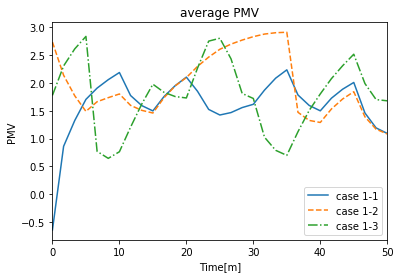

In [20]:
plt.plot(time_list, pmv_a, label='case 1-1',linestyle='solid')
plt.plot(time_list, pmv_b, label='case 1-2',linestyle='dashed')
plt.plot(time_list, pmv_c, label='case 1-3',linestyle='dashdot')
plt.xlabel("Time[m]")
plt.ylabel("PMV")
plt.title('average PMV')
plt.xlim(0,50)
#plt.ylim(-0.5,2.8)
plt.legend()
plt.savefig("PMV_123.png",dpi=150)

In [26]:
T_a,U_a,MRT_a = a.getTUList(0,3010,100)
T_b,U_b,MRT_b = b.getTUList(0,3010,100)
T_c,U_c,MRT_c = c.getTUList(0,3010,100)

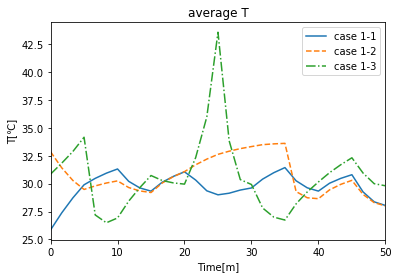

In [27]:
plt.plot(time_list, T_a, label='case 1-1',linestyle='solid')
plt.plot(time_list, T_b, label='case 1-2',linestyle='dashed')
plt.plot(time_list, T_c, label='case 1-3',linestyle='dashdot')
plt.xlabel("Time[m]")
plt.ylabel("T[℃]")
plt.title('average T')
plt.xlim(0,50)
#plt.ylim(-0.5,2.8)
plt.legend()
plt.savefig("T_123.png",dpi=150)

In [21]:
CASE5 = SolutionDirectory("../aircond5_play5/Case/case5")
CASE6 = SolutionDirectory("../aircond5_play5/Case/case6")
CASE7 = SolutionDirectory("../aircond5_play5/Case/case7")

In [22]:
d = Aircond(CASE5)
e = Aircond(CASE6)
f = Aircond(CASE7)

In [23]:
d.makePMVList(0,3010,100)
e.makePMVList(0,3010,100)
f.makePMVList(0,3010,100)

In [24]:
pmv_d,ppd_d=d.getPMVList(0,3010,100)
pmv_e,ppd_e=e.getPMVList(0,3010,100)
pmv_f,ppd_f=f.getPMVList(0,3010,100)

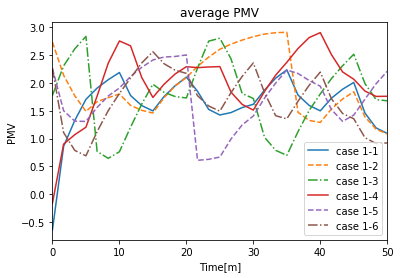

In [25]:
plt.plot(time_list, pmv_a, label='case 1-1',linestyle='solid')
plt.plot(time_list, pmv_b, label='case 1-2',linestyle='dashed')
plt.plot(time_list, pmv_c, label='case 1-3',linestyle='dashdot')
plt.plot(time_list, pmv_d, label='case 1-4',linestyle='solid')
plt.plot(time_list, pmv_e, label='case 1-5',linestyle='dashed')
plt.plot(time_list, pmv_f, label='case 1-6',linestyle='dashdot')
plt.xlabel("Time[m]")
plt.ylabel("PMV")
plt.title('average PMV')
plt.xlim(0,50)
#plt.ylim(-0.5,2.8)
plt.legend()
plt.savefig("PMV_567.png",dpi=150)

# 実行する

In [42]:
# エージェントが持つ頭脳となるクラスを定義、全エージェントで共有する


class Brain(object):
    def __init__(self, actor_critic,filename='weight_end.pth'):

        self.actor_critic = actor_critic  # actor_criticはクラスNetのディープ・ニューラルネットワーク

        # 結合パラメータをロードする場合
        #filename = 'weight_end.pth'
        #filename = 'weight_112500.pth'
        param = torch.load(filename, map_location='cpu')
        self.actor_critic.load_state_dict(param)

        # パラメータ更新の勾配法の設定
        self.optimizer = optim.RMSprop(
            actor_critic.parameters(), lr=lr, eps=eps, alpha=alpha)

    def update(self, rollouts):
        '''advanced計算した5つのstepの全てを使って更新します'''
        obs_shape = rollouts.observations.size()[2:]  # torch.Size([4, 84, 84])
        num_steps = NUM_ADVANCED_STEP
        num_processes = NUM_PROCESSES

        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1))

        # 注意：各変数のサイズ
        # rollouts.observations[:-1].view(-1, *obs_shape) torch.Size([80, 4, 84, 84])
        # rollouts.actions.view(-1, 1) torch.Size([80, 1])
        # values torch.Size([80, 1])
        # action_log_probs torch.Size([80, 1])
        # dist_entropy torch.Size([])

        values = values.view(num_steps, num_processes,
                             1)  # torch.Size([5, 16, 1])
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values  # torch.Size([5, 16, 1])
        value_loss = advantages.pow(2).mean()

        action_gain = (advantages.detach() * action_log_probs).mean()
        # detachしてadvantagesを定数として扱う

        total_loss = (value_loss * value_loss_coef -
                      action_gain - dist_entropy * entropy_coef)

        self.optimizer.zero_grad()  # 勾配をリセット
        total_loss.backward()  # バックプロパゲーションを計算
        nn.utils.clip_grad_norm_(self.actor_critic.parameters(), max_grad_norm)
        #  一気に結合パラメータが変化しすぎないように、勾配の大きさは最大0.5までにする

        self.optimizer.step()  # 結合パラメータを更新


In [18]:
# 実行用の関数

NUM_PROCESSES = 1

# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
Env_play = makecase(NUM_PROCESSES, casename='play',stride=STRIDE, end=END,
                xCells=XCELLS, insert_list = INSERT_LIST)

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Env_play[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain_play(actor_critic)

# 格納用変数の生成
obs_shape = Env_play[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Env_play)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

frames = []
main_end = False
# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    if main_end:
        break
        
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done, runOK = steps(Env_play, cpu_actions)
        
        frames.append(obs)
        
        if done or not runOK:
            main_end = True
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    


  0%|          | 1/1666666 [03:13<89688:40:53, 193.73s/it]

In [125]:
## この環境の部分を変える

class Aircond:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=500,end=3000,xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5])
        self.action_DIRECTION = np.array([-1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([18+273.15,22+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = end
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得
        各U1, U2, Tがすべて一列で並んだ状態を返す'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir,celsius=True):
        '''observationを２次元で取得。
        障害物があるところは全て値を0で埋める。
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        # セルシウス℃に直す
        if celsius:
            T_value = self.Celsius_(T_value)
            T_value = T_value.astype(np.float64)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        """PMVとPPDを計算
        デフォルト値。TA,VA,TR,RHまでは入力を推奨
        TA = 20  #  温度[℃]
        VA = 0.3  # 流速[m/s]
        TR = 20  # MRT[℃]
        RH = 50  # 相対湿度[%]
        AL = 1  # 活動量[met]
        CLO = 1 # 着衣量[clo]
        
        """
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        #
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''np.arrayの配列をセルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed,RH=50,AL=1,CLO=1):
        '''PMVを一つのtime_stepで全点計算
        TU_Parsed : TとUのParsedParameterFileをリストにしたもの
        全ての点のPMVとPPVの値を返す
        time=0でも、すべてのセルの値を返す。'''
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius_(T)
            MRTc = self.Celsius_(MRT)
            pmv,ppd = self.calc_PMV(TA=Tc,VA=Us,TR=MRTc,RH=RH,AL=AL,CLO=CLO)
            PMV = np.tile(pmv, self.nCells)
            PPD = np.tile(ppd, self.nCells)
        else:   
            # Uを速さに変換
            Us = self.UScalar(U)
            MRT = self.calc_MRT(T_Parsed)
            # TとMRTをセルシウス温度に変換
            Tc = list(self.Celsius_(T))
            MRTc = self.Celsius_(MRT)
            
            length = len(T)
            # ループを早くするため、外に出す。
            PMV = []
            PPD = []
            PMVappend = PMV.append
            PPDappend = PPD.append
            for i in range(length):
                pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=RH,AL=AL,CLO=CLO)
                PMVappend(pmv)
                PPDappend(ppd)
            PMV = np.array(PMV)
            PPD = np.array(PPD)
        return [PMV,PPD]
    
    def calc_PMV_error(self, TU_Parsed,RH=50,AL=1,CLO=1):
        """PMVの全点の2条誤差の合計を計算
        入力はcalc_PMV_allと同じ。返すものだけが違う。
        PMVは、0との2乗誤差、PPDは0との、根平均2乗誤差を返す。
        """
        PMV, PPD = self.calc_PMV_all(TU_Parsed, RH=RH,AL=AL,CLO=CLO)
        PMV_mae = ((PMV - 0)**2).mean()
        PPD_rmse = np.sqrt( ((PPD - 0)**2).mean())
        return PMV_mae, PPD_rmse
    
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
            
    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]
        
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        
        
    def reset(self):
        '''環境のリセット'''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム）
        T_initial = ParsedParameterFile(self.CASE.initialDir() + '/T')
        # random parameter from 26 to 35
        T_rand = np.random.randint(26+273,35+273)
        T_initial['internalField'].setUniform(T_rand)
        T_initial.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        return self.observation
    
    def step_old(self, action):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
    
    
    def step(self, action, reward='PMV'):
        '''ステップを進める
        報酬はPMV等から選択
        '''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
            # rewardと、observationは1ステップ前の値をそのまま使う。
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
            # 報酬の計算。make_observationでは、0を補完していれているため、用いない。
            T_new = ParsedParameterFile(self.CASE.latestDir() + '/T')
            U_new = ParsedParameterFile(self.CASE.latestDir() + '/U')
            TU_Parsed = [T_new,U_new]
            PMV_mae, PPD_rmse = self.calc_PMV_error(TU_Parsed, RH=50,AL=1,CLO=1)
            # 報酬は、ズレ分をマイナス、ちかづいたら、プラスにする。
            self.reward = -PMV_mae + 1
            
        
        return (self.observation, self.reward, done, runOK)
        

In [126]:
# aircondを並列でたくさんつくるためのクラス

# ケースの作成
def makecase(NUM_PROCESSES,stride=500, end=3000, xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
    """並列でたくさんのケースをつくる"""
    os.system("./makecase {}".format(NUM_PROCESSES))
    Envs = []
    Envs_append = Envs.append
    for i in range(NUM_PROCESSES):
        CASE = SolutionDirectory("./Case/case{}".format(i))
        aircond = Aircond(CASE, stride=stride, end=end, xCells=xCells, insert_list=insert_list)
        Envs_append(aircond)
    return Envs

In [128]:
# 定数の設定

#ENV_NAME = 'BreakoutNoFrameskip-v4' 
# Breakout-v0ではなく、BreakoutNoFrameskip-v4を使用
# v0はフレームが自動的に2-4のランダムにskipされますが、今回はフレームスキップはさせないバージョンを使用
# 参考URL https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L371
    
NUM_SKIP_FRAME = 4 # skipするframe数です
NUM_STACK_FRAME = 1  # 状態として連続的に保持するframe数です
NOOP_MAX = 30  #  reset時に何もしないフレームを挟む（No-operation）フレーム数の乱数上限です
NUM_PROCESSES = 2 #  並列して同時実行するプロセス数です
NUM_ADVANCED_STEP = 5  # 何ステップ進めて報酬和を計算するのか設定
GAMMA = 0.99  # 時間割引率

TOTAL_FRAMES=10e6  #  学習に使用する総フレーム数
NUM_UPDATES = int(TOTAL_FRAMES / NUM_ADVANCED_STEP / NUM_PROCESSES)  # ネットワークの総更新回数
# NUM_UPDATESは125,000となる


In [129]:
NUM_UPDATES = 10

In [130]:
# A2Cの損失関数の計算のための定数設定
value_loss_coef = 0.5
entropy_coef = 0.01
max_grad_norm = 0.5

# 学習手法RMSpropの設定
lr = 7e-4
eps = 1e-5
alpha = 0.99


In [131]:
# GPUの使用の設定
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cpu


In [132]:
# A2Cのディープ・ニューラルネットワークの構築


def init(module, gain):
    '''層の結合パラメータを初期化する関数を定義'''
    nn.init.orthogonal_(module.weight.data, gain=gain)
    nn.init.constant_(module.bias.data, 0)
    return module


class Flatten(nn.Module):
    '''コンボリューション層の出力画像を1次元に変換する層を定義'''

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self, n_out):
        super(Net, self).__init__()

        # 結合パラメータの初期化関数
        def init_(module): return init(
            module, gain=nn.init.calculate_gain('relu'))

        # コンボリューション層の定義
        self.conv = nn.Sequential(
            # 画像サイズの変化12*40→4*18
            init_(nn.Conv2d(3, 32, kernel_size=5,stride=2)),
            # stackするflameは4画像なのでinput=NUM_STACK_FRAME=4である、出力は32とする、
            # sizeの計算  size = (Input_size - Kernel_size + 2*Padding_size)/ Stride_size + 1

            nn.ReLU(),
            # 画像サイズの変化4*18→3*17
            init_(nn.Conv2d(32, 64, kernel_size=2, stride=1)),
            nn.ReLU(),
            init_(nn.Conv2d(64, 64, kernel_size=2, stride=1)),  # 画像サイズの変化3*17→2*16
            nn.ReLU(),
            Flatten(),  # 画像形式を1次元に変換
            init_(nn.Linear(64 * 2 * 16, 512)),  # 64枚の7×7の画像を、512次元のoutputへ
            nn.ReLU()
        )

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=1.0)

        # Criticの定義
        self.critic = init_(nn.Linear(512, 1))  # 状態価値なので出力は1つ

        # 結合パラメータの初期化関数
        def init_(module): return init(module, gain=0.01)

        # Actorの定義
        self.actor = init_(nn.Linear(512, n_out))  # 行動を決めるので出力は行動の種類数

        # ネットワークを訓練モードに設定
        self.train()

    def forward(self, x):
        '''ネットワークのフォワード計算を定義します'''
        #input = x / 255.0  # 画像のピクセル値0-255を0-1に正規化する
        input = x  # 正規化はしない
        conv_output = self.conv(input)  # Convolution層の計算
        critic_output = self.critic(conv_output)  # 状態価値の計算
        actor_output = self.actor(conv_output)  # 行動の計算

        return critic_output, actor_output

    def act(self, x):
        '''状態xから行動を確率的に求めます'''
        value, actor_output = self(x)
        probs = F.softmax(actor_output, dim=1)    # dim=1で行動の種類方向に計算
        action = probs.multinomial(num_samples=1)

        return action

    def get_value(self, x):
        '''状態xから状態価値を求めます'''
        value, actor_output = self(x)

        return value

    def evaluate_actions(self, x, actions):
        '''状態xから状態価値、実際の行動actionsのlog確率とエントロピーを求めます'''
        value, actor_output = self(x)

        log_probs = F.log_softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        action_log_probs = log_probs.gather(1, actions)  # 実際の行動のlog_probsを求める

        probs = F.softmax(actor_output, dim=1)  # dim=1で行動の種類方向に計算
        dist_entropy = -(log_probs * probs).sum(-1).mean()

        return value, action_log_probs, dist_entropy


In [63]:
def resets(Envs):
    """resets all"""
    obs = []
    obs_append = obs.append
    for i in range(len(Envs)):
        obs_ = Envs[i].reset()
        obs_append(obs_)
    obs = np.array(obs)
    return obs

In [64]:
def steps(Envs, action):
    """すべての環境で同じだけステップを進める
    obsはnumpy, done, runOKはリスト
    """
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(len(Envs)):
        obs_, reward_, done_, runOK_ = Envs[i].step(action[i])
        obs_append(obs_)
        reward_append(reward_)
        done_append(done_)
        runOK_append(runOK_)
    obs = np.array(obs)
    return obs, reward, done, runOK
    

In [65]:
def make_random_actions(Envs, max_execution=3):
    """適当にステップを進めて、環境をバラバラにする。
    環境のリスト
    max_execution : 進める最大のステップ。0~ステップ分進めることになる。
    random_actionは複素数で返す。0+1Jは補完したもの。
    """
    # 0~max_executions
    # 複素数にして、1jは補完したものとする。
    action_shape = Envs[0].action_space.shape[0]
    random_actions = []
    for i in range(len(Envs)):
        i_th_action = []
        for j in range(random.randint(0,max_execution)):
            i_th_action.append(random.randint(0, action_shape-1))
        random_actions.append(i_th_action)
        
    max_len = max(map(len, random_actions))
    random_actions = np.array(list(map(lambda x:x + [1j]*(max_len-len(x)), random_actions)))
    random_actions = random_actions.astype(np.complex128)
    return random_actions

In [66]:
def random_steps(Envs, random_actions, step_reset=True):
    """random_actions分それぞれステップを進める。
    Envs : 環境のリスト
    random_actions, len(Envs)行,進めるステップ分で構成された、random_step。
    step_reset : Envs内のpresent_timeをリセットするかどうか。
    """
    # random_step分stepを進めて、とりあえず、リストとして保存。
    obs_list = []
    reward_list = []
    done_list = []
    runOK_list = []
    obs_list_append = obs_list.append
    reward_list_append = reward_list.append
    done_list_append = done_list.append
    runOK_list_append = runOK_list.append
    # random_actions.shape[0] == len(Envs)だが、やりたくない環境がある場合
    # やらないために、len(Envs)は使わない
    for i in range(random_actions.shape[0]):
        obs_progress = []
        reward_progress = []
        done_progress = []
        runOK_progress = []
        obs_progress_append = obs_progress.append
        reward_progress_append = reward_progress.append
        done_progress_append = done_progress.append
        runOK_progress_append = runOK_progress.append
        
        for j in range(random_actions.shape[1]):
            if random_actions[i,j].imag==0:  # 補完しただけのものには1jが入ってる
                obs_, done_, reward_, runOK_ = Envs[i].step(int(random_actions[i,j].real))
                obs_progress_append(obs_)
                reward_progress_append(reward_)
            else:
                done_, runOK_ = False, True
            done_progress_append(done_)
            runOK_progress_append(runOK_)
            
        obs_list_append(obs_progress)
        reward_list_append(reward_progress)
        done_list_append(done_progress)
        runOK_list_append(runOK_progress)
    
    # 進めた結果をまとめる。
    # obs → 最後のステップのobservation or 進めない場合、そのままのobservation
    # reward → 最後のステップのreward or 進めない場合、そのままのreward
    # done → 一個でもdoneがあれば、done=Trueとする。
    # runOK → 一個でも、Falseがあれば、Falseとする。
    obs = []
    reward = []
    done = []
    runOK = []
    obs_append = obs.append
    reward_append = reward.append
    done_append = done.append
    runOK_append = runOK.append
    for i in range(random_actions.shape[0]):
        if obs_list[i]==[]:
            obs_ = Envs[i].observation
        else:
            obs_ = obs_list[i][-1]
        obs_append(obs_)
        
        if reward_list[i]==[]:
            reward_ = Envs[i].reward
        else:
            reward_ = reward_list[i][-1]
        reward_append(reward_)
        
        if any(done_list[i]):
            done_ = True
        else:
            done_ = False
        done_append(done_)
        
        if all(runOK_list[i]):
            runOK_ = True
        else:
            runOK_ = False
        runOK_append(runOK_)
    obs = np.array(obs)
    
    if step_reset:
        for i in range(random_actions.shape[0]):
            Envs[i].present_time=0
            
    return obs, reward, done, runOK

In [124]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done,runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 12500 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


 10%|█         | 1/10 [04:58<44:42, 298.07s/it]

finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


 40%|████      | 4/10 [19:13<28:46, 287.79s/it]

 Interrupted by the Keyboard
Killing PID 10182
 Interrupted by the Keyboard
Killing PID 10199


 50%|█████     | 5/10 [22:59<22:27, 269.43s/it]

 Interrupted by the Keyboard
Killing PID 10252


100%|██████████| 10/10 [23:04<00:00, 138.50s/it]


In [110]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)


tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[25.8500, 25.8500, 25.8500,  ..., 25.8500, 25.8500, 25.8500],
          [25.8500, 25.8500, 2

In [121]:

# 実行ループ
#for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    #for step in range(NUM_ADVANCED_STEP):


j=0
step=0

# 行動を求める
with torch.no_grad():
    action = actor_critic.act(rollouts.observations[step])

cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

# 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
obs, reward, done,runOK = steps(Envs, cpu_actions)

# 報酬をtensorに変換し、試行の総報酬に足す
# sizeが(16,)になっているのを(16, 1)に変換
reward = np.expand_dims(np.stack(reward), 1)
reward = torch.from_numpy(reward).float()
episode_rewards += reward

# 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
masks = torch.FloatTensor(
    [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
# 最後の試行の総報酬を更新する
final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
# 継続中は0を足す、done時にはepisode_rewardsを足す
final_rewards += (1 - masks) * episode_rewards


# 試行の総報酬を更新する
episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

# masksをGPUへ
masks = masks.to(device)

# 現在の状態をdone時には全部0にする
# maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
current_obs *= masks.unsqueeze(2).unsqueeze(2)

# frameをstackする
# torch.Size([16, 1, 40, 12])
obs = torch.from_numpy(obs).float()
current_obs = obs.to(device)  # 最新のobsを格納

# メモリオブジェクトに今stepのtransitionを挿入
rollouts.insert(current_obs, action.data, reward, masks)

# ------------------

# advancedのfor loop終了

# advancedした最終stepの状態から予想する状態価値を計算
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.observations[-1]).detach()
    
    
# 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
rollouts.compute_returns(next_value)


# ネットワークとrolloutの更新
global_brain.update(rollouts)
rollouts.after_update()

# ログ：途中経過の出力
if j % 100 == 0:
    print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
          format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                 final_rewards.mean(),
                 final_rewards.median(),
                 final_rewards.min(),
                 final_rewards.max()))

# 結合パラメータの保存
if j % 12500 == 0:
    torch.save(global_brain.actor_critic.state_dict(),
               'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

 Interrupted by the Keyboard
Killing PID 8741
finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0


In [47]:
# 微妙。とりあえずは使わない方向。
class SubprocAircond():
    def __init__(self, envs):
        # 今回は並列は考えない。
        # いつか考えようかと思うけど、流体の方にGPU使えばいいかなー。
        self.envs = envs
        self.observation_space = envs[0].observation_space
        self.action_space = envs[0].action_space

    def reset(self):
        Obs = []
        Obs_append = Obs.append
        for env in self.envs:
            obs = env.reset()
            Obs_append(obs)
        return Obs
    
    def step(self, actions):
        Obs, Done, RunOK = [], [], []
        Obs_append = Obs.append
        Done_append = Done.append
        RunOK_append = RunOK.append
        for env, action in zip(self.envs, actions):
            obs, done, runOK = env.step(action)
            Obs_append(obs)
            Done_append(done)
            RunOK_append(runOK)
        return Obs, Done, RunOK

In [44]:
## この環境の部分を変える

class Aircond_old:
    '''Aircondのクラス'''
    def __init__(self, CASE, stride=500, xCells=40,
                         insert_list = [15,15,15,15,33,33,33,51,69,69,69,87,105,105,105,142,142,142,342,342,380,380]):
        self.CASE = CASE
        # メッシュを作らないとpolymeshがないので。
        os.system(CASE.name + '/Makemesh')
        # get nCells
        with open (self.CASE.name + '/constant/polyMesh/neighbour') as f:
            neighbour = f.read()
        nCells_index = neighbour.find('nCells')
        nCells_ = neighbour[nCells_index : nCells_index+15]
        nCells = int(re.sub(r'\D', '', nCells_))
        self.nCells = nCells
        
        self.action_SPEED = np.array([0.1,0.3,0.5])
        self.action_DIRECTION = np.array([-1*np.pi/8, -2*np.pi/8,-3*np.pi/8])
        self.action_TEMPERTURE = np.array([18+273.15,22+273.15,26+273.15])
        self.action_space = np.tile(np.array([0,0,0]),(27,1))
        self.observation_space_ = np.tile(np.array([0,0,0]),(self.nCells,1))
        #self.observation_space = np.tile(np.array([0]), (self.nCells*3,1)
        
        self.xCells = xCells
        self.insert_list = insert_list
        observation_space = np.tile(np.array([0,0,0]), (self.nCells+len(self.insert_list),1))
        U_space_x = observation_space[:,0].reshape(self.xCells,-1)
        U_space_y = observation_space[:,1].reshape(self.xCells,-1)
        T_space = observation_space[:,2].reshape(self.xCells,-1)
        self.observation_space = np.array([U_space_x, U_space_y, T_space]) 
        
        self.stride = stride  # 進めるステップの幅
        # stepが始まってからのtime。始まる前にstepを進めた場合は含まれず0
        self.present_time = 0  
        # openFoam側のcontrolDictに記載されているtime
        self.startTime = 0
        self.endTime = copy(self.stride)
        # いつ終了するか
        self.end = 3000
        
        # 各辞書ファイルの取得
        self.initialDir = self.CASE.initialDir()+'/'
        self.constant = self.CASE.name + "/constant/"
        self.system = self.CASE.name + "/system/"
        self.initialDir_file = []
        for x in os.listdir(self.initialDir):
            if os.path.isfile(self.initialDir + x):
                self.initialDir_file.append(x)
        self.constant_file = []
        for y in os.listdir(self.constant):
            if os.path.isfile(self.constant + y):
                self.constant_file.append(y)
        self.system_file = []
        for z in os.listdir(self.system):
            if os.path.isfile(self.system + z):
                self.system_file.append(z)
        
        # 各辞書ファイルをそれぞれのファイル名で保存
        for i in range(len(self.initialDir_file)):
            self.__dict__[self.initialDir_file[i]] = ParsedParameterFile(self.initialDir + self.initialDir_file[i])

        for i in range(len(self.system_file)):
            self.__dict__[self.system_file[i]] = ParsedParameterFile(self.system + self.system_file[i])
            
    def initial_to_float(self, numpy_Parsed_value):
        '''uniformをnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            #Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed_int
    
    def initial_to_array(self, numpy_Parsed_value):
        '''uniformをnCellの数だけnp.arrayに変換'''
        numpy_Parsed_value = np.array(numpy_Parsed_value)
        if numpy_Parsed_value.ndim==0:
            Parsed_raw = str(numpy_Parsed_value.all())
            Parsed_str = Parsed_raw[8:].strip('()').split(' ')
            Parsed_int = np.array(list(map(float,Parsed_str)))
            Parsed = np.tile(Parsed_int,(self.nCells,1))
        return Parsed

    def make_observation_old(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        Observation = np.concatenate([U_value_xy, T_value_x],axis=1)
        return Observation    
    
    def make_observation_onerow(self,Dir):
        '''Dirのpathのobservationを取得'''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = T_value.reshape(-1, 1)
        U_value_x = U_value[:,0].reshape(-1, 1)
        U_value_y = U_value[:,1].reshape(-1, 1)
        observation = np.concatenate([U_value_x, U_value_y, T_value_x], axis=0)
        return observation
    
    def make_observation(self,Dir):
        '''observationを２次元で取得
        self.xCells : x方向のセル数
        self.insert_list : 障害物があり、値を0で埋めるべき場所
        '''
        U_value = np.array(ParsedParameterFile(Dir + '/U').content['internalField'])
        T_value = np.array(ParsedParameterFile(Dir + '/T').content['internalField'])
        if U_value.ndim == 0:
            U_value = self.initial_to_array(U_value)
            T_value = self.initial_to_array(T_value)
        #U_value_xy = np.delete(U_value, axis=1, obj=2)
        U_value_xy = np.delete(U_value, axis=1, obj=2)
        T_value_x = np.reshape(T_value, [-1,1], order='F')
        observation_ = np.concatenate([U_value_xy, T_value_x],axis=1)  # 3 axis observation
        observation_ = np.insert(observation_, self.insert_list, [0,0,0], axis=0)
        U_value_x = observation_[:,0].reshape(self.xCells,-1)
        U_value_y = observation_[:,1].reshape(self.xCells,-1)
        T_value = observation_[:,2].reshape(self.xCells,-1)
        observation = np.array([U_value_x, U_value_y, T_value])
        return observation
    
    def make_action(self):
        '''actionの設定'''
        Action = np.empty((0,3),float)
        for i in range(len(self.action_SPEED)):
            for j in range(len(self.action_DIRECTION)):
                for k in range(len(self.action_TEMPERTURE)):
                    Ux = self.action_SPEED[i]*np.cos(self.action_DIRECTION[j])
                    Uy = self.action_SPEED[i]*np.sin(self.action_DIRECTION[j])
                    Act = np.array([[Ux,Uy,self.action_TEMPERTURE[k]]])
                    Action = np.append(Action,Act,axis=0)
                    
        return Action
    
    def getParsed(self,time_step):
        '''各time_stepのParsedParameterFileを取得'''
        T = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/T')
        U = ParsedParameterFile(self.CASE.name + '/' + str(time_step) + '/U')
        TU_list = [T,U]
        return TU_list
    
    
    def getParsedList(self,first_step, last_step, write_step,):
        '''各time_stepのParsedParameterFileを取得'''
        TU_list = []
        for stp in range(first_step, last_step, write_step):
            T = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/T')
            U = ParsedParameterFile(self.CASE.name + '/' + str(stp) + '/U')
            TU_list.append([T,U])
        return TU_list
    
    # 後にcythonで書き直す予定
    def calc_PMV(self, TA=20,VA=0.3,TR=20,RH=50,AL=1,CLO=1):
        '''PMVとPPDを計算'''
        #AL = 1  # 活動量[met]
        #CLO = 1 # 着衣量[clo]
        #TA = 20  #  温度[℃]
        #TR = 20  # MRT[℃]
        #VA = 0.3  # 流速[m/s]
        #RH = 50  # 相対湿度[%]
        #
        #***************************************************
        # 外部仕事 W＝0 [W/㎡]とする。
        #***************************************************
        # PMV 計算準備
        #
        M = AL * 58.15
        LCL = CLO
        W = 0
        #PA = (RH / 100 * np.exp(18.6686 - 4030.18 / (TA + 235))) / 0.00750062
        PPK = 673.4 - 1.8 * TA
        PPA = 3.2437814 + 0.00326014 * PPK + 2.00658 * 1E-9 * PPK * PPK * PPK
        PPB = (1165.09 - PPK) * (1 + 0.00121547 * PPK)
        PA = RH / 100 * 22105.8416 / np.exp(2.302585 * PPK * PPA / PPB) * 1000
        EPS = 1E-5
        MW = M - W
        # FCL＝着衣表面積／裸体表面積の比
        if LCL > 0.5:
            FCL = 1.05 + 0.1 * LCL
        else:
            FCL = 1 + 0.2 * LCL
        # 衣服表面温度TCLの初期値設定
        TCL = TA
        TCLA = TCL
        NOI = 1
        # 着衣表面温度の計算
        while True:
            TCLA = 0.8 * TCLA + 0.2 * TCL
            HC = 12.1 * np.sqrt(VA)
            if 2.38 * np.sqrt(np.sqrt(abs(TCL - TA))) > HC:
                HC = 2.38 * np.sqrt(np.sqrt(abs(TCL - TA)))
            TCL = 35.7 - 0.028 * MW - 0.155 * LCL * (3.96 * 1E-8 * FCL * ((TCLA + 273) ** 4 - (TR + 273) ** 4) + FCL * HC * (TCLA - TA))
            NOI = NOI + 1
            if NOI > 150:
                #PMV = 999990.999
                PMB = 3.0
                PPD = 100
                return (PMV,PPD)
            if not abs(TCLA - TCL) > EPS:
                break
        #PMVの計算
        PM1 = 3.96 * 1E-8 * FCL * ((TCL + 273) ** 4 - (TA + 273) ** 4)
        PM2 = FCL * HC * (TCL - TA)
        PM3 = 0.303 * np.exp(-0.036 * M) + 0.028
        if MW > 58.15:
            PM4 = 0.42 * (MW - 58.15)
        else:
            PM4 = 0
        PMV = PM3 * (MW - 3.05 * 0.001 * (5733 - 6.99 * MW - PA) - PM4 - 1.7 * 1E-5 * M * (5867 - PA) - 0.0014 * M * (34 - TA) - PM1 - PM2)
            #PRINT PMV
        if abs(PMV) > 3:
            #PMV = 999990.999
            PMV = 3.0
            PPD = 100
            return (PMV,PPD)
        
        PPD = 100 - 95 * np.exp(-0.0335 * PMV ** 4 - 0.2179 * PMV ** 2)
        
        return (PMV,PPD)
    
    def calc_MRT(self, T_Parsed):
        '''MRTを計算'''
        
        T_wall_list = np.array([])
        if np.array(T_Parsed['internalField']).ndim==0:  # time_step=0
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty' or \
                    T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    T_wall = np.array([])
                else:
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                T_wall_list = np.append(T_wall_list, T_wall)
                
        else:
            for boundary in list(T_Parsed['boundaryField']):
                if T_Parsed['boundaryField'][boundary]['type']=='fixedValue':
                    numpy_Parsed_value = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    T_wall = self.initial_to_float(numpy_Parsed_value)
                elif T_Parsed['boundaryField'][boundary]['type']=='zeroGradient' or \
                T_Parsed['boundaryField'][boundary]['type']=='empty':
                    T_wall = np.array([])
                else:
                    T_wall = np.array(T_Parsed['boundaryField'][boundary]['value'])
                    if T_wall.ndim==0:
                        T_wall = self.initial_to_float(T_wall)
                T_wall_list = np.append(T_wall_list, T_wall)
        return np.average(T_wall_list)
    
    def Celsius(self, T):
        CelsiusT = T - 273.15
        return CelsiusT
    
    def Celsius_(self, T):
        '''セルシウス℃に変換'''
        if np.array(T).size==1:
            return self.Celsius(T)
        else:
            Celsiuss = np.frompyfunc(self.Celsius,1,1)  # リストに適用可にする
            return Celsiuss(T)
        
    def UScalar(self, U):
        '''Uをスカラーに変換'''
        if np.array(U).size<=3:
            return np.array([np.sqrt(U[0]**2 + U[1]**2)])
        else:
            return np.sqrt(U[:,0]**2 + U[:,1]**2)
        
    def calc_PMV_all(self, TU_Parsed):
        '''PMVを一つのtime_stepで全点計算'''
        
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        # 一つの値に変換する
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        # Uを速さに変換
        Us = self.UScalar(U)
        MRT = self.calc_MRT(T_Parsed)
        # TとMRTをセルシウス温度に変換
        Tc = list(self.Celsius_(T))
        MRTc = self.Celsius_(MRT)

        length = len(T)
        # ループを早くするため、外に出す。
        PMV = []
        PPD = []
        PMVappend = PMV.append
        PPDappend = PPD.append
        for i in range(length):
            pmv,ppd = self.calc_PMV(TA=Tc[i],VA=Us[i],TR=MRTc,RH=50,AL=1,CLO=1)
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV,PPD]
    
    def header(self, time_step, filename):
        '''headerファイルを作成'''
        header = """/*--------------------------------*- C++ -*----------------------------------*\
=========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  6
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       volScalarField;
    location    "{}";
    object      {};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
""".format(time_step, filename)
        return header
    
    def internal(self, list_internal):
        '''internalFieldの値の作成'''
        if len(list_internal)==1:
            internal = """
internalField   uniform {};""".format(list_internal[0])
        else:
            str_= np.frompyfunc(str,1,1)
            str_internal = '\n'.join(str_(list_internal))
            internal = """
internalField   nonuniform List<scalar> 
{}
(
{}
)
;
""".format(self.nCells, str_internal)
        return internal
    
    def makePMVFile(self,time_step):
        '''PMVとPPDファイルを書き込む'''
        
        path_pmv = self.CASE.name + '/' + str(time_step) + '/PMV' # 書き込むパス
        path_ppd = self.CASE.name + '/' + str(time_step) + '/PPD'
        
        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        # header, dimensions, internal, boundaryの順に書き込む
        f = open(path_pmv, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        g = open(path_ppd, 'w')
        f.write(self.header(time_step,"PMV")) # headerを記載する
        g.write(self.header(time_step,"PPD"))
        f.write(demensions) # dimensionsを記載する
        g.write(demensions)
        # internalFieldの計算
        TU_Parsed = self.getParsed(time_step)
        PMV,PPD = self.calc_PMV_all(TU_Parsed)
        internal_PMV = self.internal(PMV)
        internal_PPD = self.internal(PPD)
        f.write(internal_PMV)  
        g.write(internal_PPD)
        f.write(boundary)
        g.write(boundary)
        f.close() 
        g.close()

        
    def makePMVList(self,first_step, last_step, write_step):
        '''任意の範囲でPMVファイルを作成'''
        for stp in range(first_step, last_step, write_step):
            self.makePMVFile(stp)
            
        
    def meshNumberFile(self,time_step):
        '''メッシュの並びを確認する'''
        path_mesh = self.CASE.name + '/' + str(time_step) + '/Meshnumber' # 書き込むパス


        demensions = """
dimensions      [0 0 0 0 0 0 0];
"""
        boundary = """
boundaryField
{
    ".*"
    {
        type            zeroGradient;
    }
}


// ************************************************************************* //
"""
        f = open(path_mesh, 'w') # ファイルを開く(該当ファイルがなければ新規作成)
        f.write(self.header(time_step,"PMV")) # headerを記載する
        f.write(demensions) # dimensionsを記載する
        mesh_list = [x for x in range(1,self.nCells+1)]
        internal_mesh = self.internal(mesh_list)
        f.write(internal_mesh)  
        f.write(boundary)
        f.close() 
            
    def calc_ADPI(self,TU_Parsed,occupied_zone_cell):
        '''ADPIを計算する'''
        
        # occupied_zone_cellはaircond5の場合は1~340までのセルが居住域
        T_Parsed,U_Parsed = TU_Parsed
        T = np.array(T_Parsed['internalField'])
        U = np.array(U_Parsed['internalField'])
        # time_step==0の場合
        if T.ndim==0 or U.ndim==0:
            T = self.initial_to_float(T)
            U = self.initial_to_float(U)
        
        Tc = np.average(T)  # 室内の平均温度
        Us = self.UScalar(U)  # 流速
        theta = (T - Tc) - 8.0*(Us - 0.15)  # 有効ドラフト温度
        
        satisfy_theta = np.where((theta > -1.5) & (theta < 1), 1, 0)
        satisfy_Us = np.where(Us < 0.35,1, 0)  # 条件を満たすものを1,満たさないものを0
        satisfy_all = satisfy_theta + satisfy_Us
        satisfy = satisfy_all[:occupied_zone_cell]
        nCells = satisfy.size
        num_satisfy = np.sum(satisfy == 2)
        ADPI = num_satisfy/nCells*100
        
        return (ADPI, theta)
    
    def calc_EUC(self,T_Parsed, occupied_zone_cell,last_cell):
        '''EUCを計算する'''
        
        T = np.array(T_Parsed['internalField'])
        T0 = self.initial_to_float(T_Parsed['boundaryField']['inlet']['value'])[0] # 給気温度

        if T.ndim==0:
            T = self.initial_to_float(T)[0]
            Toz = T
            Tiz = T
        else:
            Toz = np.average(T[occupied_zone_cell:last_cell])  # 居住域外の平均温度  
            Tiz = np.average(T[:occupied_zone_cell])  # 居住域内の平均温度
        EUC = (Toz-T0) / (Tiz-T0) * 100
        return EUC
        
    def getPMVList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの平均値ファイルを取得'''
        
        # ループを早くするため、外に出す。
        PMV_list = []
        PPD_list = []
        PMVappend = PMV_list.append
        PPDappend = PPD_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            pmv = np.average(np.array(PMV))
            ppd = np.average(np.array(PPD))
            PMVappend(pmv)
            PPDappend(ppd)
        return [PMV_list, PPD_list]
    
    def getPMVerrorList(self, first_step, last_step, write_step):
        '''任意の範囲のPMVの空間平均2乗誤差を取得'''
        
        # 工事中
        PMV_list = []
        PMVappend = PMV_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            PMV,PPD = self.calc_PMV_all(TU_Parsed)
            
            pmv = np.average(np.array(PMV))
            PMVappend(pmv)
        return [PMV_list, PPD_list]
    
    def getADPIList(self, first_step, last_step, write_step,occupied_zone_cell=342):
        '''任意の範囲のADPIの値を取得'''
        
        ADPI_list = []
        ADPIappend = ADPI_list.append
        for stp in range(first_step, last_step, write_step):
            TU_Parsed = self.getParsed(stp)
            adpi,theta = self.calc_ADPI(TU_Parsed, occupied_zone_cell)
            ADPIappend(adpi)
        return ADPI_list
    
    def getEUCList(self, first_step, last_step, write_step,
                    occupied_zone_cell=342, last_cell=100000):
        '''任意の範囲のEUCの値を算出'''
        
        EUC_list = []
        EUCappend = EUC_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed,U_Parsed = self.getParsed(stp)
            euc = self.calc_EUC(T_Parsed, occupied_zone_cell, last_cell)
            EUCappend(euc)
        return EUC_list
    
    def getTUList(self, first_step, last_step, write_step):
        '''任意の範囲のTとUの平均値を取得'''
        
        T_list = []
        U_list = []
        MRT_list = []
        Tappend = T_list.append
        Uappend = U_list.append
        MRTappend = MRT_list.append
        for stp in range(first_step, last_step, write_step):
            T_Parsed, U_Parsed = self.getParsed(stp)
            T = np.array(T_Parsed['internalField'])
            U = np.array(U_Parsed['internalField'])
            # time_step==0の場合
            if T.ndim==0 or U.ndim==0:
                T = self.initial_to_float(T)
                U = self.initial_to_float(U)
            # Uを速さに変換
            T = np.average(T)
            Us = np.average(np.array(self.UScalar(U)))
            MRT = np.average(np.array(self.calc_MRT(T_Parsed)))
            # TとMRTをセルシウス温度に変換
            Tc = self.Celsius(T)
            MRTc = self.Celsius(MRT)
            Tappend(Tc)
            Uappend(Us)
            MRTappend(MRTc)
        return [T_list,U_list,MRT_list]
        
        
        
    def change_control(self,control):
        if control == 1:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 2:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.02
        if control == 3:
            self.blockMeshDict['blocks'][2] = Vector(20,10,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
        if control == 4:
            self.blockMeshDict['blocks'][2] = Vector(40,20,1)
            self.blockMeshDict.writeFile()
            self.controlDict['deltaT'] = 0.01
            
    def write_interval(self, writeInterval):
        self.controlDict['writeInterval'] = writeInterval
        
        
    def reset(self):
        '''環境のリセット'''
        
        # reset parameter
        self.present_time = 0  
        self.startTime = 0
        self.endTime = copy(self.stride)
        
        # reset control Dict
        clDict = ParsedParameterFile(self.CASE.controlDict())
        clDict['startTime'] = self.startTime
        clDict['endTime'] = self.endTime
        clDict.writeFile()
        #self.startTime = clDict['startTime']
        #self.endTime = clDict['endTime']
        
        #os.system('./Allclean')
        os.system(self.CASE.name + '/Makemesh')
        
        # 初期条件の設定（ランダム）
        T_initial = ParsedParameterFile(self.CASE.initialDir() + '/T')
        # random parameter from 26 to 35
        T_rand = np.random.randint(26+273,35+273)
        T_initial['internalField'].setUniform(T_rand)
        T_initial.writeFile()
        
        
        # set action and observation
        self.action_space= self.make_action()
        self.observation = self.make_observation(self.CASE.initialDir())
        return self.observation
    
    def step_old(self, action):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
    
    
    def step(self, action, reward='PMV'):
        '''ステップを進める'''
        #clDict = ParsedParameterFile(self.CASE.controlDict())      
        if self.present_time >= self.end:
            done = True
            runOK = 'end'
        else:
            done = False
            
            # actionに従った、境界条件を設定
            # action is 0~26
            U_latest = ParsedParameterFile(self.CASE.latestDir() + '/U')
            T_latest = ParsedParameterFile(self.CASE.latestDir() + '/T')
            self.act = self.action_space[action]
            U_latest['boundaryField']['inlet']['value'].setUniform(Vector(self.act[0],self.act[1],0))
            U_latest.writeFile()
            T_latest['boundaryField']['inlet']['value'].setUniform(self.act[2])
            T_latest.writeFile()
            
            # OpenFOAMのコマンドを実行
            args=shlex.split("buoyantPimpleFoam -case " + self.CASE.name)
            buoyant=BasicRunner(args,silent=True)
            self.summary=buoyant.start()
            runOK = buoyant.runOK()
            
            #os.system("buoyantBoussinesqPimpleFoam")
            
            # clDictのコントロール
            self.present_time += self.stride
            clDict = ParsedParameterFile(self.CASE.controlDict())
            self.startTime += self.stride
            self.endTime += self.stride
            clDict['startTime'] = self.startTime
            clDict['endTime'] = self.endTime
            clDict.writeFile()
            
            self.startTime = clDict['startTime']
            self.endTime = clDict['endTime']
            
            self.observation = self.make_observation(self.CASE.latestDir())
            
        return (self.observation, done, runOK)
        

In [19]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)

# 実行ループ
for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    for step in range(NUM_ADVANCED_STEP):

        # 行動を求める
        with torch.no_grad():
            action = actor_critic.act(rollouts.observations[step])
        
        cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに
        
        # 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
        obs, reward, done,runOK = steps(Envs, cpu_actions)
        
        # 報酬をtensorに変換し、試行の総報酬に足す
        # sizeが(16,)になっているのを(16, 1)に変換
        reward = np.expand_dims(np.stack(reward), 1)
        reward = torch.from_numpy(reward).float()
        episode_rewards += reward
        
        # 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
        masks = torch.FloatTensor(
            [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
        # 最後の試行の総報酬を更新する
        final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
        # 継続中は0を足す、done時にはepisode_rewardsを足す
        final_rewards += (1 - masks) * episode_rewards
        
        
        # 試行の総報酬を更新する
        episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に
        
        # masksをGPUへ
        masks = masks.to(device)
        
        # 現在の状態をdone時には全部0にする
        # maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
        current_obs *= masks.unsqueeze(2).unsqueeze(2)
        
        # frameをstackする
        # torch.Size([16, 1, 40, 12])
        obs = torch.from_numpy(obs).float()
        current_obs = obs.to(device)  # 最新のobsを格納
        
        # メモリオブジェクトに今stepのtransitionを挿入
        rollouts.insert(current_obs, action.data, reward, masks)
        
    # advancedのfor loop終了

    # advancedした最終stepの状態から予想する状態価値を計算
    with torch.no_grad():
        next_value = actor_critic.get_value(
            rollouts.observations[-1]).detach()
        
        
    # 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
    rollouts.compute_returns(next_value)
    
    
    # ネットワークとrolloutの更新
    global_brain.update(rollouts)
    rollouts.after_update()
    
    # ログ：途中経過の出力
    if j % 100 == 0:
        print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
              format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                     final_rewards.mean(),
                     final_rewards.median(),
                     final_rewards.min(),
                     final_rewards.max()))
    
    # 結合パラメータの保存
    if j % 12500 == 0:
        torch.save(global_brain.actor_critic.state_dict(),
                   'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')


TypeError: __init__() got an unexpected keyword argument 'x_direction_Cells'

In [110]:
# 流体版

# seedの設定
seed_num = 1
torch.manual_seed(seed_num)
if use_cuda:
    torch.cuda.manual_seed(seed_num)

# 実行環境を構築
torch.set_num_threads(seed_num)
# 実行環境を構築
Envs = makecase(NUM_PROCESSES, stride=100)  # strideは本来は300くらいでやる予定。

# 全エージェントが共有して持つ頭脳Brainを生成
n_out = Envs[0].action_space.shape[0]  # 行動の種類は27
actor_critic = Net(n_out).to(device)  # GPUへ
global_brain = Brain(actor_critic)

# 格納用変数の生成
obs_shape = Envs[0].observation_space.shape  # (3, 40, 12)
#obs_shape = (obs_shape[0] * NUM_STACK_FRAME,
#             *obs_shape[1:])  # (4, 84, 84)
# 状態数は一個でやる。よって、current_obsはそのままの値を格納。

# torch.Size([16, 3, 40, 12)
current_obs = torch.zeros(NUM_PROCESSES, *obs_shape).to(device)
rollouts = RolloutStorage(
    NUM_ADVANCED_STEP, NUM_PROCESSES, obs_shape)  # rolloutsのオブジェクト
episode_rewards = torch.zeros([NUM_PROCESSES, 1])  # 現在の試行の報酬を保持
final_rewards = torch.zeros([NUM_PROCESSES, 1])  # 最後の試行の報酬和を保持

# 初期状態の開始
obs = resets(Envs)
obs = torch.from_numpy(obs).float()  # torch.Size([16, 3, 40, 12])
current_obs = obs.to(device) # flameの4番目に最新のobsを格納

# advanced学習用のオブジェクトrolloutsの状態の1つ目に、現在の状態を保存
rollouts.observations[0].copy_(current_obs)


tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[25.8500, 25.8500, 25.8500,  ..., 25.8500, 25.8500, 25.8500],
          [25.8500, 25.8500, 2

In [121]:

# 実行ループ
#for j in tqdm(range(NUM_UPDATES)):
    # advanced学習するstep数ごとに計算
    #for step in range(NUM_ADVANCED_STEP):


j=0
step=0

# 行動を求める
with torch.no_grad():
    action = actor_critic.act(rollouts.observations[step])

cpu_actions = action.squeeze(1).cpu().numpy()  # tensorをNumPyに

# 1stepの並列実行、なお返り値のobsのsizeは(16, 1, 84, 84)
obs, reward, done,runOK = steps(Envs, cpu_actions)

# 報酬をtensorに変換し、試行の総報酬に足す
# sizeが(16,)になっているのを(16, 1)に変換
reward = np.expand_dims(np.stack(reward), 1)
reward = torch.from_numpy(reward).float()
episode_rewards += reward

# 各実行環境それぞれについて、doneならmaskは0に、継続中ならmaskは1にする
masks = torch.FloatTensor(
    [[0.0] if done_ or not runOK_ else [1.0] for done_, runOK_ in zip(done,runOK)])
# 最後の試行の総報酬を更新する
final_rewards *= masks  # 継続中の場合は1をかけ算してそのまま、done時には0を掛けてリセット
# 継続中は0を足す、done時にはepisode_rewardsを足す
final_rewards += (1 - masks) * episode_rewards


# 試行の総報酬を更新する
episode_rewards *= masks  # 継続中のmaskは1なのでそのまま、doneの場合は0に

# masksをGPUへ
masks = masks.to(device)

# 現在の状態をdone時には全部0にする
# maskのサイズをtorch.Size([16, 1])→torch.Size([16, 1, 1 ,1])へ変換して、かけ算
current_obs *= masks.unsqueeze(2).unsqueeze(2)

# frameをstackする
# torch.Size([16, 1, 40, 12])
obs = torch.from_numpy(obs).float()
current_obs = obs.to(device)  # 最新のobsを格納

# メモリオブジェクトに今stepのtransitionを挿入
rollouts.insert(current_obs, action.data, reward, masks)

# ------------------

# advancedのfor loop終了

# advancedした最終stepの状態から予想する状態価値を計算
with torch.no_grad():
    next_value = actor_critic.get_value(
        rollouts.observations[-1]).detach()
    
    
# 全stepの割引報酬和を計算して、rolloutsの変数returnsを更新
rollouts.compute_returns(next_value)


# ネットワークとrolloutの更新
global_brain.update(rollouts)
rollouts.after_update()

# ログ：途中経過の出力
if j % 100 == 0:
    print("finished frames {}, mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}".
          format(j*NUM_PROCESSES*NUM_ADVANCED_STEP,
                 final_rewards.mean(),
                 final_rewards.median(),
                 final_rewards.min(),
                 final_rewards.max()))

# 結合パラメータの保存
if j % 12500 == 0:
    torch.save(global_brain.actor_critic.state_dict(),
               'weight_'+str(j)+'.pth')

# 実行ループの終了
torch.save(global_brain.actor_critic.state_dict(), 'weight_end.pth')

 Interrupted by the Keyboard
Killing PID 8741
finished frames 0, mean/median reward 0.0/0.0, min/max reward 0.0/0.0
